# Final Project

### Student: Jan Carbonell
 
First we set up an environment on comet_ml in order to be able to track each experiment, the key parameters and metrics

In [1]:
# Import comet_ml in the top of the file for experiment tracking
from comet_ml import Experiment

experiment = Experiment(api_key="WgXEAqBycAS6nrjJC5zkNTLA2",
                        project_name="general", workspace="jcllobet")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jcllobet/general/1a649e516e9443eca4156ec53d3ce5b9



initial set of necessary imports and initalizing the relevant 

In [2]:
#intial set of imports
import nltk

from nltk.corpus import wordnet, stopwords, treebank, wordnet_ic
from nltk.metrics import jaccard_distance, edit_distance
from nltk import pos_tag
from nltk.parse import CoreNLPParser
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tag import PerceptronTagger
from nltk.wsd import lesk


tagger = CoreNLPParser(url='http://localhost:9000', tagtype='ner')

import pandas as pd
import string
import regex

random_state = 42

#variable initialization and instantiation
tests = []
tests_lem = []
gold_std_train = []
gold_std_test = []
lem1 = []
lem2 = []


## 1. Read all pairs of sentences of the train and test set
We proceed to open and read the input file

In [3]:
def text_to_sentences(filename):
    sentence_pair_array = []
    for line in open(filename, encoding="UTF8").readlines():
        sentence_pair_array.append([s.strip() for s in line.split("\t")])
    return sentence_pair_array

# TRIAL TESTING
trial_input = text_to_sentences('./00_data/trial/STS.input_fixed.txt')
trial_classes = open('./00_data/trial/STS_fixed.gs.txt', encoding="utf-8-sig").readlines()

# TRAINING PHASE
train_input = text_to_sentences('./00_data/train/STS.input.MSRpar_vid_SMT.txt')
train_classes = open('./00_data/train/STS.gs.MSRpar_vid_SMT.txt', encoding="utf-8-sig").readlines()

# TESTING PHASE
test_input = text_to_sentences('./00_data/test-gold/STS.input.ALL.txt')
test_classes = open('./00_data/test-gold/STS.gs.ALL.txt', encoding="UTF8").readlines()

We implement the lematizer. 

## 2. Noisy entities removal functions
### Stopwords, URL's, Punctuations

In [4]:
# Removing the punctuation and lowering the case of a string
def preprocessing(line):
    
    line = line.lower() 
    
    # Clean the text
    line = regex.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", line)
    line = regex.sub(r"what's", "what is ", line)
    line = regex.sub(r"\'s", " ", line)
    line = regex.sub(r"\'ve", " have ", line)
    line = regex.sub(r"can't", "cannot ", line)
    line = regex.sub(r"n't", " not ", line)
    line = regex.sub(r"i'm", "i am ", line)
    line = regex.sub(r"\'re", " are ", line)
    line = regex.sub(r"\'d", " would ", line)
    line = regex.sub(r"\'ll", " will ", line)
    line = regex.sub(r",", " ", line) # changed to ", " instead of ","
    line = regex.sub(r"\.", " ", line)
    line = regex.sub(r"<", " ", line)
    line = regex.sub(r">", " ", line)
    line = regex.sub(r"!", " ! ", line)
    line = regex.sub(r"\/", " ", line)
    line = regex.sub(r"\^", " ^ ", line)
    line = regex.sub(r"\+", " + ", line)
    line = regex.sub(r"\-", " - ", line)
    line = regex.sub(r"\=", " = ", line)
    line = regex.sub(r"'", " ", line) #careful, it used to be " ". Testing again for accuracy purposes. 
    line = regex.sub(r"(\d+)(k)", r"\g<1>000", line)
    line = regex.sub(r":", " : ", line)
    line = regex.sub(r" e g ", " eg ", line)
    line = regex.sub(r" b g ", " bg ", line)
    line = regex.sub(r" u s ", " american ", line)
    line = regex.sub(r"\0s", "0", line)
    line = regex.sub(r" 9 11 ", "911", line)
    line = regex.sub(r"e - mail", "email", line)
    line = regex.sub(r"j k", "jk", line)
    line = regex.sub(r"\s{2,}", " ", line)

    #only accept alphanum
    # [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    #remove punctuation
    return line.translate(str.maketrans('', '', string.punctuation))

## 3. Word normalization
### Tokenization, Lemmatization and stemming

In [5]:
#initializing stemmer & perceptron POS TAGGER
stemmer = PorterStemmer()
#PERCEPTRON POS TAGGER
pos_model = PerceptronTagger(load=False)
pos_model.train(treebank.tagged_sents())

#testing that it works
print(stemmer.stem("running"))
print(stemmer.stem("a"))

run
a


In [6]:
# extract the words from the sentence minus stopwords

def words_from_sent(sent):
    # tokenized
    tokenized = nltk.word_tokenize(sent)
    # remove stopwords and return
    return [word for word in tokenized if word not in nltk.corpus.stopwords.words('english')]

def stopwords_from_sent(sent):
    # tokenized
    tokenized = nltk.word_tokenize(sent)
    # remove stopwords and return
    return [word for word in tokenized if word in nltk.corpus.stopwords.words('english')]
    
# convert words to tokens
def wordnet_pos_tag_from_words(words):
    return pos_tag(words)

# convert words to tokens
def treebank_pos_tag_from_words(words):
    return pos_model.tag(words)

# Function to get wordnet pos code
def wordnet_pos_code(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    


# Tokens to lemmas using wordnet lemmatizer    
def tokens_to_lemmas(tokens):
    return list(map(pos_tag_to_lemmas, tokens))

def pos_tag_to_lemmas(token):    
    pos = wordnet_pos_code(token[1])
    if pos:
        return WordNetLemmatizer().lemmatize(token[0], pos=pos)
    return token[0]

def tokens_to_stemming(tokens):
    return list(stemmer.stem(token) for token in tokens)
    #print(tokens_to_stemms(['a','running','verbose','singing']))

## 4. Synset, Nammed Entity and Content Parsing


In [7]:
def lesking_sentence(pos_tagged_sentence):
    """
    Returns a sentence as the given sentece using lesker algorithms.
    The input sentence must be a pos_tagged sentence (e.g. [('The', 'DN'),
    ('sun', 'NN')]).
    """
    sentence = [i[0] for i in pos_tagged_sentence]
    result = []
    
    none_type_objects = []
    for word, tag in pos_tagged_sentence:
        # 'NoneType' object has no attribute 'name'
        try:
            result.append(lesk(sentence,word, wordnet_pos_code(tag)).name())
        except:
            result.append(word)            
    return result

def get_stanford_named_entity_chunked(sentence):
    """Given the passed a tokenized sentence, returns an array with the chunks (words and named entities) it contains, using Stanford NLP"""
    
    tokenized_s = nltk.word_tokenize(sentence)
    
    # tag and run as a normal word or a named entity (e.g. a person or an organization)
    tagged_s = tagger.tag(tokenized_s)
    #print(tagged_s)
    
    chunked_sentence = []
    last_token = ''
    last_tag = ''
    
    for tagged_token in tagged_s:
        
        token = tagged_token[0]
        tag = tagged_token[1]
        
        # make normal words have lower case, also discard punctuation marks
        if tag == 'O':
            if token.isalnum():
                chunked_sentence.append(token.lower())
         
        # keep named entities with the original capitalization
        else:
            if last_tag == tag:
                chunked_sentence[-1] += ' ' + token
            else:
                chunked_sentence.append(token)
        
        last_token = token
        last_tag = tag
    
    return chunked_sentence

# example: note it does not group the terms of named entities, always 1 by 1. 
#print(get_stanford_named_entity_chunked("Mark Pedersen and John Smith are working at Google since 1994 for 1000$ per week."))

## 6. Distances, similarity and evaluation

In [8]:
# evaluation imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import re, math
from collections import Counter
%matplotlib inline

#jaccard and edit distances
def jaccard_d(list_0, list_1):
    if len(set(list_0)) == 0 or len(set(list_1)) == 0:
        return len(set(list_0).union(set(list_1)))
    else:
        return float(jaccard_distance(set(list_0),set(list_1)))
    
def edit_d(list_0, list_1):
    return float(edit_distance(list_0,list_1))

def jaro_winkler(s1, s2):
    try:
        return jaro_winkler_similarity(set(s1), set(s2))
    except:
        return (len(s1)+len(s2))


def cosine_similarity(sent1, sent2): #
    """
    Calculates cosine between 2 sentences/documents.
    Implementation of the formula described in lab 2, improving from SO: http://goo.gl/ykibJY
    """
    WORD = re.compile(r'\w+')
    def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)

    vector1 = text_to_vector(sent1)
    vector2 = text_to_vector(sent2)
    cosine = get_cosine(vector1, vector2)
    return cosine

def is_partial_lemma_set_match(lemmas_0, lemmas_1):
    # Calculate Jaccard similarity
    ratio = len(set(lemmas_0).intersection(lemmas_1)) / float(len(set(lemmas_0).union(lemmas_1)))
    return (ratio > 0.60)

def is_partial_ner_set_match(ner_0, ner_1):
    # Calculate Jaccard similarity
    ratio = len(set(lemmas_0).intersection(lemmas_1)) / float(len(set(lemmas_0).union(lemmas_1)))
    return (ratio > 0.60)
    

## Main Program

In [9]:
def main_feature_generation(sent_0, sent_1):
    #print('.', end='')
    
    prosent_0, prosent_1 = preprocessing(sent_0), preprocessing(sent_1)

    stop_0, stop_1 = stopwords_from_sent(prosent_0), stopwords_from_sent(prosent_1)
    token_0, token_1 = words_from_sent(prosent_0), words_from_sent(prosent_1)
    #ner_0, ner_1 = get_stanford_named_entity_chunked(sent_0), get_stanford_named_entity_chunked(sent_1)
    pos_0, pos_1 = treebank_pos_tag_from_words(token_0), treebank_pos_tag_from_words(token_1)
    stems_0, stems_1 = tokens_to_stemming(token_0), tokens_to_stemming(token_1)
    lemmas_0, lemmas_1 = tokens_to_lemmas(pos_0), tokens_to_lemmas(pos_1)
    lemma_ratio_jaccard = is_partial_lemma_set_match(lemmas_0, lemmas_1)
    lesk_0, lesk_1 = lesking_sentence(pos_0), lesking_sentence(pos_1)

    featureset = {
        #"cosine_similarity":cosine_similarity(prosent_0, prosent_1), 
        "stops_jaccard":jaccard_d(stop_0, stop_1),
        "stops_edit":edit_d(stop_0, stop_1),
        "tokens_jaccard":jaccard_d(token_0, token_1),
        "tokens_edit":edit_d(token_0, token_1),
        "sentence_length":abs(len(token_0) - len(token_1))/(max(len(token_0), len(token_1))),
        #"ner_jaccard":jaccard_d(ner_0, ner_1),
        #"ner_edit":edit_d(ner_0, ner_1),
        "pos_jaccard":jaccard_d(pos_0, pos_1),
        #"pos_edit":edit_d(pos_0, pos_1),
        "stems_jaccard":jaccard_d(stems_0, stems_1),
        "stems_edit":edit_d(stems_0, stems_1),
        #"lemmas_jaccard":jaccard_d(lemmas_0, lemmas_1),
        #"lemmas_edit":edit_d(lemmas_0, lemmas_1),
        #"lesk_jaccard":jaccard_d(lesk_0, lesk_1),
        "lesk_edit":edit_d(lesk_0, lesk_1),
        "partial_lemma_set_match": lemma_ratio_jaccard
    }      
    return featureset


In [10]:
print('Training data')
X_train = [main_feature_generation(data[0], data[1]) for data in train_input]
df_X_train = pd.DataFrame(X_train)
training_scores_y = [float(line.strip()) for line in train_classes]
print('Finished Training!\n')
df_X_train.head()

Training data
But other sources close to the sale said Vivendi was keeping the door open to further bids and hoped to see bidders interested in individual assets team up.
but other sources close to the sale said vivendi was keeping the door open to further bids and hoped to see bidders interested in individual assets team up 
['sources', 'close', 'sale', 'said', 'vivendi', 'keeping', 'door', 'open', 'bids', 'hoped', 'see', 'bidders', 'interested', 'individual', 'assets', 'team']
['source', 'close', 'sale', 'say', 'vivendi', 'keep', 'door', 'open', 'bid', 'hop', 'see', 'bidder', 'interested', 'individual', 'asset', 'team']


But other sources close to the sale said Vivendi was keeping the door open for further bids in the next day or two.
but other sources close to the sale said vivendi was keeping the door open for further bids in the next day or two 
['sources', 'close', 'sale', 'said', 'vivendi', 'keeping', 'door', 'open', 'bids', 'next', 'day', 'two']
['source', 'close', 'sale', 'sa

The man accused of using fake grenades to commandeer a Cuban plane that landed in Key West in April was sentenced Friday to 20 years in prison.
the man accused of using fake grenades to commandeer a cuban plane that landed in key west in april was sentenced friday to 20 years in prison 
['man', 'accused', 'using', 'fake', 'grenades', 'commandeer', 'cuban', 'plane', 'landed', 'key', 'west', 'april', 'sentenced', 'friday', '20', 'years', 'prison']
['man', 'accuse', 'use', 'fake', 'grenade', 'commandeer', 'cuban', 'plane', 'land', 'key', 'west', 'april', 'sentence', 'friday', '20', 'year', 'prison']


A Cuban architect was sentenced to 20 years in prison Friday for using two fake grenades to hijack a passenger plane from Cuba to Florida in April.
a cuban architect was sentenced to 20 years in prison friday for using two fake grenades to hijack a passenger plane from cuba to florida in april 
['cuban', 'architect', 'sentenced', '20', 'years', 'prison', 'friday', 'using', 'two', 'fake', 'gr

The technology-laced Nasdaq Composite Index was up 7.60 points, or 0.46 percent, at 1,653.62.
the technology  laced nasdaq composite index was up 7 60 points or 0 46 percent at 1 653 62 
['technology', 'laced', 'nasdaq', 'composite', 'index', '7', '60', 'points', '0', '46', 'percent', '1', '653', '62']
['technology', 'lace', 'nasdaq', 'composite', 'index', '7', '60', 'point', '0', '46', 'percent', '1', '653', '62']


The broader Standard & Poor's 500 Index <.SPX> shed 2.38 points, or 0.24 percent, at 995.10.
the broader standard poor 500 index spx shed 2 38 points or 0 24 percent at 995 10 
['broader', 'standard', 'poor', '500', 'index', 'spx', 'shed', '2', '38', 'points', '0', '24', 'percent', '995', '10']
['broad', 'standard', 'poor', '500', 'index', 'spx', 'shed', '2', '38', 'point', '0', '24', 'percent', '995', '10']


_________________________________________________________________________________________________
Hilsenrath and Klarman each were indicted on three counts of securi

Peace Rules defeated Funny Cide in the Louisiana Derby.
peace rules defeated funny cide in the louisiana derby 
['peace', 'rules', 'defeated', 'funny', 'cide', 'louisiana', 'derby']
['peace', 'rule', 'defeat', 'funny', 'cide', 'louisiana', 'derby']


But neither he nor Peace Rules could keep Funny Cide from drawing away.
but neither he nor peace rules could keep funny cide from drawing away 
['neither', 'peace', 'rules', 'could', 'keep', 'funny', 'cide', 'drawing', 'away']
['neither', 'peace', 'rule', 'could', 'keep', 'funny', 'cide', 'draw', 'away']


_________________________________________________________________________________________________
Waksal has pleaded guilty to securities fraud and is to be sentenced next week.
waksal has pleaded guilty to securities fraud and is to be sentenced next week 
['waksal', 'pleaded', 'guilty', 'securities', 'fraud', 'sentenced', 'next', 'week']
['waksal', 'plead', 'guilty', 'security', 'fraud', 'sentence', 'next', 'week']


Waksal pleaded gui

The Food and Drug Administration rejected ImClone's 2001 application to sell Erbitux, citing shoddy research.
the food and drug administration rejected imclone 2001 application to sell erbitux citing shoddy research 
['food', 'drug', 'administration', 'rejected', 'imclone', '2001', 'application', 'sell', 'erbitux', 'citing', 'shoddy', 'research']
['food', 'drug', 'administration', 'reject', 'imclone', '2001', 'application', 'sell', 'erbitux', 'cite', 'shoddy', 'research']


The U.S. Food and Drug Administration rejected ImClone's original application in December 2001, saying the trial had been sloppily conducted.
the american food and drug administration rejected imclone original application in december 2001 saying the trial had been sloppily conducted 
['american', 'food', 'drug', 'administration', 'rejected', 'imclone', 'original', 'application', 'december', '2001', 'saying', 'trial', 'sloppily', 'conducted']
['american', 'food', 'drug', 'administration', 'reject', 'imclone', 'origin

Security experts are warning that a new mass-mailing worm is spreading widely across the Internet, sometimes posing as e-mail from the Microsoft founder.
security experts are warning that a new mass  mailing worm is spreading widely across the internet sometimes posing as email from the microsoft founder 
['security', 'experts', 'warning', 'new', 'mass', 'mailing', 'worm', 'spreading', 'widely', 'across', 'internet', 'sometimes', 'posing', 'email', 'microsoft', 'founder']
['security', 'expert', 'warn', 'new', 'mass', 'mail', 'worm', 'spread', 'widely', 'across', 'internet', 'sometimes', 'pose', 'email', 'microsoft', 'founder']


A new worm has been spreading rapidly across the Internet, sometimes pretending to be an e-mail from Microsoft Chairman Bill Gates, antivirus vendors said Monday.
a new worm has been spreading rapidly across the internet sometimes pretending to be an email from microsoft chairman bill gates antivirus vendors said monday 
['new', 'worm', 'spreading', 'rapidly', 

The American decision provoked an angry reaction from the European Commission, which described the move as "legally unwarranted, economically unfounded and politically unhelpful".
the american decision provoked an angry reaction from the european commission which described the move as legally unwarranted economically unfounded and politically unhelpful 
['american', 'decision', 'provoked', 'angry', 'reaction', 'european', 'commission', 'described', 'move', 'legally', 'unwarranted', 'economically', 'unfounded', 'politically', 'unhelpful']
['american', 'decision', 'provoke', 'angry', 'reaction', 'european', 'commission', 'describe', 'move', 'legally', 'unwarranted', 'economically', 'unfounded', 'politically', 'unhelpful']


The European Commission, the EU's powerful executive body, described the move as "legally unwarranted, economically unfounded and politically unhelpful."
the european commission the eu powerful executive body described the move as legally unwarranted economically unfo

"I came basically to Washington to establish relationships and to make sure that we are getting more federal money to California," Schwarzenegger said after meeting with congressional Republicans.
 i came basically to washington to establish relationships and to make sure that we are getting more federal money to california schwarzenegger said after meeting with congressional republicans 
['came', 'basically', 'washington', 'establish', 'relationships', 'make', 'sure', 'getting', 'federal', 'money', 'california', 'schwarzenegger', 'said', 'meeting', 'congressional', 'republicans']
['come', 'basically', 'washington', 'establish', 'relationship', 'make', 'sure', 'get', 'federal', 'money', 'california', 'schwarzenegger', 'say', 'meeting', 'congressional', 'republican']


"I came to Washington basically to establish relationships and make sure we are getting more federal money," Schwarzenegger said after one meeting.
 i came to washington basically to establish relationships and make sure 

Fighting erupted after four North Korean journalists confronted a dozen South Korean activists protesting human rights abuses in the North outside the main media centre.
fighting erupted after four north korean journalists confronted a dozen south korean activists protesting human rights abuses in the north outside the main media centre 
['fighting', 'erupted', 'four', 'north', 'korean', 'journalists', 'confronted', 'dozen', 'south', 'korean', 'activists', 'protesting', 'human', 'rights', 'abuses', 'north', 'outside', 'main', 'media', 'centre']
['fighting', 'erupt', 'four', 'north', 'korean', 'journalist', 'confront', 'dozen', 'south', 'korean', 'activist', 'protest', 'human', 'right', 'abuse', 'north', 'outside', 'main', 'medium', 'centre']


Trouble flared when at least four North Korean reporters rushed from the Taegu media centre to confront a dozen activists protesting against human rights abuses in the North.
trouble flared when at least four north korean reporters rushed from th

July 1st is the sixth anniversary of Hong Kong's return to Chinese rule.
july 1st is the sixth anniversary of hong kong return to chinese rule 
['july', '1st', 'sixth', 'anniversary', 'hong', 'kong', 'return', 'chinese', 'rule']
['july', '1st', 'sixth', 'anniversary', 'hong', 'kong', 'return', 'chinese', 'rule']


The rally overshadowed ceremonies marking the sixth anniversary of Hong Kong's return to China on 1 July 1997.
the rally overshadowed ceremonies marking the sixth anniversary of hong kong return to china on 1 july 1997 
['rally', 'overshadowed', 'ceremonies', 'marking', 'sixth', 'anniversary', 'hong', 'kong', 'return', 'china', '1', 'july', '1997']
['rally', 'overshadow', 'ceremony', 'mark', 'sixth', 'anniversary', 'hong', 'kong', 'return', 'china', '1', 'july', '1997']


_________________________________________________________________________________________________
Palm Wednesday announced plans to acquire Handspring, a company started by Jeff Hawkins, regarded by many as 

Captain Robert Ramsey of the US 1st Armoured Division said a truck had exploded outside the building about 11am, and that one of the compound's outer walls had collapsed.
captain robert ramsey of the us 1st armoured division said a truck had exploded outside the building about 11am and that one of the compound outer walls had collapsed 
['captain', 'robert', 'ramsey', 'us', '1st', 'armoured', 'division', 'said', 'truck', 'exploded', 'outside', 'building', '11am', 'one', 'compound', 'outer', 'walls', 'collapsed']
['captain', 'robert', 'ramsey', 'us', '1st', 'armour', 'division', 'say', 'truck', 'explode', 'outside', 'building', '11am', 'one', 'compound', 'outer', 'wall', 'collapse']


Captain Robert Ramsey of US 1St Armored Division said a truck had exploded outside the building at around 11 am.
captain robert ramsey of us 1st armored division said a truck had exploded outside the building at around 11 am 
['captain', 'robert', 'ramsey', 'us', '1st', 'armored', 'division', 'said', 'truc

A tropical storm rapidly developed in the Gulf of Mexico Sunday and was expected to hit somewhere along the Texas or Louisiana coasts by Monday night.
a tropical storm rapidly developed in the gulf of mexico sunday and was expected to hit somewhere along the texas or louisiana coasts by monday night 
['tropical', 'storm', 'rapidly', 'developed', 'gulf', 'mexico', 'sunday', 'expected', 'hit', 'somewhere', 'along', 'texas', 'louisiana', 'coasts', 'monday', 'night']
['tropical', 'storm', 'rapidly', 'develop', 'gulf', 'mexico', 'sunday', 'expect', 'hit', 'somewhere', 'along', 'texas', 'louisiana', 'coast', 'monday', 'night']


A tropical storm rapidly developed in the Gulf of Mexico on Sunday and could have hurricane-force winds when it hits land somewhere along the Louisiana coast Monday night.
a tropical storm rapidly developed in the gulf of mexico on sunday and could have hurricane  force winds when it hits land somewhere along the louisiana coast monday night 
['tropical', 'storm', 'r

Joining Stern and McEntee on stage was International Union of Painters and Allied Trades President James Williams.
joining stern and mcentee on stage was international union of painters and allied trades president james williams 
['joining', 'stern', 'mcentee', 'stage', 'international', 'union', 'painters', 'allied', 'trades', 'president', 'james', 'williams']
['joining', 'stern', 'mcentee', 'stage', 'international', 'union', 'painter', 'ally', 'trade', 'president', 'jam', 'williams']


The International Union of Painters and Allied Trades endorsed Mr Dean several weeks ago.
the international union of painters and allied trades endorsed mr dean several weeks ago 
['international', 'union', 'painters', 'allied', 'trades', 'endorsed', 'mr', 'dean', 'several', 'weeks', 'ago']
['international', 'union', 'painter', 'ally', 'trade', 'endorse', 'mr', 'dean', 'several', 'week', 'ago']


_________________________________________________________________________________________________
It explode

A federal grand jury indicted them on Tuesday; the document was sealed until yesterday to allow authorities to make arrests.
a federal grand jury indicted them on tuesday the document was sealed until yesterday to allow authorities to make arrests 
['federal', 'grand', 'jury', 'indicted', 'tuesday', 'document', 'sealed', 'yesterday', 'allow', 'authorities', 'make', 'arrests']
['federal', 'grand', 'jury', 'indict', 'tuesday', 'document', 'seal', 'yesterday', 'allow', 'authority', 'make', 'arrest']


Federal officials said the document remained sealed until Thursday morning to allow authorities to make arrests in five Western states.
federal officials said the document remained sealed until thursday morning to allow authorities to make arrests in five western states 
['federal', 'officials', 'said', 'document', 'remained', 'sealed', 'thursday', 'morning', 'allow', 'authorities', 'make', 'arrests', 'five', 'western', 'states']
['federal', 'official', 'say', 'document', 'remain', 'seal', '

Women who eat potatoes and other tuberous vegetables during pregnancy may be at risk of triggering type 1 diabetes in their children, Melbourne researchers believe.
women who eat potatoes and other tuberous vegetables during pregnancy may be at risk of triggering type 1 diabetes in their children melbourne researchers believe 
['women', 'eat', 'potatoes', 'tuberous', 'vegetables', 'pregnancy', 'may', 'risk', 'triggering', 'type', '1', 'diabetes', 'children', 'melbourne', 'researchers', 'believe']
['woman', 'eat', 'potatoes', 'tuberous', 'vegetable', 'pregnancy', 'may', 'risk', 'triggering', 'type', '1', 'diabetes', 'children', 'melbourne', 'researcher', 'believe']


Australian researchers believe they have found a trigger of type 1 diabetes in children - their mothers eating potatoes and other tuberous vegetables during pregnancy.
australian researchers believe they have found a trigger of type 1 diabetes in children  their mothers eating potatoes and other tuberous vegetables during p

It will take time to oust die-hard remnants of Saddam Hussein's deposed regime in Iraq, Defense Secretary Donald H. Rumsfeld said Tuesday.
it will take time to oust die  hard remnants of saddam hussein deposed regime in iraq defense secretary donald h rumsfeld said tuesday 
['take', 'time', 'oust', 'die', 'hard', 'remnants', 'saddam', 'hussein', 'deposed', 'regime', 'iraq', 'defense', 'secretary', 'donald', 'h', 'rumsfeld', 'said', 'tuesday']
['take', 'time', 'oust', 'die', 'hard', 'remnant', 'saddam', 'hussein', 'depose', 'regime', 'iraq', 'defense', 'secretary', 'donald', 'h', 'rumsfeld', 'say', 'tuesday']


Defense Secretary Donald H. Rumsfeld said Tuesday it will take time to locate die-hard remnants of Saddam Hussein's deposed regime in Iraq.
defense secretary donald h rumsfeld said tuesday it will take time to locate die  hard remnants of saddam hussein deposed regime in iraq 
['defense', 'secretary', 'donald', 'h', 'rumsfeld', 'said', 'tuesday', 'take', 'time', 'locate', 'die', 

Shares of Corixa were gaining 71 cents, or 10%, to $7.91 on the Nasdaq.
shares of corixa were gaining 71 cents or 10 to 7 91 on the nasdaq 
['shares', 'corixa', 'gaining', '71', 'cents', '10', '7', '91', 'nasdaq']
['share', 'corixa', 'gain', '71', 'cent', '10', '7', '91', 'nasdaq']


In late-morning trading on the Nasdaq Stock Market, Corixa was up 74 cents, or 10%, at $7.94.
in late  morning trading on the nasdaq stock market corixa was up 74 cents or 10 at 7 94 
['late', 'morning', 'trading', 'nasdaq', 'stock', 'market', 'corixa', '74', 'cents', '10', '7', '94']
['late', 'morning', 'trading', 'nasdaq', 'stock', 'market', 'corixa', '74', 'cent', '10', '7', '94']


_________________________________________________________________________________________________
Police then called a bomb squad, but the device exploded, killing Wells, before bomb technicians arrived.
police then called a bomb squad but the device exploded killing wells before bomb technicians arrived 
['police', 'called'

Schofield got Toepfer to admit on cross-examination that she ignored many of O'Donnell's suggestions and projects.
schofield got toepfer to admit on cross  examination that she ignored many of o would onnell suggestions and projects 
['schofield', 'got', 'toepfer', 'admit', 'cross', 'examination', 'ignored', 'many', 'would', 'onnell', 'suggestions', 'projects']
['schofield', 'get', 'toepfer', 'admit', 'cross', 'examination', 'ignore', 'many', 'would', 'onnell', 'suggestion', 'project']


But under cross-examination by O'Donnell's attorney, Lorna Schofield, Toepfer conceded she had ignored many of O'Donnell's suggestions and projects.
but under cross  examination by o would onnell attorney lorna schofield toepfer conceded she had ignored many of o would onnell suggestions and projects 
['cross', 'examination', 'would', 'onnell', 'attorney', 'lorna', 'schofield', 'toepfer', 'conceded', 'ignored', 'many', 'would', 'onnell', 'suggestions', 'projects']
['cross', 'examination', 'would', 'onn

In that case, the court held that Cincinnati had violated the First Amendment in banning only the advertising pamphlets in the interest of aesthetics.
in that case the court held that cincinnati had violated the first amendment in banning only the advertising pamphlets in the interest of aesthetics 
['case', 'court', 'held', 'cincinnati', 'violated', 'first', 'amendment', 'banning', 'advertising', 'pamphlets', 'interest', 'aesthetics']
['case', 'court', 'hold', 'cincinnati', 'violate', 'first', 'amendment', 'banning', 'advertising', 'pamphlet', 'interest', 'aesthetic']


In that case, the court held that the city of Cincinnati had violated the First Amendment in banning, in the interest of aesthetics, only the advertising pamphlets.
in that case the court held that the city of cincinnati had violated the first amendment in banning in the interest of aesthetics only the advertising pamphlets 
['case', 'court', 'held', 'city', 'cincinnati', 'violated', 'first', 'amendment', 'banning', 'i

"Spending taxpayer dollars to create terrorism betting parlors is as wasteful as it is repugnant," they announced at a press conference yesterday.
 spending taxpayer dollars to create terrorism betting parlors is as wasteful as it is repugnant they announced at a press conference yesterday 
['spending', 'taxpayer', 'dollars', 'create', 'terrorism', 'betting', 'parlors', 'wasteful', 'repugnant', 'announced', 'press', 'conference', 'yesterday']
['spending', 'taxpayer', 'dollar', 'create', 'terrorism', 'bet', 'parlor', 'wasteful', 'repugnant', 'announce', 'press', 'conference', 'yesterday']


"Spending taxpayer dollars to create terrorism betting parlors is as wasteful as it is repugnant," Wyden and Dorgan said Monday in a letter to the Pentagon.
 spending taxpayer dollars to create terrorism betting parlors is as wasteful as it is repugnant wyden and dorgan said monday in a letter to the pentagon 
['spending', 'taxpayer', 'dollars', 'create', 'terrorism', 'betting', 'parlors', 'wasteful'

Doctors have speculated that the body’s own estrogen protects against cell damage and improves blood flow.
doctors have speculated that the body s own estrogen protects against cell damage and improves blood flow 
['doctors', 'speculated', 'body', 'estrogen', 'protects', 'cell', 'damage', 'improves', 'blood', 'flow']
['doctor', 'speculate', 'body', 'estrogen', 'protects', 'cell', 'damage', 'improves', 'blood', 'flow']


Their belief was based on speculation that estrogen prevents cell damage and improves blood flow.
their belief was based on speculation that estrogen prevents cell damage and improves blood flow 
['belief', 'based', 'speculation', 'estrogen', 'prevents', 'cell', 'damage', 'improves', 'blood', 'flow']
['belief', 'base', 'speculation', 'estrogen', 'prevents', 'cell', 'damage', 'improves', 'blood', 'flow']


_________________________________________________________________________________________________
They also found shortness was associated with a family history of hea

Fletcher said he expects to have the support of lawmakers from agricultural states, many of whom are on the committee.
fletcher said he expects to have the support of lawmakers from agricultural states many of whom are on the committee 
['fletcher', 'said', 'expects', 'support', 'lawmakers', 'agricultural', 'states', 'many', 'committee']
['fletcher', 'say', 'expect', 'support', 'lawmaker', 'agricultural', 'state', 'many', 'committee']


He said he also expects to have the support of lawmakers from other agricultural states.
he said he also expects to have the support of lawmakers from other agricultural states 
['said', 'also', 'expects', 'support', 'lawmakers', 'agricultural', 'states']
['say', 'also', 'expect', 'support', 'lawmaker', 'agricultural', 'state']


_________________________________________________________________________________________________
Four versions of Windows operating systems are targeted: Windows NT, Windows 2000, Windows XP and Windows Server 2003.
four versi

He playfully chided the Senate's "little bitty tax relief plan."
he playfully chided the senate little bitty tax relief plan 
['playfully', 'chided', 'senate', 'little', 'bitty', 'tax', 'relief', 'plan']
['playfully', 'chide', 'senate', 'little', 'bitty', 'tax', 'relief', 'plan']


We don't need a little bitty tax relief plan.
we do not need a little bitty tax relief plan 
['need', 'little', 'bitty', 'tax', 'relief', 'plan']
['need', 'little', 'bitty', 'tax', 'relief', 'plan']


_________________________________________________________________________________________________
Looking to buy the latest Harry Potter?
looking to buy the latest harry potter 
['looking', 'buy', 'latest', 'harry', 'potter']
['look', 'buy', 'late', 'harry', 'potter']


Harry Potter's latest wizard trick?
harry potter latest wizard trick 
['harry', 'potter', 'latest', 'wizard', 'trick']
['harry', 'potter', 'late', 'wizard', 'trick']


_____________________________________________________________________________

Michael Bloomberg, NYC Mayor: "I'm gonna try march with a number of different groups.
michael bloomberg nyc mayor  i am gonna try march with a number of different groups 
['michael', 'bloomberg', 'nyc', 'mayor', 'gon', 'na', 'try', 'march', 'number', 'different', 'groups']
['michael', 'bloomberg', 'nyc', 'mayor', 'gon', 'na', 'try', 'march', 'number', 'different', 'group']


"I'm going to try to march with a number of different groups," Bloomberg said.
 i am going to try to march with a number of different groups bloomberg said 
['going', 'try', 'march', 'number', 'different', 'groups', 'bloomberg', 'said']
['go', 'try', 'march', 'number', 'different', 'group', 'bloomberg', 'say']


_________________________________________________________________________________________________
The attack seemed similar to others staged near foreign compounds in Riyadh on May 12.
the attack seemed similar to others staged near foreign compounds in riyadh on may 12 
['attack', 'seemed', 'similar', 'oth

The meat, poultry, butter, cheese and nuts were impounded a year ago at a LaGrou Cold Storage warehouse in Chicago.
the meat poultry butter cheese and nuts were impounded a year ago at a lagrou cold storage warehouse in chicago 
['meat', 'poultry', 'butter', 'cheese', 'nuts', 'impounded', 'year', 'ago', 'lagrou', 'cold', 'storage', 'warehouse', 'chicago']
['meat', 'poultry', 'butter', 'cheese', 'nut', 'impound', 'year', 'ago', 'lagrou', 'cold', 'storage', 'warehouse', 'chicago']


The meat, poultry, butter, cheese and nuts were being stored by more than 100 wholesalers in Chicago.
the meat poultry butter cheese and nuts were being stored by more than 100 wholesalers in chicago 
['meat', 'poultry', 'butter', 'cheese', 'nuts', 'stored', '100', 'wholesalers', 'chicago']
['meat', 'poultry', 'butter', 'cheese', 'nut', 'store', '100', 'wholesaler', 'chicago']


_________________________________________________________________________________________________
The BlueCore3-Multimedia includes 

The broader Standard & Poor's 500 Index .SPX rose 3.47 points, or 0.36 percent, to 977.59.
the broader standard poor 500 index spx rose 3 47 points or 0 36 percent to 977 59 
['broader', 'standard', 'poor', '500', 'index', 'spx', 'rose', '3', '47', 'points', '0', '36', 'percent', '977', '59']
['broad', 'standard', 'poor', '500', 'index', 'spx', 'rise', '3', '47', 'point', '0', '36', 'percent', '977', '59']


The tech-laden Nasdaq Composite Index .IXIC shed 8 points, or 0.45 percent, to 1,645.
the tech  laden nasdaq composite index ixic shed 8 points or 0 45 percent to 1 645 
['tech', 'laden', 'nasdaq', 'composite', 'index', 'ixic', 'shed', '8', 'points', '0', '45', 'percent', '1', '645']
['tech', 'laden', 'nasdaq', 'composite', 'index', 'ixic', 'shed', '8', 'point', '0', '45', 'percent', '1', '645']


_________________________________________________________________________________________________
As a result, 24 players broke par in the first round.
as a result 24 players broke par in

The procedure is generally performed in the second or third trimester.
the procedure is generally performed in the second or third trimester 
['procedure', 'generally', 'performed', 'second', 'third', 'trimester']
['procedure', 'generally', 'perform', 'second', 'third', 'trimester']


The technique is used during the second and, occasionally, third trimester of pregnancy.
the technique is used during the second and occasionally third trimester of pregnancy 
['technique', 'used', 'second', 'occasionally', 'third', 'trimester', 'pregnancy']
['technique', 'use', 'second', 'occasionally', 'third', 'trimester', 'pregnancy']


_________________________________________________________________________________________________
The new companies will begin trading on Nasdaq today under the ticker symbols PLMO and PSRC.
the new companies will begin trading on nasdaq today under the ticker symbols plmo and psrc 
['new', 'companies', 'begin', 'trading', 'nasdaq', 'today', 'ticker', 'symbols', 'plmo'

"These changes may affect a large number of existing Web pages," the statement continued.
 these changes may affect a large number of existing web pages the statement continued 
['changes', 'may', 'affect', 'large', 'number', 'existing', 'web', 'pages', 'statement', 'continued']
['change', 'may', 'affect', 'large', 'number', 'exist', 'web', 'page', 'statement', 'continue']


Still, changes to IE "may affect a large number of existing Web pages," according to the W3C's notice.
still changes to ie may affect a large number of existing web pages according to the w3c notice 
['still', 'changes', 'ie', 'may', 'affect', 'large', 'number', 'existing', 'web', 'pages', 'according', 'w3c', 'notice']
['still', 'change', 'ie', 'may', 'affect', 'large', 'number', 'exist', 'web', 'page', 'accord', 'w3c', 'notice']


_________________________________________________________________________________________________
"People are obviously inconvenienced," said Dr. Jim Young, Ontario's commissioner of pub

Kollar-Kotelly has scheduled another antitrust settlement compliance hearing for January.
kollar  kotelly has scheduled another antitrust settlement compliance hearing for january 
['kollar', 'kotelly', 'scheduled', 'another', 'antitrust', 'settlement', 'compliance', 'hearing', 'january']
['kollar', 'kotelly', 'schedule', 'another', 'antitrust', 'settlement', 'compliance', 'hearing', 'january']


The judge scheduled another oversight hearing for late January.
the judge scheduled another oversight hearing for late january 
['judge', 'scheduled', 'another', 'oversight', 'hearing', 'late', 'january']
['judge', 'schedule', 'another', 'oversight', 'hearing', 'late', 'january']


_________________________________________________________________________________________________
The American Stock Exchange biotech index .BTK surged 5 percent.
the american stock exchange biotech index btk surged 5 percent 
['american', 'stock', 'exchange', 'biotech', 'index', 'btk', 'surged', '5', 'percent']
['a

The best-performing stock was Altria Group Inc., which rose more than 27 percent to close at $42.31 a share.
the best  performing stock was altria group inc which rose more than 27 percent to close at 42 31 a share 
['best', 'performing', 'stock', 'altria', 'group', 'inc', 'rose', '27', 'percent', 'close', '42', '31', 'share']
['best', 'perform', 'stock', 'altria', 'group', 'inc', 'rise', '27', 'percent', 'close', '42', '31', 'share']


Altria Group Inc. MO.N fell 50 cents, or 1.2 percent, to $41.81.
altria group inc mo n fell 50 cents or 1 2 percent to 41 81 
['altria', 'group', 'inc', 'mo', 'n', 'fell', '50', 'cents', '1', '2', 'percent', '41', '81']
['altria', 'group', 'inc', 'mo', 'n', 'fell', '50', 'cent', '1', '2', 'percent', '41', '81']


_________________________________________________________________________________________________
Officials are trying to retrieve the bodies from the water," police officer J.D. Tambe told Reuters, adding 26 of the dead were women.
officials a

GALLOWAY TOWNSHIP, N.J. Annika Sorenstam drew the crowds, Michelle Wie got the publicity but Angela Stanford took her first LPGA victory.
galloway township n j annika sorenstam drew the crowds michelle wie got the publicity but angela stanford took her first lpga victory 
['galloway', 'township', 'n', 'j', 'annika', 'sorenstam', 'drew', 'crowds', 'michelle', 'wie', 'got', 'publicity', 'angela', 'stanford', 'took', 'first', 'lpga', 'victory']
['galloway', 'township', 'n', 'j', 'annika', 'sorenstam', 'drew', 'crowd', 'michelle', 'wie', 'get', 'publicity', 'angela', 'stanford', 'take', 'first', 'lpga', 'victory']


GALLOWAY TOWNSHIP, N.J. >> Annika Sorenstam and Michelle Wie drew the crowds, but Angela Stanford took her first LPGA victory.
galloway township n j annika sorenstam and michelle wie drew the crowds but angela stanford took her first lpga victory 
['galloway', 'township', 'n', 'j', 'annika', 'sorenstam', 'michelle', 'wie', 'drew', 'crowds', 'angela', 'stanford', 'took', 'first'

According to law enforcement officials, the person arrested was a known sophisticated hacker.
according to law enforcement officials the person arrested was a known sophisticated hacker 
['according', 'law', 'enforcement', 'officials', 'person', 'arrested', 'known', 'sophisticated', 'hacker']
['accord', 'law', 'enforcement', 'official', 'person', 'arrest', 'known', 'sophisticate', 'hacker']


According to law enforcement officials, the individual decrypted passwords on the server.
according to law enforcement officials the individual decrypted passwords on the server 
['according', 'law', 'enforcement', 'officials', 'individual', 'decrypted', 'passwords', 'server']
['accord', 'law', 'enforcement', 'official', 'individual', 'decrypt', 'password', 'server']


_________________________________________________________________________________________________
Excluding litigation charges, RIM's loss narrowed even further to 1 cent a share.
excluding litigation charges rim loss narrowed even 

Common side effects include nasal congestion, runny nose, sore throat and cough, the FDA said.
common side effects include nasal congestion runny nose sore throat and cough the fda said 
['common', 'side', 'effects', 'include', 'nasal', 'congestion', 'runny', 'nose', 'sore', 'throat', 'cough', 'fda', 'said']
['common', 'side', 'effect', 'include', 'nasal', 'congestion', 'runny', 'nose', 'sore', 'throat', 'cough', 'fda', 'say']


The most common side effects after getting the nasal spray were nasal congestion, runny nose, sore throat and cough.
the most common side effects after getting the nasal spray were nasal congestion runny nose sore throat and cough 
['common', 'side', 'effects', 'getting', 'nasal', 'spray', 'nasal', 'congestion', 'runny', 'nose', 'sore', 'throat', 'cough']
['common', 'side', 'effect', 'get', 'nasal', 'spray', 'nasal', 'congestion', 'runny', 'nose', 'sore', 'throat', 'cough']


______________________________________________________________________________________

"It is safe to assume the Senate is prepared to pass some form of cap," King said.
 it is safe to assume the senate is prepared to pass some form of cap king said 
['safe', 'assume', 'senate', 'prepared', 'pass', 'form', 'cap', 'king', 'said']
['safe', 'assume', 'senate', 'prepare', 'pas', 'form', 'cap', 'king', 'say']


Its safe to assume the Senate is prepared to pass some form of a cap....The level of it is to be debated.
its safe to assume the senate is prepared to pass some form of a cap the level of it is to be debated 
['safe', 'assume', 'senate', 'prepared', 'pass', 'form', 'cap', 'level', 'debated']
['safe', 'assume', 'senate', 'prepare', 'pas', 'form', 'cap', 'level', 'debate']


_________________________________________________________________________________________________
And when asked if he felt regret or guilt about the attack his answer was an adamant "no".
and when asked if he felt regret or guilt about the attack his answer was an adamant no 
['asked', 'felt', 'regr

['mdc', 'called', 'strike', 'force', 'mr', 'mugabe', 'either', 'resign', 'negotiate', 'settlement', 'zimbabwe', 'crisis']
['mdc', 'call', 'strike', 'force', 'mr', 'mugabe', 'either', 'resign', 'negotiate', 'settlement', 'zimbabwe', 'crisis']


The MDC called the week-long protest to urge Mugabe either to resign or to negotiate a settlement of the crisis gripping the country.
the mdc called the week  long protest to urge mugabe either to resign or to negotiate a settlement of the crisis gripping the country 
['mdc', 'called', 'week', 'long', 'protest', 'urge', 'mugabe', 'either', 'resign', 'negotiate', 'settlement', 'crisis', 'gripping', 'country']
['mdc', 'call', 'week', 'long', 'protest', 'urge', 'mugabe', 'either', 'resign', 'negotiate', 'settlement', 'crisis', 'grip', 'country']


_________________________________________________________________________________________________
The 6th U.S. Circuit Court of Appeals on Wednesday ruled that an Ohio law banning a controversial late-term

But the inadequate performance of students in various subgroups tagged the state as deficient under the federal No Child Left Behind act.
but the inadequate performance of students in various subgroups tagged the state as deficient under the federal no child left behind act 
['inadequate', 'performance', 'students', 'various', 'subgroups', 'tagged', 'state', 'deficient', 'federal', 'child', 'left', 'behind', 'act']
['inadequate', 'performance', 'student', 'various', 'subgroup', 'tag', 'state', 'deficient', 'federal', 'child', 'leave', 'behind', 'act']


But the inadequate performance of students in various subgroups, such as race, pushed the state onto the needs-improvement list under the federal No Child Left Behind Act.
but the inadequate performance of students in various subgroups such as race pushed the state onto the needs  improvement list under the federal no child left behind act 
['inadequate', 'performance', 'students', 'various', 'subgroups', 'race', 'pushed', 'state', 'ont

Negotiators said Friday they made good progress during their latest round of talks on creating a Central American Free Trade Agreement.
negotiators said friday they made good progress during their latest round of talks on creating a central american free trade agreement 
['negotiators', 'said', 'friday', 'made', 'good', 'progress', 'latest', 'round', 'talks', 'creating', 'central', 'american', 'free', 'trade', 'agreement']
['negotiator', 'say', 'friday', 'make', 'good', 'progress', 'late', 'round', 'talk', 'create', 'central', 'american', 'free', 'trade', 'agreement']


Negotiators said Friday they made progress during their latest round of free-trade negotiations between the United States and five Central American countries this week in Houston.
negotiators said friday they made progress during their latest round of free  trade negotiations between the united states and five central american countries this week in houston 
['negotiators', 'said', 'friday', 'made', 'progress', 'latest'

Declining issues outnumbered advancers nearly 2 to 1 on the New York Stock Exchange.
declining issues outnumbered advancers nearly 2 to 1 on the new york stock exchange 
['declining', 'issues', 'outnumbered', 'advancers', 'nearly', '2', '1', 'new', 'york', 'stock', 'exchange']
['decline', 'issue', 'outnumber', 'advancer', 'nearly', '2', '1', 'new', 'york', 'stock', 'exchange']


Advancers outnumbered decliners by nearly 8 to 3 on the NYSE and more than 11 to 5 on Nasdaq.
advancers outnumbered decliners by nearly 8 to 3 on the nyse and more than 11 to 5 on nasdaq 
['advancers', 'outnumbered', 'decliners', 'nearly', '8', '3', 'nyse', '11', '5', 'nasdaq']
['advancer', 'outnumber', 'decliners', 'nearly', '8', '3', 'nyse', '11', '5', 'nasdaq']


_________________________________________________________________________________________________
A floating airfield with a flight deck covering 4.5 acres, the ship took about five years to build.
a floating airfield with a flight deck covering 4 5

"It was a final test before delivering the missile to the armed forces.
 it was a final test before delivering the missile to the armed forces 
['final', 'test', 'delivering', 'missile', 'armed', 'forces']
['final', 'test', 'deliver', 'missile', 'arm', 'force']


State radio said it was the last test before the missile was delivered to the armed forces.
state radio said it was the last test before the missile was delivered to the armed forces 
['state', 'radio', 'said', 'last', 'test', 'missile', 'delivered', 'armed', 'forces']
['state', 'radio', 'say', 'last', 'test', 'missile', 'delivered', 'armed', 'force']


_________________________________________________________________________________________________
"Your withdrawal from our country is inevitable, whether it happens today or tomorrow, and tomorrow will come soon."
 your withdrawal from our country is inevitable whether it happens today or tomorrow and tomorrow will come soon 
['withdrawal', 'country', 'inevitable', 'whether', 

On Friday, the Concorde started up around sunrise and seemed to launch itself straight out of the rising sun.
on friday the concorde started up around sunrise and seemed to launch itself straight out of the rising sun 
['friday', 'concorde', 'started', 'around', 'sunrise', 'seemed', 'launch', 'straight', 'rising', 'sun']
['friday', 'concorde', 'start', 'around', 'sunrise', 'seem', 'launch', 'straight', 'rise', 'sun']


Yesterday, the Concorde seemed to launch itself straight out of the rising sun.
yesterday the concorde seemed to launch itself straight out of the rising sun 
['yesterday', 'concorde', 'seemed', 'launch', 'straight', 'rising', 'sun']
['yesterday', 'concorde', 'seem', 'launch', 'straight', 'rise', 'sun']


_________________________________________________________________________________________________
A Stage 1 episode is declared when ozone levels reach 0.20 parts per million.
a stage 1 episode is declared when ozone levels reach 0 20 parts per million 
['stage', '1', '

Customers that pay the $1,219 entrance fee get SMS 2003 with 10 device client access licenses.
customers that pay the 1 219 entrance fee get sms 2003 with 10 device client access licenses 
['customers', 'pay', '1', '219', 'entrance', 'fee', 'get', 'sms', '2003', '10', 'device', 'client', 'access', 'licenses']
['customer', 'pay', '1', '219', 'entrance', 'fee', 'get', 'sms', '2003', '10', 'device', 'client', 'access', 'license']


Retail pricing for SMS 2003 with 10 device client access licenses is $1,219.
retail pricing for sms 2003 with 10 device client access licenses is 1 219 
['retail', 'pricing', 'sms', '2003', '10', 'device', 'client', 'access', 'licenses', '1', '219']
['retail', 'pricing', 'sm', '2003', '10', 'device', 'client', 'access', 'license', '1', '219']


_________________________________________________________________________________________________
Results of the 2001 Aboriginal Peoples Survey released yesterday by Statistics Canada suggest living standards have improv

Ricky Clemons' brief, troubled Missouri basketball career is over.
ricky clemons brief troubled missouri basketball career is over 
['ricky', 'clemons', 'brief', 'troubled', 'missouri', 'basketball', 'career']
['ricky', 'clemons', 'brief', 'trouble', 'missouri', 'basketball', 'career']


Missouri kicked Ricky Clemons off its team, ending his troubled career there.
missouri kicked ricky clemons off its team ending his troubled career there 
['missouri', 'kicked', 'ricky', 'clemons', 'team', 'ending', 'troubled', 'career']
['missouri', 'kick', 'ricky', 'clemons', 'team', 'end', 'trouble', 'career']


_________________________________________________________________________________________________
US military officials say rotor wash from the helicopter might have blown down the banner.
us military officials say rotor wash from the helicopter might have blown down the banner 
['us', 'military', 'officials', 'say', 'rotor', 'wash', 'helicopter', 'might', 'blown', 'banner']
['us', 'military

"We believe that it is not necessary to have a divisive confirmation fight over a Supreme Court appointment," Daschle wrote.
 we believe that it is not necessary to have a divisive confirmation fight over a supreme court appointment daschle wrote 
['believe', 'necessary', 'divisive', 'confirmation', 'fight', 'supreme', 'court', 'appointment', 'daschle', 'wrote']
['believe', 'necessary', 'divisive', 'confirmation', 'fight', 'supreme', 'court', 'appointment', 'daschle', 'write']


"We believe that it is not necessary to have a divisive confirmation fight," Daschle of South Dakota wrote the Republican president.
 we believe that it is not necessary to have a divisive confirmation fight daschle of south dakota wrote the republican president 
['believe', 'necessary', 'divisive', 'confirmation', 'fight', 'daschle', 'south', 'dakota', 'wrote', 'republican', 'president']
['believe', 'necessary', 'divisive', 'confirmation', 'fight', 'daschle', 'south', 'dakota', 'write', 'republican', 'presiden

The witness, a 27-year-old Kosovan parking attendant with criminal convictions for dishonesty, was paid 10,000 by the News of the World.
the witness a 27  year  old kosovan parking attendant with criminal convictions for dishonesty was paid 10 000 by the news of the world 
['witness', '27', 'year', 'old', 'kosovan', 'parking', 'attendant', 'criminal', 'convictions', 'dishonesty', 'paid', '10', '000', 'news', 'world']
['witness', '27', 'year', 'old', 'kosovan', 'parking', 'attendant', 'criminal', 'conviction', 'dishonesty', 'pay', '10', '000', 'news', 'world']


The witness was a 27-year-old Kosovan parking attendant, who was paid by the News of the World, the court heard.
the witness was a 27  year  old kosovan parking attendant who was paid by the news of the world the court heard 
['witness', '27', 'year', 'old', 'kosovan', 'parking', 'attendant', 'paid', 'news', 'world', 'court', 'heard']
['witness', '27', 'year', 'old', 'kosovan', 'parking', 'attendant', 'pay', 'news', 'world', 'co

In addition, primary care trusts (PCTs) were given star ratings for the first time this year.
in addition primary care trusts pcts were given star ratings for the first time this year 
['addition', 'primary', 'care', 'trusts', 'pcts', 'given', 'star', 'ratings', 'first', 'time', 'year']
['addition', 'primary', 'care', 'trust', 'pcts', 'give', 'star', 'rating', 'first', 'time', 'year']


Primary Care Trusts and Mental Health Trusts have also been formally rated for the first time this year.
primary care trusts and mental health trusts have also been formally rated for the first time this year 
['primary', 'care', 'trusts', 'mental', 'health', 'trusts', 'also', 'formally', 'rated', 'first', 'time', 'year']
['primary', 'care', 'trust', 'mental', 'health', 'trust', 'also', 'formally', 'rat', 'first', 'time', 'year']


_________________________________________________________________________________________________
It will also give Microsoft an opportunity to comment on remedies proposed b

['short', 'worker', 'worse', 'hear', 'expect', 'age', 'three', 'time', 'often', 'taller', 'worker', 'writes', 'barrenas']


_________________________________________________________________________________________________
Mr Colpin did not specify whether it was this system that was at the centre of the investigation.
mr colpin did not specify whether it was this system that was at the centre of the investigation 
['mr', 'colpin', 'specify', 'whether', 'system', 'centre', 'investigation']
['mr', 'colpin', 'specify', 'whether', 'system', 'centre', 'investigation']


Neither OLAF nor the Belgian prosecutors have specified if it was this system that was at the centre of the investigation.
neither olaf nor the belgian prosecutors have specified if it was this system that was at the centre of the investigation 
['neither', 'olaf', 'belgian', 'prosecutors', 'specified', 'system', 'centre', 'investigation']
['neither', 'olaf', 'belgian', 'prosecutor', 'specify', 'system', 'centre', 'investiga

The technology-laced Nasdaq Composite Index .IXIC shed 15 points, or 0.98 percent, to 1,492.
the technology  laced nasdaq composite index ixic shed 15 points or 0 98 percent to 1 492 
['technology', 'laced', 'nasdaq', 'composite', 'index', 'ixic', 'shed', '15', 'points', '0', '98', 'percent', '1', '492']
['technology', 'lace', 'nasdaq', 'composite', 'index', 'ixic', 'shed', '15', 'point', '0', '98', 'percent', '1', '492']


The broader Standard & Poor's 500 Index <.SPX> edged down 9 points, or 0.98 percent, to 921.
the broader standard poor 500 index spx edged down 9 points or 0 98 percent to 921 
['broader', 'standard', 'poor', '500', 'index', 'spx', 'edged', '9', 'points', '0', '98', 'percent', '921']
['broad', 'standard', 'poor', '500', 'index', 'spx', 'edge', '9', 'point', '0', '98', 'percent', '921']


_________________________________________________________________________________________________
With the Expose feature, all open windows shrink to fit on the screen but are still

So in his State of the Union address in January, Bush declared that the British government "has learned that Saddam Hussein recently sought significant quantities of uranium from Africa."
so in his state of the union address in january bush declared that the british government has learned that saddam hussein recently sought significant quantities of uranium from africa 
['state', 'union', 'address', 'january', 'bush', 'declared', 'british', 'government', 'learned', 'saddam', 'hussein', 'recently', 'sought', 'significant', 'quantities', 'uranium', 'africa']
['state', 'union', 'address', 'january', 'bush', 'declare', 'british', 'government', 'learn', 'saddam', 'hussein', 'recently', 'seek', 'significant', 'quantity', 'uranium', 'africa']


In his Jan. 28 State of the Union message, Bush said, "The British government has learned that Saddam Hussein recently sought significant quantities of uranium from Africa."
in his jan 28 state of the union message bush said the british government has 

The Senate Banking Committee is scheduled to hold a hearing on Tuesday where Donaldson is scheduled to testify on hedge and mutual funds.
the senate banking committee is scheduled to hold a hearing on tuesday where donaldson is scheduled to testify on hedge and mutual funds 
['senate', 'banking', 'committee', 'scheduled', 'hold', 'hearing', 'tuesday', 'donaldson', 'scheduled', 'testify', 'hedge', 'mutual', 'funds']
['senate', 'banking', 'committee', 'schedule', 'hold', 'hear', 'tuesday', 'donaldson', 'schedule', 'testify', 'hedge', 'mutual', 'fund']


The Senate Banking Committee is scheduled to hold a hearing on Tuesday, when Donaldson will be questioned about hedge and mutual funds.
the senate banking committee is scheduled to hold a hearing on tuesday when donaldson will be questioned about hedge and mutual funds 
['senate', 'banking', 'committee', 'scheduled', 'hold', 'hearing', 'tuesday', 'donaldson', 'questioned', 'hedge', 'mutual', 'funds']
['senate', 'banking', 'committee', 'sc

It seemed like an isolated incident," said Ariel Dean of Washington D.C., who earned a degree in political science.
it seemed like an isolated incident said ariel dean of washington d c who earned a degree in political science 
['seemed', 'like', 'isolated', 'incident', 'said', 'ariel', 'dean', 'washington', 'c', 'earned', 'degree', 'political', 'science']
['seem', 'like', 'isolated', 'incident', 'say', 'ariel', 'dean', 'washington', 'c', 'earn', 'degree', 'political', 'science']


It seemed like an isolated incident,'' said graduate Ariel Dean of Washington, D.C.
it seemed like an isolated incident said graduate ariel dean of washington d c 
['seemed', 'like', 'isolated', 'incident', 'said', 'graduate', 'ariel', 'dean', 'washington', 'c']
['seem', 'like', 'isolated', 'incident', 'say', 'graduate', 'ariel', 'dean', 'washington', 'c']


_________________________________________________________________________________________________
The jury awarded TVT about $23 million in compensatory

Dogs, he said, are second only to humans in the thoroughness of medical understanding and research.
dogs he said are second only to humans in the thoroughness of medical understanding and research 
['dogs', 'said', 'second', 'humans', 'thoroughness', 'medical', 'understanding', 'research']
['dog', 'say', 'second', 'human', 'thoroughness', 'medical', 'understand', 'research']


He said that dogs are second only to humans in terms of being the subject of medical research.
he said that dogs are second only to humans in terms of being the subject of medical research 
['said', 'dogs', 'second', 'humans', 'terms', 'subject', 'medical', 'research']
['say', 'dog', 'second', 'human', 'term', 'subject', 'medical', 'research']


_________________________________________________________________________________________________
The stock rose $2.11, or about 11 percent, to close on Friday at $21.51 on the New York Stock Exchange.
the stock rose 2 11 or about 11 percent to close on friday at 21 51 on

Aiken's study appears in the Sept. 24 issue of the Journal of the American Medical Association.
aiken study appears in the sept 24 issue of the journal of the american medical association 
['aiken', 'study', 'appears', 'sept', '24', 'issue', 'journal', 'american', 'medical', 'association']
['aiken', 'study', 'appear', 'sept', '24', 'issue', 'journal', 'american', 'medical', 'association']


The findings appear in Wednesday's Journal of the American Medical Association.
the findings appear in wednesday journal of the american medical association 
['findings', 'appear', 'wednesday', 'journal', 'american', 'medical', 'association']
['finding', 'appear', 'wednesday', 'journal', 'american', 'medical', 'association']


_________________________________________________________________________________________________
Semiconductor giant Intel Corp. said yesterday that its second-quarter profits doubled from a year ago as stronger-than-expected demand for computer microprocessors offset the wea

Benchmark Treasury 10-year notes gained 17/32, yielding 4.015 percent.
benchmark treasury 10  year notes gained 17 32 yielding 4 015 percent 
['benchmark', 'treasury', '10', 'year', 'notes', 'gained', '17', '32', 'yielding', '4', '015', 'percent']
['benchmark', 'treasury', '10', 'year', 'note', 'gain', '17', '32', 'yielding', '4', '015', 'percent']


The benchmark 10-year note was recently down 17/32, to yield 4.067 percent.
the benchmark 10  year note was recently down 17 32 to yield 4 067 percent 
['benchmark', '10', 'year', 'note', 'recently', '17', '32', 'yield', '4', '067', 'percent']
['benchmark', '10', 'year', 'note', 'recently', '17', '32', 'yield', '4', '067', 'percent']


_________________________________________________________________________________________________
Prosecutors did an about-face in May and asked that the autopsy reports be unsealed after portions of Conner Peterson's autopsy report favorable to the defense were leaked to the media.
prosecutors did an about 

Kiernan testified that Seifert had received a gunshot wound to the back.
kiernan testified that seifert had received a gunshot wound to the back 
['kiernan', 'testified', 'seifert', 'received', 'gunshot', 'wound', 'back']
['kiernan', 'testify', 'seifert', 'receive', 'gunshot', 'wound', 'back']


Seifert, he testified, had a gunshot wound in the back.
seifert he testified had a gunshot wound in the back 
['seifert', 'testified', 'gunshot', 'wound', 'back']
['seifert', 'testify', 'gunshot', 'wound', 'back']


_________________________________________________________________________________________________
Former Indiana Rep. Frank McCloskey, 64, died Sunday in Bloomington after a battle with bladder cancer.
former indiana rep frank mccloskey 64 died sunday in bloomington after a battle with bladder cancer 
['former', 'indiana', 'rep', 'frank', 'mccloskey', '64', 'died', 'sunday', 'bloomington', 'battle', 'bladder', 'cancer']
['former', 'indiana', 'rep', 'frank', 'mccloskey', '64', 'die',

A toy train is striking a toy car.
a toy train is striking a toy car 
['toy', 'train', 'striking', 'toy', 'car']
['toy', 'train', 'strike', 'toy', 'car']


A toy train strikes a toy car.
a toy train strikes a toy car 
['toy', 'train', 'strikes', 'toy', 'car']
['toy', 'train', 'strike', 'toy', 'car']


_________________________________________________________________________________________________
A man is playing the guitar.
a man is playing the guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


A man is playing the flute.
a man is playing the flute 
['man', 'playing', 'flute']
['man', 'playing', 'flute']


_________________________________________________________________________________________________
A cat opens a drawer and climbs inside.
a cat opens a drawer and climbs inside 
['cat', 'opens', 'drawer', 'climbs', 'inside']
['cat', 'open', 'drawer', 'climb', 'inside']


A cat is opening a drawer and climbing inside.
a cat is opening a drawer and climbing inside 
[

A cat is drinking milk.
a cat is drinking milk 
['cat', 'drinking', 'milk']
['cat', 'drink', 'milk']


A kitten is drinking milk.
a kitten is drinking milk 
['kitten', 'drinking', 'milk']
['kitten', 'drink', 'milk']


_________________________________________________________________________________________________
A person is driving a car.
a person is driving a car 
['person', 'driving', 'car']
['person', 'drive', 'car']


A man is driving a car.
a man is driving a car 
['man', 'driving', 'car']
['man', 'drive', 'car']


_________________________________________________________________________________________________
A turtle is walking.
a turtle is walking 
['turtle', 'walking']
['turtle', 'walking']


A tortoise is walking.
a tortoise is walking 
['tortoise', 'walking']
['tortoise', 'walking']


_________________________________________________________________________________________________
A cow is eating grass.
a cow is eating grass 
['cow', 'eating', 'grass']
['cow', 'eat', 'gra

A girl is eating a cupcake.
a girl is eating a cupcake 
['girl', 'eating', 'cupcake']
['girl', 'eat', 'cupcake']


A woman is eating a cupcake.
a woman is eating a cupcake 
['woman', 'eating', 'cupcake']
['woman', 'eat', 'cupcake']


_________________________________________________________________________________________________
A woman is cutting an onion.
a woman is cutting an onion 
['woman', 'cutting', 'onion']
['woman', 'cut', 'onion']


A man is chopping an onion.
a man is chopping an onion 
['man', 'chopping', 'onion']
['man', 'chop', 'onion']


_________________________________________________________________________________________________
The man is playing a guitar.
the man is playing a guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


A baby is playing a guitar.
a baby is playing a guitar 
['baby', 'playing', 'guitar']
['baby', 'playing', 'guitar']


_________________________________________________________________________________________________
A man is

A man is running.
a man is running 
['man', 'running']
['man', 'running']


A man is singing.
a man is singing 
['man', 'singing']
['man', 'singing']


_________________________________________________________________________________________________
A man is singing.
a man is singing 
['man', 'singing']
['man', 'singing']


A man is dancing.
a man is dancing 
['man', 'dancing']
['man', 'dancing']


_________________________________________________________________________________________________
A man is carrying another man over his shoulder.
a man is carrying another man over his shoulder 
['man', 'carrying', 'another', 'man', 'shoulder']
['man', 'carry', 'another', 'man', 'shoulder']


A man is carrying someone on his shoulder.
a man is carrying someone on his shoulder 
['man', 'carrying', 'someone', 'shoulder']
['man', 'carry', 'someone', 'shoulder']


_________________________________________________________________________________________________
A woman is peeling a potato.
a wom

A man is riding a horse.
a man is riding a horse 
['man', 'riding', 'horse']
['man', 'rid', 'horse']


A man is driving a car.
a man is driving a car 
['man', 'driving', 'car']
['man', 'drive', 'car']


_________________________________________________________________________________________________
A man is riding a horse.
a man is riding a horse 
['man', 'riding', 'horse']
['man', 'rid', 'horse']


A man is driving a car.
a man is driving a car 
['man', 'driving', 'car']
['man', 'drive', 'car']


_________________________________________________________________________________________________
A man is eating a pizza.
a man is eating a pizza 
['man', 'eating', 'pizza']
['man', 'eat', 'pizza']


A man is eating a food.
a man is eating a food 
['man', 'eating', 'food']
['man', 'eat', 'food']


_________________________________________________________________________________________________
A man is shooting a gun.
a man is shooting a gun 
['man', 'shooting', 'gun']
['man', 'shooting', '

A man is riding a motorcycle.
a man is riding a motorcycle 
['man', 'riding', 'motorcycle']
['man', 'riding', 'motorcycle']


A man is riding a motorcycle through a town.
a man is riding a motorcycle through a town 
['man', 'riding', 'motorcycle', 'town']
['man', 'rid', 'motorcycle', 'town']


_________________________________________________________________________________________________
A man is riding a motorcycle on the highway.
a man is riding a motorcycle on the highway 
['man', 'riding', 'motorcycle', 'highway']
['man', 'rid', 'motorcycle', 'highway']


A man is riding a motorcycle.
a man is riding a motorcycle 
['man', 'riding', 'motorcycle']
['man', 'riding', 'motorcycle']


_________________________________________________________________________________________________
A woman is slicing up some meat.
a woman is slicing up some meat 
['woman', 'slicing', 'meat']
['woman', 'slicing', 'meat']


A woman is slicing some onions.
a woman is slicing some onions 
['woman', 'slicing

A guy is taking off his sunglasses.
a guy is taking off his sunglasses 
['guy', 'taking', 'sunglasses']
['guy', 'taking', 'sunglass']


A boy is removing his sunglasses.
a boy is removing his sunglasses 
['boy', 'removing', 'sunglasses']
['boy', 'remove', 'sunglass']


_________________________________________________________________________________________________
Someone is reading an email.
someone is reading an email 
['someone', 'reading', 'email']
['someone', 'reading', 'email']


A man is reading his email.
a man is reading his email 
['man', 'reading', 'email']
['man', 'reading', 'email']


_________________________________________________________________________________________________
A woman is playing the flute.
a woman is playing the flute 
['woman', 'playing', 'flute']
['woman', 'playing', 'flute']


A girl is playing a flute.
a girl is playing a flute 
['girl', 'playing', 'flute']
['girl', 'playing', 'flute']


____________________________________________________________

A man is playing drums.
a man is playing drums 
['man', 'playing', 'drums']
['man', 'playing', 'drum']


A man is playing his guitar.
a man is playing his guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


_________________________________________________________________________________________________
A man is dancing on the ceiling of a room.
a man is dancing on the ceiling of a room 
['man', 'dancing', 'ceiling', 'room']
['man', 'dancing', 'ceiling', 'room']


A man is dancing upside-down on the ceiling.
a man is dancing upside  down on the ceiling 
['man', 'dancing', 'upside', 'ceiling']
['man', 'dance', 'upside', 'ceiling']


_________________________________________________________________________________________________
Two men are dancing.
two men are dancing 
['two', 'men', 'dancing']
['two', 'men', 'dance']


Two women are shopping.
two women are shopping 
['two', 'women', 'shopping']
['two', 'woman', 'shop']


________________________________________________

A man is climbing a rope.
a man is climbing a rope 
['man', 'climbing', 'rope']
['man', 'climb', 'rope']


A man is sitting on a rock.
a man is sitting on a rock 
['man', 'sitting', 'rock']
['man', 'sit', 'rock']


_________________________________________________________________________________________________
A cat is playing the piano.
a cat is playing the piano 
['cat', 'playing', 'piano']
['cat', 'playing', 'piano']


A cat is licking its paw.
a cat is licking its paw 
['cat', 'licking', 'paw']
['cat', 'lick', 'paw']


_________________________________________________________________________________________________
A woman is dancing in the rain.
a woman is dancing in the rain 
['woman', 'dancing', 'rain']
['woman', 'dancing', 'rain']


A woman is adding oil to a dish.
a woman is adding oil to a dish 
['woman', 'adding', 'oil', 'dish']
['woman', 'adding', 'oil', 'dish']


_________________________________________________________________________________________________
A cat cleans

A woman is slipping in the water-tub.
a woman is slipping in the water  tub 
['woman', 'slipping', 'water', 'tub']
['woman', 'slipping', 'water', 'tub']


A woman is lying in a raft.
a woman is lying in a raft 
['woman', 'lying', 'raft']
['woman', 'lie', 'raft']


_________________________________________________________________________________________________
A man is mowing a lawn.
a man is mowing a lawn 
['man', 'mowing', 'lawn']
['man', 'mowing', 'lawn']


A man is mixing.
a man is mixing 
['man', 'mixing']
['man', 'mixing']


_________________________________________________________________________________________________
A man is dancing.
a man is dancing 
['man', 'dancing']
['man', 'dancing']


A woman is exercising.
a woman is exercising 
['woman', 'exercising']
['woman', 'exercising']


_________________________________________________________________________________________________
A woman is exercising.
a woman is exercising 
['woman', 'exercising']
['woman', 'exercising']



A man is burning a flag.
a man is burning a flag 
['man', 'burning', 'flag']
['man', 'burn', 'flag']


A man is shooting a gun.
a man is shooting a gun 
['man', 'shooting', 'gun']
['man', 'shooting', 'gun']


_________________________________________________________________________________________________
The man is pushing the van.
the man is pushing the van 
['man', 'pushing', 'van']
['man', 'pushing', 'van']


The woman is singing.
the woman is singing 
['woman', 'singing']
['woman', 'singing']


_________________________________________________________________________________________________
A man is eating wood.
a man is eating wood 
['man', 'eating', 'wood']
['man', 'eat', 'wood']


A man is adding oil to car.
a man is adding oil to car 
['man', 'adding', 'oil', 'car']
['man', 'adding', 'oil', 'car']


_________________________________________________________________________________________________
A dog is speaking to the camera.
a dog is speaking to the camera 
['dog', 'speakin

A person pours cooking oil into a pot.
a person pours cooking oil into a pot 
['person', 'pours', 'cooking', 'oil', 'pot']
['person', 'pours', 'cook', 'oil', 'pot']


A person is pouring olive oil into a pot on the stove.
a person is pouring olive oil into a pot on the stove 
['person', 'pouring', 'olive', 'oil', 'pot', 'stove']
['person', 'pour', 'olive', 'oil', 'pot', 'stove']


_________________________________________________________________________________________________
A woman is cutting potato.
a woman is cutting potato 
['woman', 'cutting', 'potato']
['woman', 'cut', 'potato']


A woman is riding a horse.
a woman is riding a horse 
['woman', 'riding', 'horse']
['woman', 'rid', 'horse']


_________________________________________________________________________________________________
A woman is slicing a lemon.
a woman is slicing a lemon 
['woman', 'slicing', 'lemon']
['woman', 'slicing', 'lemon']


A man is showing a bread.
a man is showing a bread 
['man', 'showing', 'bread

A woman is slicing ginger.
a woman is slicing ginger 
['woman', 'slicing', 'ginger']
['woman', 'slicing', 'ginger']


A woman is cutting potatoes.
a woman is cutting potatoes 
['woman', 'cutting', 'potatoes']
['woman', 'cutting', 'potato']


_________________________________________________________________________________________________
Men are playing soccer.
men are playing soccer 
['men', 'playing', 'soccer']
['men', 'play', 'soccer']


Two teams play soccer.
two teams play soccer 
['two', 'teams', 'play', 'soccer']
['two', 'team', 'play', 'soccer']


_________________________________________________________________________________________________
The girl is riding the horse.
the girl is riding the horse 
['girl', 'riding', 'horse']
['girl', 'rid', 'horse']


The girl is spraying the plants with water.
the girl is spraying the plants with water 
['girl', 'spraying', 'plants', 'water']
['girl', 'spray', 'plant', 'water']


___________________________________________________________

The people threw the dummy over the cliff edge.
the people threw the dummy over the cliff edge 
['people', 'threw', 'dummy', 'cliff', 'edge']
['people', 'throw', 'dummy', 'cliff', 'edge']


Some people are throwing a dummy off a cliff.
some people are throwing a dummy off a cliff 
['people', 'throwing', 'dummy', 'cliff']
['people', 'throw', 'dummy', 'cliff']


_________________________________________________________________________________________________
A gun is being fired.
a gun is being fired 
['gun', 'fired']
['gun', 'fire']


A potato is being peeled.
a potato is being peeled 
['potato', 'peeled']
['potato', 'peel']


_________________________________________________________________________________________________
A woman is mixing eggs.
a woman is mixing eggs 
['woman', 'mixing', 'eggs']
['woman', 'mixing', 'egg']


The woman is eating.
the woman is eating 
['woman', 'eating']
['woman', 'eating']


_______________________________________________________________________________

A puppy is repeatedly rolling from side to side while on its back.
a puppy is repeatedly rolling from side to side while on its back 
['puppy', 'repeatedly', 'rolling', 'side', 'side', 'back']
['puppy', 'repeatedly', 'roll', 'side', 'side', 'back']


A dog is rolling from side to side.
a dog is rolling from side to side 
['dog', 'rolling', 'side', 'side']
['dog', 'roll', 'side', 'side']


_________________________________________________________________________________________________
A young boy sings and plays a guitar.
a young boy sings and plays a guitar 
['young', 'boy', 'sings', 'plays', 'guitar']
['young', 'boy', 'sings', 'play', 'guitar']


A kid plays the guitar.
a kid plays the guitar 
['kid', 'plays', 'guitar']
['kid', 'play', 'guitar']


_________________________________________________________________________________________________
The woman is peeling lemon.
the woman is peeling lemon 
['woman', 'peeling', 'lemon']
['woman', 'peeling', 'lemon']


The man is balancing on 

A man is throwing knives at a tree.
a man is throwing knives at a tree 
['man', 'throwing', 'knives', 'tree']
['man', 'throwing', 'knife', 'tree']


A man is showing magic.
a man is showing magic 
['man', 'showing', 'magic']
['man', 'showing', 'magic']


_________________________________________________________________________________________________
A man is playing the drums.
a man is playing the drums 
['man', 'playing', 'drums']
['man', 'playing', 'drum']


A woman is slicing some leaves.
a woman is slicing some leaves 
['woman', 'slicing', 'leaves']
['woman', 'slicing', 'leave']


_________________________________________________________________________________________________
A woman is brushing her feet.
a woman is brushing her feet 
['woman', 'brushing', 'feet']
['woman', 'brushing', 'foot']


A woman is chopping an onion.
a woman is chopping an onion 
['woman', 'chopping', 'onion']
['woman', 'chop', 'onion']


___________________________________________________________________

A man is placing meat inside a plastic bag.
a man is placing meat inside a plastic bag 
['man', 'placing', 'meat', 'inside', 'plastic', 'bag']
['man', 'place', 'meat', 'inside', 'plastic', 'bag']


A woman is carrying a wallaby in a bag.
a woman is carrying a wallaby in a bag 
['woman', 'carrying', 'wallaby', 'bag']
['woman', 'carrying', 'wallaby', 'bag']


_________________________________________________________________________________________________
A baby eats his food.
a baby eats his food 
['baby', 'eats', 'food']
['baby', 'eats', 'food']


A baby is being fed peas.
a baby is being fed peas 
['baby', 'fed', 'peas']
['baby', 'fed', 'pea']


_________________________________________________________________________________________________
A man is slicing a carrot by a machine.
a man is slicing a carrot by a machine 
['man', 'slicing', 'carrot', 'machine']
['man', 'slice', 'carrot', 'machine']


A man is standing in the rain.
a man is standing in the rain 
['man', 'standing', 'rain

A boy is upset playing video games.
a boy is upset playing video games 
['boy', 'upset', 'playing', 'video', 'games']
['boy', 'upset', 'playing', 'video', 'games']


Someone is playing a gameboy.
someone is playing a gameboy 
['someone', 'playing', 'gameboy']
['someone', 'playing', 'gameboy']


_________________________________________________________________________________________________
A man makes a call on a cell phone.
a man makes a call on a cell phone 
['man', 'makes', 'call', 'cell', 'phone']
['man', 'make', 'call', 'cell', 'phone']


A man is making a phone call.
a man is making a phone call 
['man', 'making', 'phone', 'call']
['man', 'make', 'phone', 'call']


_________________________________________________________________________________________________
A man is speaking on a phone.
a man is speaking on a phone 
['man', 'speaking', 'phone']
['man', 'speak', 'phone']


A panda bear is chewing on a stick.
a panda bear is chewing on a stick 
['panda', 'bear', 'chewing', 'st

The lady added cheese to the sauce.
the lady added cheese to the sauce 
['lady', 'added', 'cheese', 'sauce']
['lady', 'add', 'cheese', 'sauce']


A man pours a plate of shredded cheese into a pot of sauce.
a man pours a plate of shredded cheese into a pot of sauce 
['man', 'pours', 'plate', 'shredded', 'cheese', 'pot', 'sauce']
['man', 'pours', 'plate', 'shred', 'cheese', 'pot', 'sauce']


_________________________________________________________________________________________________
A man is giving a lecture on a podium.
a man is giving a lecture on a podium 
['man', 'giving', 'lecture', 'podium']
['man', 'give', 'lecture', 'podium']


A man is delivering a lecture at an event celebrating the game of cricket.
a man is delivering a lecture at an event celebrating the game of cricket 
['man', 'delivering', 'lecture', 'event', 'celebrating', 'game', 'cricket']
['man', 'deliver', 'lecture', 'event', 'celebrate', 'game', 'cricket']


______________________________________________________

Swimmers are racing in a lake.
swimmers are racing in a lake 
['swimmers', 'racing', 'lake']
['swimmer', 'race', 'lake']


Women swimmers are diving in from the starting platform.
women swimmers are diving in from the starting platform 
['women', 'swimmers', 'diving', 'starting', 'platform']
['woman', 'swimmer', 'dive', 'start', 'platform']


_________________________________________________________________________________________________
Some men are skating on the road.
some men are skating on the road 
['men', 'skating', 'road']
['men', 'skate', 'road']


Two boys are skate boarding.
two boys are skate boarding 
['two', 'boys', 'skate', 'boarding']
['two', 'boy', 'skate', 'boarding']


_________________________________________________________________________________________________
A man pours liquid into a pan.
a man pours liquid into a pan 
['man', 'pours', 'liquid', 'pan']
['man', 'pours', 'liquid', 'pan']


The chef poured oil in the pan.
the chef poured oil in the pan 
['chef',

the soccer player kicked the ball side to side between his legs.
the soccer player kicked the ball side to side between his legs 
['soccer', 'player', 'kicked', 'ball', 'side', 'side', 'legs']
['soccer', 'player', 'kick', 'ball', 'side', 'side', 'leg']


A person is kicking a soccer ball back and forth between his feet.
a person is kicking a soccer ball back and forth between his feet 
['person', 'kicking', 'soccer', 'ball', 'back', 'forth', 'feet']
['person', 'kick', 'soccer', 'ball', 'back', 'forth', 'foot']


_________________________________________________________________________________________________
The baby laughed in his car seat.
the baby laughed in his car seat 
['baby', 'laughed', 'car', 'seat']
['baby', 'laugh', 'car', 'seat']


A baby is laughing.
a baby is laughing 
['baby', 'laughing']
['baby', 'laughing']


_________________________________________________________________________________________________
An animal is walking.
an animal is walking 
['animal', 'walking'

A dog is running around a yard.
a dog is running around a yard 
['dog', 'running', 'around', 'yard']
['dog', 'run', 'around', 'yard']


A black pet dog runs around in the garden of a house.
a black pet dog runs around in the garden of a house 
['black', 'pet', 'dog', 'runs', 'around', 'garden', 'house']
['black', 'pet', 'dog', 'run', 'around', 'garden', 'house']


_________________________________________________________________________________________________
A child is walking down the street as a jeep pulls up.
a child is walking down the street as a jeep pulls up 
['child', 'walking', 'street', 'jeep', 'pulls']
['child', 'walk', 'street', 'jeep', 'pull']


A woman is walking along a road and a man in a motorcar pulls up beside her.
a woman is walking along a road and a man in a motorcar pulls up beside her 
['woman', 'walking', 'along', 'road', 'man', 'motorcar', 'pulls', 'beside']
['woman', 'walking', 'along', 'road', 'man', 'motorcar', 'pull', 'beside']


________________________

A baby is talking.
a baby is talking 
['baby', 'talking']
['baby', 'talking']


A boy is trying to say firetruck.
a boy is trying to say firetruck 
['boy', 'trying', 'say', 'firetruck']
['boy', 'try', 'say', 'firetruck']


_________________________________________________________________________________________________
The girl is carrying a baby.
the girl is carrying a baby 
['girl', 'carrying', 'baby']
['girl', 'carrying', 'baby']


A man is eating a food.
a man is eating a food 
['man', 'eating', 'food']
['man', 'eat', 'food']


_________________________________________________________________________________________________
A chef is slicing carrot.
a chef is slicing carrot 
['chef', 'slicing', 'carrot']
['chef', 'slice', 'carrot']


A person is drawing a picture.
a person is drawing a picture 
['person', 'drawing', 'picture']
['person', 'draw', 'picture']


_________________________________________________________________________________________________
A woman boils eggs.
a woman

In Nigeria, Chevron has been accused by the All-Ijaw indigenous people of instigating violence against them and actually paying Nigerian soldiers to shoot protesters at the Warri naval base.
in nigeria chevron has been accused by the all  ijaw indigenous people of instigating violence against them and actually paying nigerian soldiers to shoot protesters at the warri naval base 
['nigeria', 'chevron', 'accused', 'ijaw', 'indigenous', 'people', 'instigating', 'violence', 'actually', 'paying', 'nigerian', 'soldiers', 'shoot', 'protesters', 'warri', 'naval', 'base']
['nigeria', 'chevron', 'accuse', 'ijaw', 'indigenous', 'people', 'instigate', 'violence', 'actually', 'pay', 'nigerian', 'soldier', 'shoot', 'protester', 'warri', 'naval', 'base']


In Nigeria, the whole ijaw indigenous showed Chevron to encourage the violence against them and of up to pay Nigerian soldiers to shoot the demonstrators at the naval base from Warri.
in nigeria the whole ijaw indigenous showed chevron to encourage

Thank you very much, Commissioner.
thank you very much commissioner 
['thank', 'much', 'commissioner']
['thank', 'much', 'commissioner']


Thank you very much, Mr Commissioner.
thank you very much mr commissioner 
['thank', 'much', 'mr', 'commissioner']
['thank', 'much', 'mr', 'commissioner']


_________________________________________________________________________________________________
A step in the right direction, for which the European Parliament has been striving for a long time now, is the creation of a provisional unit for judicial cooperation.
a step in the right direction for which the european parliament has been striving for a long time now is the creation of a provisional unit for judicial cooperation 
['step', 'right', 'direction', 'european', 'parliament', 'striving', 'long', 'time', 'creation', 'provisional', 'unit', 'judicial', 'cooperation']
['step', 'right', 'direction', 'european', 'parliament', 'strive', 'long', 'time', 'creation', 'provisional', 'unit', 'judici

I also voted against a text which calls for the incorporation of the Charter of Fundamental Rights into the eventual Treaty of Nice.
i also voted against a text which calls for the incorporation of the charter of fundamental rights into the eventual treaty of nice 
['also', 'voted', 'text', 'calls', 'incorporation', 'charter', 'fundamental', 'rights', 'eventual', 'treaty', 'nice']
['also', 'vote', 'text', 'call', 'incorporation', 'charter', 'fundamental', 'right', 'eventual', 'treaty', 'nice']


I also voted against a text which requires the incorporation of the Charter of the fundamental rights in the future treaty which will be adopted in Nice.
i also voted against a text which requires the incorporation of the charter of the fundamental rights in the future treaty which will be adopted in nice 
['also', 'voted', 'text', 'requires', 'incorporation', 'charter', 'fundamental', 'rights', 'future', 'treaty', 'adopted', 'nice']
['also', 'vote', 'text', 'requires', 'incorporation', 'charte

The Council of Europe, along with the Court of Human Rights, has a wealth of experience of such forms of supervision, and we can build on these.
the council of europe along with the court of human rights has a wealth of experience of such forms of supervision and we can build on these 
['council', 'europe', 'along', 'court', 'human', 'rights', 'wealth', 'experience', 'forms', 'supervision', 'build']
['council', 'europe', 'along', 'court', 'human', 'right', 'wealth', 'experience', 'form', 'supervision', 'build']


Just like the Court of the human rights, the Council of Europe has to him also a solid experiment with regard to such forms of control. We can take it for base.
just like the court of the human rights the council of europe has to him also a solid experiment with regard to such forms of control we can take it for base 
['like', 'court', 'human', 'rights', 'council', 'europe', 'also', 'solid', 'experiment', 'regard', 'forms', 'control', 'take', 'base']
['like', 'court', 'human',

As a matter of urgency, therefore, the staff complement of the Interdepartmental Group attached to the Commission Secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied, when considered by the College of Commissioners and on the basis of Article 299(2), by a simplified sheet outlining their potential impact.
as a matter of urgency therefore the staff complement of the interdepartmental group attached to the commission secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied when considered by the college of commissioners and on the basis of article 299 2 by a simplified sheet outlining their potential impact 
['matter', 'urgency', 'therefore', 'staff', 'complement', 'interdepartmental', 'group', 'attached', 'commission', 'secretariat', 'strengthened', 'earliest', 'possible', 'o

Mr Gayssot, Greek ships have sunk without warning, when there were no storms in the vicinity.
mr gayssot greek ships have sunk without warning when there were no storms in the vicinity 
['mr', 'gayssot', 'greek', 'ships', 'sunk', 'without', 'warning', 'storms', 'vicinity']
['mr', 'gayssot', 'greek', 'ship', 'sink', 'without', 'warn', 'storm', 'vicinity']


Vessels, without which there is the slightest, Mr Gayssot.
vessels without which there is the slightest mr gayssot 
['vessels', 'without', 'slightest', 'mr', 'gayssot']
['vessel', 'without', 'slight', 'mr', 'gayssot']


_________________________________________________________________________________________________
I call on Prague to respond to this signal, this challenge, this plea for dialogue, to grant our request and to ensure, together with our House, that this legacy of a nationalist era can be consigned to the past.
i call on prague to respond to this signal this challenge this plea for dialogue to grant our request and to e

The other viewpoint illustrated by the rapporteur' s initial statement and shared by a number of members is to promote regulations and codes of conduct which are needed in order to establish among insurers ways of organising costs on a mutual basis providing everybody with guaranteed access to high-quality care and to counter the risk of discriminatory practices developing together with risk and client selection.
the other viewpoint illustrated by the rapporteur s initial statement and shared by a number of members is to promote regulations and codes of conduct which are needed in order to establish among insurers ways of organising costs on a mutual basis providing everybody with guaranteed access to high  quality care and to counter the risk of discriminatory practices developing together with risk and client selection 
['viewpoint', 'illustrated', 'rapporteur', 'initial', 'statement', 'shared', 'number', 'members', 'promote', 'regulations', 'codes', 'conduct', 'needed', 'order', 'es

They will keep the pressure on, and they are strengthening their position with the revenue they are generating from delivering mail above 150 grams.
they will keep the pressure on and they are strengthening their position with the revenue they are generating from delivering mail above 150 grams 
['keep', 'pressure', 'strengthening', 'position', 'revenue', 'generating', 'delivering', 'mail', '150', 'grams']
['keep', 'pressure', 'strengthen', 'position', 'revenue', 'generating', 'deliver', 'mail', '150', 'gram']


They will continue to put pressure on the money they gain the distribution beyond the bounds of the 150 grams enables them to strengthen their position.
they will continue to put pressure on the money they gain the distribution beyond the bounds of the 150 grams enables them to strengthen their position 
['continue', 'put', 'pressure', 'money', 'gain', 'distribution', 'beyond', 'bounds', '150', 'grams', 'enables', 'strengthen', 'position']
['continue', 'put', 'pressure', 'money

Mr Gayssot, Greek ships have sunk without warning, when there were no storms in the vicinity.
mr gayssot greek ships have sunk without warning when there were no storms in the vicinity 
['mr', 'gayssot', 'greek', 'ships', 'sunk', 'without', 'warning', 'storms', 'vicinity']
['mr', 'gayssot', 'greek', 'ship', 'sink', 'without', 'warn', 'storm', 'vicinity']


Greek ship sank, without the least storm in exist, Mr Gayssot.
greek ship sank without the least storm in exist mr gayssot 
['greek', 'ship', 'sank', 'without', 'least', 'storm', 'exist', 'mr', 'gayssot']
['greek', 'ship', 'sank', 'without', 'least', 'storm', 'exist', 'mr', 'gayssot']


_________________________________________________________________________________________________
Knowledge of foreign languages is accepted as a necessary precursor to mobility.
knowledge of foreign languages is accepted as a necessary precursor to mobility 
['knowledge', 'foreign', 'languages', 'accepted', 'necessary', 'precursor', 'mobility']
['kno

The lesson for this Parliament this morning must be that we have to conclude that maritime laws throughout the world are in a state of shambles and we have to begin the process of putting them right.
the lesson for this parliament this morning must be that we have to conclude that maritime laws throughout the world are in a state of shambles and we have to begin the process of putting them right 
['lesson', 'parliament', 'morning', 'must', 'conclude', 'maritime', 'laws', 'throughout', 'world', 'state', 'shambles', 'begin', 'process', 'putting', 'right']
['lesson', 'parliament', 'morning', 'must', 'conclude', 'maritime', 'law', 'throughout', 'world', 'state', 'shamble', 'begin', 'process', 'put', 'right']


The lesson that must retain this House in her this morning's debate is that we are forced to conclude that the laws are maritime, throughout the world, in a state of mess, and that we must set about the task of them to bring order.
the lesson that must retain this house in her this m

That is a shameful state of affairs when we consider that the EU itself is a champion of modernised business practice.
that is a shameful state of affairs when we consider that the eu itself is a champion of modernised business practice 
['shameful', 'state', 'affairs', 'consider', 'eu', 'champion', 'modernised', 'business', 'practice']
['shameful', 'state', 'affair', 'consider', 'eu', 'champion', 'modernise', 'business', 'practice']


This is a disgrace when we think that the European Union is a champion of the modernisation of economic life.
this is a disgrace when we think that the european union is a champion of the modernisation of economic life 
['disgrace', 'think', 'european', 'union', 'champion', 'modernisation', 'economic', 'life']
['disgrace', 'think', 'european', 'union', 'champion', 'modernisation', 'economic', 'life']


_________________________________________________________________________________________________
In Nigeria, Chevron has been accused by the All-Ijaw ind

It must genuinely be a centre for coordinating the network of national agencies which, in turn, must activate and coordinate a network of centres of excellence for food safety at the level of the individual regions.
it must genuinely be a centre for coordinating the network of national agencies which in turn must activate and coordinate a network of centres of excellence for food safety at the level of the individual regions 
['must', 'genuinely', 'centre', 'coordinating', 'network', 'national', 'agencies', 'turn', 'must', 'activate', 'coordinate', 'network', 'centres', 'excellence', 'food', 'safety', 'level', 'individual', 'regions']
['must', 'genuinely', 'centre', 'coordinate', 'network', 'national', 'agency', 'turn', 'must', 'activate', 'coordinate', 'network', 'centre', 'excellence', 'food', 'safety', 'level', 'individual', 'region']


It must be the true brain of coordination of the network of the national agencies which, in their turn, will have to activate and coordinate a netwo

Above all, when a one-man company or a company with fewer than 250 employees has a project, it should not need to provide 120% loan guarantees in the form of land to receive financing; it should also be possible for it to be funded on the basis of a good idea.
above all when a one  man company or a company with fewer than 250 employees has a project it should not need to provide 120 loan guarantees in the form of land to receive financing it should also be possible for it to be funded on the basis of a good idea 
['one', 'man', 'company', 'company', 'fewer', '250', 'employees', 'project', 'need', 'provide', '120', 'loan', 'guarantees', 'form', 'land', 'receive', 'financing', 'also', 'possible', 'funded', 'basis', 'good', 'idea']
['one', 'man', 'company', 'company', 'few', '250', 'employee', 'project', 'need', 'provide', '120', 'loan', 'guarantee', 'form', 'land', 'receive', 'financing', 'also', 'possible', 'fund', 'basis', 'good', 'idea']


Above all, unipersonnelle when a company or a

This rule can be applied equally to all recreational but dangerous drugs when no one but the person consuming the drug is likely to be affected.
this rule can be applied equally to all recreational but dangerous drugs when no one but the person consuming the drug is likely to be affected 
['rule', 'applied', 'equally', 'recreational', 'dangerous', 'drugs', 'one', 'person', 'consuming', 'drug', 'likely', 'affected']
['rule', 'apply', 'equally', 'recreational', 'dangerous', 'drug', 'one', 'person', 'consume', 'drug', 'likely', 'affect']


This rule can also apply to all drugs récréationnelles but dangerous as far as the consumer of drugs should be the only to run risks.
this rule can also apply to all drugs r cr ationnelles but dangerous as far as the consumer of drugs should be the only to run risks 
['rule', 'also', 'apply', 'drugs', 'r', 'cr', 'ationnelles', 'dangerous', 'far', 'consumer', 'drugs', 'run', 'risks']
['rule', 'also', 'apply', 'drug', 'r', 'cr', 'ationnelles', 'dangerous'

on the situation in Burma
on the situation in burma
['situation', 'burma']
['situation', 'burma']


on the situation in Burma.
on the situation in burma 
['situation', 'burma']
['situation', 'burma']


_________________________________________________________________________________________________
While withdrawing the resolution, however, I express the conviction that this Parliament would have made its voice heard better if, in anticipation of the Council of Nice, it had devoted a specific and separate resolution to these important and difficult topics of the Intergovernmental Conference, instead of dealing with them in a single resolution that also embraces all the other points on the Council agenda.
while withdrawing the resolution however i express the conviction that this parliament would have made its voice heard better if in anticipation of the council of nice it had devoted a specific and separate resolution to these important and difficult topics of the intergovernmental con

Secondly, say no to the big bang idea of incorporating candidate countries simultaneously as a large group, since that would militate against the principle that each country should be admitted on its own merits.
secondly say no to the big bang idea of incorporating candidate countries simultaneously as a large group since that would militate against the principle that each country should be admitted on its own merits 
['secondly', 'say', 'big', 'bang', 'idea', 'incorporating', 'candidate', 'countries', 'simultaneously', 'large', 'group', 'since', 'would', 'militate', 'principle', 'country', 'admitted', 'merits']
['secondly', 'say', 'big', 'bang', 'idea', 'incorporate', 'candidate', 'country', 'simultaneously', 'large', 'group', 'since', 'would', 'militate', 'principle', 'country', 'admit', 'merit']


Secondly, we must say 'no' to the concept being recognised that the big bang, but at the same time, a large group of countries, because this would be in contradiction with the principle of

We have heard that the previous Council Presidency first restructured and then scrapped the Ministry for Equality.
we have heard that the previous council presidency first restructured and then scrapped the ministry for equality 
['heard', 'previous', 'council', 'presidency', 'first', 'restructured', 'scrapped', 'ministry', 'equality']
['heard', 'previous', 'council', 'presidency', 'first', 'restructure', 'scrap', 'ministry', 'equality']


We have heard that the previous presidency first restructured then dismantled the Ministry for equal opportunities.
we have heard that the previous presidency first restructured then dismantled the ministry for equal opportunities 
['heard', 'previous', 'presidency', 'first', 'restructured', 'dismantled', 'ministry', 'equal', 'opportunities']
['heard', 'previous', 'presidency', 'first', 'restructure', 'dismantle', 'ministry', 'equal', 'opportunity']


_________________________________________________________________________________________________
Wo

There is, of course, one crucial event, namely that a start has been made with category four and with looking at ways how we will deal with it, but it is not yet entirely clear whether we have managed to resolve this, partly because the Council refuses to have sufficient input in the attendant thought processes.
there is of course one crucial event namely that a start has been made with category four and with looking at ways how we will deal with it but it is not yet entirely clear whether we have managed to resolve this partly because the council refuses to have sufficient input in the attendant thought processes 
['course', 'one', 'crucial', 'event', 'namely', 'start', 'made', 'category', 'four', 'looking', 'ways', 'deal', 'yet', 'entirely', 'clear', 'whether', 'managed', 'resolve', 'partly', 'council', 'refuses', 'sufficient', 'input', 'attendant', 'thought', 'processes']
['course', 'one', 'crucial', 'event', 'namely', 'start', 'make', 'category', 'four', 'look', 'way', 'deal', 'yet

Knowledge of foreign languages is accepted as a necessary precursor to mobility.
knowledge of foreign languages is accepted as a necessary precursor to mobility 
['knowledge', 'foreign', 'languages', 'accepted', 'necessary', 'precursor', 'mobility']
['knowledge', 'foreign', 'language', 'accept', 'necessary', 'precursor', 'mobility']


It is agreed that the knowledge of foreign languages is a necessary precondition for mobility.
it is agreed that the knowledge of foreign languages is a necessary precondition for mobility 
['agreed', 'knowledge', 'foreign', 'languages', 'necessary', 'precondition', 'mobility']
['agreed', 'knowledge', 'foreign', 'language', 'necessary', 'precondition', 'mobility']


_________________________________________________________________________________________________
I also voted against a text which calls for the incorporation of the Charter of Fundamental Rights into the eventual Treaty of Nice.
i also voted against a text which calls for the incorporation o

From the first discussions on this dossier, which were held at European level at the initiative of the European Parliament, the Commission has given a commitment to the Member States to pursue a course of action designed to develop what we might call a European police culture, grounded in the highest standards of duty, respect for the rights and freedoms of our citizens and efficiency in the fight against crime.
from the first discussions on this dossier which were held at european level at the initiative of the european parliament the commission has given a commitment to the member states to pursue a course of action designed to develop what we might call a european police culture grounded in the highest standards of duty respect for the rights and freedoms of our citizens and efficiency in the fight against crime 
['first', 'discussions', 'dossier', 'held', 'european', 'level', 'initiative', 'european', 'parliament', 'commission', 'given', 'commitment', 'member', 'states', 'pursue', 

Slovakia has not been condemned to the second division and it is logical that it should like to join together with the Czech Republic.
slovakia has not been condemned to the second division and it is logical that it should like to join together with the czech republic 
['slovakia', 'condemned', 'second', 'division', 'logical', 'like', 'join', 'together', 'czech', 'republic']
['slovakia', 'condemn', 'second', 'division', 'logical', 'like', 'join', 'together', 'czech', 'republic']


Slovakia is not to remain in the second Group and it is logical that it wants to join the Union at the same time that the Czech Republic.
slovakia is not to remain in the second group and it is logical that it wants to join the union at the same time that the czech republic 
['slovakia', 'remain', 'second', 'group', 'logical', 'wants', 'join', 'union', 'time', 'czech', 'republic']
['slovakia', 'remain', 'second', 'group', 'logical', 'want', 'join', 'union', 'time', 'czech', 'republic']


_____________________

Given this situation, there is an inescapable need for greater involvement and greater effectiveness in the fight against poverty and underdevelopment.
given this situation there is an inescapable need for greater involvement and greater effectiveness in the fight against poverty and underdevelopment 
['given', 'situation', 'inescapable', 'need', 'greater', 'involvement', 'greater', 'effectiveness', 'fight', 'poverty', 'underdevelopment']
['give', 'situation', 'inescapable', 'need', 'great', 'involvement', 'great', 'effectiveness', 'fight', 'poverty', 'underdevelopment']


In view of these realities, the need for greater involvement and greater efficiency in the fight against poverty and underdevelopment is essential.
in view of these realities the need for greater involvement and greater efficiency in the fight against poverty and underdevelopment is essential 
['view', 'realities', 'need', 'greater', 'involvement', 'greater', 'efficiency', 'fight', 'poverty', 'underdevelopment', 'ess

Those who stand apart from reinforced cooperation are really being given the same freedom as the back seat passengers in a car.
those who stand apart from reinforced cooperation are really being given the same freedom as the back seat passengers in a car 
['stand', 'apart', 'reinforced', 'cooperation', 'really', 'given', 'freedom', 'back', 'seat', 'passengers', 'car']
['stand', 'apart', 'reinforce', 'cooperation', 'really', 'give', 'freedom', 'back', 'seat', 'passenger', 'car']


Those who reject reinforced cooperation enjoy the same freedom of movement that passengers back the seat of a car.
those who reject reinforced cooperation enjoy the same freedom of movement that passengers back the seat of a car 
['reject', 'reinforced', 'cooperation', 'enjoy', 'freedom', 'movement', 'passengers', 'back', 'seat', 'car']
['reject', 'reinforce', 'cooperation', 'enjoy', 'freedom', 'movement', 'passenger', 'back', 'seat', 'car']


___________________________________________________________________

After all, it is by no means certain that the proposed definition of equitable price is better than any other, because the various definitions that are currently in use in the Member States are all perfectly satisfactory.
after all it is by no means certain that the proposed definition of equitable price is better than any other because the various definitions that are currently in use in the member states are all perfectly satisfactory 
['means', 'certain', 'proposed', 'definition', 'equitable', 'price', 'better', 'various', 'definitions', 'currently', 'use', 'member', 'states', 'perfectly', 'satisfactory']
['mean', 'certain', 'propose', 'definition', 'equitable', 'price', 'well', 'various', 'definition', 'currently', 'use', 'member', 'state', 'perfectly', 'satisfactory']


Indeed, there is absolutely no doubt that the definition of fair price that is proposed is better than another, because the definitions used in the Member States currently sufficient all amply.
indeed there is abso

Those who stand apart from reinforced cooperation are really being given the same freedom as the back seat passengers in a car.
those who stand apart from reinforced cooperation are really being given the same freedom as the back seat passengers in a car 
['stand', 'apart', 'reinforced', 'cooperation', 'really', 'given', 'freedom', 'back', 'seat', 'passengers', 'car']
['stand', 'apart', 'reinforce', 'cooperation', 'really', 'give', 'freedom', 'back', 'seat', 'passenger', 'car']


Those who deny the enhanced cooperation enjoy the same freedom of movement as passengers in the back seat of a car.
those who deny the enhanced cooperation enjoy the same freedom of movement as passengers in the back seat of a car 
['deny', 'enhanced', 'cooperation', 'enjoy', 'freedom', 'movement', 'passengers', 'back', 'seat', 'car']
['deny', 'enhance', 'cooperation', 'enjoy', 'freedom', 'movement', 'passenger', 'back', 'seat', 'car']


_________________________________________________________________________

Finally, in a word, the fourth pillar devoted to equal opportunities reinforces the integrated approach to equality through gender mainstreaming and through specific guidelines.
finally in a word the fourth pillar devoted to equal opportunities reinforces the integrated approach to equality through gender mainstreaming and through specific guidelines 
['finally', 'word', 'fourth', 'pillar', 'devoted', 'equal', 'opportunities', 'reinforces', 'integrated', 'approach', 'equality', 'gender', 'mainstreaming', 'specific', 'guidelines']
['finally', 'word', 'fourth', 'pillar', 'devote', 'equal', 'opportunity', 'reinforces', 'integrate', 'approach', 'equality', 'gender', 'mainstreaming', 'specific', 'guideline']


Finally, in a word, the fourth pillar dedicated to equal opportunities reinforces the integrated approach of equality by gender mainstreaming and specific guidelines.
finally in a word the fourth pillar dedicated to equal opportunities reinforces the integrated approach of equality by

I would urge the French Presidency to do their utmost to overcome this divide, because it is extremely destructive.
i would urge the french presidency to do their utmost to overcome this divide because it is extremely destructive 
['would', 'urge', 'french', 'presidency', 'utmost', 'overcome', 'divide', 'extremely', 'destructive']
['would', 'urge', 'french', 'presidency', 'utmost', 'overcome', 'divide', 'extremely', 'destructive']


I launch an urgent appeal with the French presidency so that it does all that is in its capacity to fill this particularly destroying ditch.
i launch an urgent appeal with the french presidency so that it does all that is in its capacity to fill this particularly destroying ditch 
['launch', 'urgent', 'appeal', 'french', 'presidency', 'capacity', 'fill', 'particularly', 'destroying', 'ditch']
['launch', 'urgent', 'appeal', 'french', 'presidency', 'capacity', 'fill', 'particularly', 'destroy', 'ditch']


______________________________________________________

I should also have liked the Court of Auditors' report to have been a little more user-friendly and to have provided a number of clear recommendations, for example one or two per chapter.
i should also have liked the court of auditors report to have been a little more user  friendly and to have provided a number of clear recommendations for example one or two per chapter 
['also', 'liked', 'court', 'auditors', 'report', 'little', 'user', 'friendly', 'provided', 'number', 'clear', 'recommendations', 'example', 'one', 'two', 'per', 'chapter']
['also', 'like', 'court', 'auditor', 'report', 'little', 'user', 'friendly', 'provide', 'number', 'clear', 'recommendation', 'example', 'one', 'two', 'per', 'chapter']


I would also have liked to see the report of the Court of Auditors fusse a little more user-friendly and it would have put forward some clear recommendations - for example, one or two recommendations by chapter.
i would also have liked to see the report of the court of auditors fuss

Worst of all, I believe, is having to issue a warning that a court judgment in their favour may just be a set of comforting words and make no real difference in their lives.
worst of all i believe is having to issue a warning that a court judgment in their favour may just be a set of comforting words and make no real difference in their lives 
['worst', 'believe', 'issue', 'warning', 'court', 'judgment', 'favour', 'may', 'set', 'comforting', 'words', 'make', 'real', 'difference', 'lives']
['bad', 'believe', 'issue', 'warn', 'court', 'judgment', 'favour', 'may', 'set', 'comforting', 'word', 'make', 'real', 'difference', 'life']


In my view, however, there is nothing worse than having to warn people that a ruling in their favour could not have been a series of words réconfortants and do not have any consequences concrete on their existence.
in my view however there is nothing worse than having to warn people that a ruling in their favour could not have been a series of words r confortan

As a matter of urgency, therefore, the staff complement of the Interdepartmental Group attached to the Commission Secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied, when considered by the College of Commissioners and on the basis of Article 299(2), by a simplified sheet outlining their potential impact.
as a matter of urgency therefore the staff complement of the interdepartmental group attached to the commission secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied when considered by the college of commissioners and on the basis of article 299 2 by a simplified sheet outlining their potential impact 
['matter', 'urgency', 'therefore', 'staff', 'complement', 'interdepartmental', 'group', 'attached', 'commission', 'secretariat', 'strengthened', 'earliest', 'possible', 'o

Slovakia has not been condemned to the second division and it is logical that it should like to join together with the Czech Republic.
slovakia has not been condemned to the second division and it is logical that it should like to join together with the czech republic 
['slovakia', 'condemned', 'second', 'division', 'logical', 'like', 'join', 'together', 'czech', 'republic']
['slovakia', 'condemn', 'second', 'division', 'logical', 'like', 'join', 'together', 'czech', 'republic']


Slovakia is not condemned to remain in the second group and it is logical that it wants to join the Union at the same time as the Czech Republic.
slovakia is not condemned to remain in the second group and it is logical that it wants to join the union at the same time as the czech republic 
['slovakia', 'condemned', 'remain', 'second', 'group', 'logical', 'wants', 'join', 'union', 'time', 'czech', 'republic']
['slovakia', 'condemn', 'remain', 'second', 'group', 'logical', 'want', 'join', 'union', 'time', 'cze

Therefore, I also believe that this reconciliation is sustainable, but that the government, which has very courageously found a solution to the university issue and to many other issues, needs visible signs of its success, and powerful support, else peace throughout the region will be under threat.
therefore i also believe that this reconciliation is sustainable but that the government which has very courageously found a solution to the university issue and to many other issues needs visible signs of its success and powerful support else peace throughout the region will be under threat 
['therefore', 'also', 'believe', 'reconciliation', 'sustainable', 'government', 'courageously', 'found', 'solution', 'university', 'issue', 'many', 'issues', 'needs', 'visible', 'signs', 'success', 'powerful', 'support', 'else', 'peace', 'throughout', 'region', 'threat']
['therefore', 'also', 'believe', 'reconciliation', 'sustainable', 'government', 'courageously', 'find', 'solution', 'university', 'iss

The only instance in which no tax is levied is when the supplier is in a non-EU country and the recipient is in a Member State of the EU.
the only instance in which no tax is levied is when the supplier is in a non  eu country and the recipient is in a member state of the eu 
['instance', 'tax', 'levied', 'supplier', 'non', 'eu', 'country', 'recipient', 'member', 'state', 'eu']
['instance', 'tax', 'levy', 'supplier', 'non', 'eu', 'country', 'recipient', 'member', 'state', 'eu']


The only case for which no tax is still perceived is that of a delivery in the European Community starting from a third country.
the only case for which no tax is still perceived is that of a delivery in the european community starting from a third country 
['case', 'tax', 'still', 'perceived', 'delivery', 'european', 'community', 'starting', 'third', 'country']
['case', 'tax', 'still', 'perceive', 'delivery', 'european', 'community', 'start', 'third', 'country']


_____________________________________________

As a matter of urgency, therefore, the staff complement of the Interdepartmental Group attached to the Commission Secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied, when considered by the College of Commissioners and on the basis of Article 299(2), by a simplified sheet outlining their potential impact.
as a matter of urgency therefore the staff complement of the interdepartmental group attached to the commission secretariat should be strengthened at the earliest possible opportunity in order to ensure that all proposals for acts which are general in scope are accompanied when considered by the college of commissioners and on the basis of article 299 2 by a simplified sheet outlining their potential impact 
['matter', 'urgency', 'therefore', 'staff', 'complement', 'interdepartmental', 'group', 'attached', 'commission', 'secretariat', 'strengthened', 'earliest', 'possible', 'o

The lesson for this Parliament this morning must be that we have to conclude that maritime laws throughout the world are in a state of shambles and we have to begin the process of putting them right.
the lesson for this parliament this morning must be that we have to conclude that maritime laws throughout the world are in a state of shambles and we have to begin the process of putting them right 
['lesson', 'parliament', 'morning', 'must', 'conclude', 'maritime', 'laws', 'throughout', 'world', 'state', 'shambles', 'begin', 'process', 'putting', 'right']
['lesson', 'parliament', 'morning', 'must', 'conclude', 'maritime', 'law', 'throughout', 'world', 'state', 'shamble', 'begin', 'process', 'put', 'right']


The lesson for us within this House in its debate this morning is that we are forced to conclude that the maritime laws are in the world, in a state of control, and that we must get down to the task to put its house in order.
the lesson for us within this house in its debate this mor

If we define a clear, binding framework for the Member States, then there should be a longer evaluation period for the various support systems required to satisfy these requirements.
if we define a clear binding framework for the member states then there should be a longer evaluation period for the various support systems required to satisfy these requirements 
['define', 'clear', 'binding', 'framework', 'member', 'states', 'longer', 'evaluation', 'period', 'various', 'support', 'systems', 'required', 'satisfy', 'requirements']
['define', 'clear', 'bind', 'framework', 'member', 'state', 'long', 'evaluation', 'period', 'various', 'support', 'system', 'require', 'satisfy', 'requirement']


If we create a clear and binding framework for the Member States, the various systems have to meet these requirements should have a longer period of put to the test.
if we create a clear and binding framework for the member states the various systems have to meet these requirements should have a longer

We welcome the arrangements proposed in this respect by the Preparatory Committee and adopted by the General Assembly regarding procedures for the registration of non-governmental organisations for involvement in the preparatory process and the Special Session in September 2001.
we welcome the arrangements proposed in this respect by the preparatory committee and adopted by the general assembly regarding procedures for the registration of non  governmental organisations for involvement in the preparatory process and the special session in september 2001 
['welcome', 'arrangements', 'proposed', 'respect', 'preparatory', 'committee', 'adopted', 'general', 'assembly', 'regarding', 'procedures', 'registration', 'non', 'governmental', 'organisations', 'involvement', 'preparatory', 'process', 'special', 'session', 'september', '2001']
['welcome', 'arrangement', 'propose', 'respect', 'preparatory', 'committee', 'adopt', 'general', 'assembly', 'regard', 'procedure', 'registration', 'non', 'gov

I know that in France they have had whole herd slaughter and this does not seem to be the best way forward.
i know that in france they have had whole herd slaughter and this does not seem to be the best way forward 
['know', 'france', 'whole', 'herd', 'slaughter', 'seem', 'best', 'way', 'forward']
['know', 'france', 'whole', 'herd', 'slaughter', 'seem', 'best', 'way', 'forward']


I know that in France, the slaughter of whole herds principle was applied and that it does not seem to be the best way to combat this phenomenon.
i know that in france the slaughter of whole herds principle was applied and that it does not seem to be the best way to combat this phenomenon 
['know', 'france', 'slaughter', 'whole', 'herds', 'principle', 'applied', 'seem', 'best', 'way', 'combat', 'phenomenon']
['know', 'france', 'slaughter', 'whole', 'herd', 'principle', 'apply', 'seem', 'best', 'way', 'combat', 'phenomenon']


____________________________________________________________________________________

Knowledge of foreign languages is accepted as a necessary precursor to mobility.
knowledge of foreign languages is accepted as a necessary precursor to mobility 
['knowledge', 'foreign', 'languages', 'accepted', 'necessary', 'precursor', 'mobility']
['knowledge', 'foreign', 'language', 'accept', 'necessary', 'precursor', 'mobility']


It is accepted that the knowledge of languages is a reference to the mobility.
it is accepted that the knowledge of languages is a reference to the mobility 
['accepted', 'knowledge', 'languages', 'reference', 'mobility']
['accept', 'knowledge', 'language', 'reference', 'mobility']


_________________________________________________________________________________________________
This is no time for the faint-hearted.
this is no time for the faint  hearted 
['time', 'faint', 'hearted']
['time', 'faint', 'hearted']


It is not the time to be hesitant.
it is not the time to be hesitant 
['time', 'hesitant']
['time', 'hesitant']


___________________________

I know that in France they have had whole herd slaughter and this does not seem to be the best way forward.
i know that in france they have had whole herd slaughter and this does not seem to be the best way forward 
['know', 'france', 'whole', 'herd', 'slaughter', 'seem', 'best', 'way', 'forward']
['know', 'france', 'whole', 'herd', 'slaughter', 'seem', 'best', 'way', 'forward']


I know that in France, the principle of slaughter of the entire herd has been implemented and that this does not seem to be the best way to combat this phenomenon.
i know that in france the principle of slaughter of the entire herd has been implemented and that this does not seem to be the best way to combat this phenomenon 
['know', 'france', 'principle', 'slaughter', 'entire', 'herd', 'implemented', 'seem', 'best', 'way', 'combat', 'phenomenon']
['know', 'france', 'principle', 'slaughter', 'entire', 'herd', 'implement', 'seem', 'best', 'way', 'combat', 'phenomenon']


_______________________________________

In Nigeria, Chevron has been accused by the All-Ijaw indigenous people of instigating violence against them and actually paying Nigerian soldiers to shoot protesters at the Warri naval base.
in nigeria chevron has been accused by the all  ijaw indigenous people of instigating violence against them and actually paying nigerian soldiers to shoot protesters at the warri naval base 
['nigeria', 'chevron', 'accused', 'ijaw', 'indigenous', 'people', 'instigating', 'violence', 'actually', 'paying', 'nigerian', 'soldiers', 'shoot', 'protesters', 'warri', 'naval', 'base']
['nigeria', 'chevron', 'accuse', 'ijaw', 'indigenous', 'people', 'instigate', 'violence', 'actually', 'pay', 'nigerian', 'soldier', 'shoot', 'protester', 'warri', 'naval', 'base']


In Nigeria, the indigenous people all ijaw Chevron have accused of encouraging the violence against them and to go up to pay Nigerian soldiers to draw on the demonstrators at the naval base of Warri.
in nigeria the indigenous people all ijaw chevro

['behalf', 'behalf', 'colleagues', 'committee', 'fisheries', 'would', 'ask', 'madam', 'president', 'send', 'parliament', 'condolences', 'families', 'victims', 'local', 'authorities', 'brittany', 'mar', 'n', 'galicia', 'majority', 'victims', 'came']
['behalf', 'behalf', 'colleague', 'committee', 'fishery', 'would', 'ask', 'madam', 'president', 'send', 'parliament', 'condolence', 'family', 'victims', 'local', 'authority', 'brittany', 'mar', 'n', 'galicia', 'majority', 'victim', 'come']


Madam President, I would ask you, on behalf of my colleagues in the Committee on Fisheries and on my own behalf, to send a message of condolence from Parliament to the families of the victims and the local authorities of both Brittany Marín, that the city of Galicia, which are from most of the victims.
madam president i would ask you on behalf of my colleagues in the committee on fisheries and on my own behalf to send a message of condolence from parliament to the families of the victims and the local au

We have started to exchange ideas on this question, from which it has emerged that all the Member States want to maintain this ceiling after enlargement.
we have started to exchange ideas on this question from which it has emerged that all the member states want to maintain this ceiling after enlargement 
['started', 'exchange', 'ideas', 'question', 'emerged', 'member', 'states', 'want', 'maintain', 'ceiling', 'enlargement']
['started', 'exchange', 'idea', 'question', 'emerge', 'member', 'state', 'want', 'maintain', 'ceiling', 'enlargement']


We have started to have exchanges on this issue, it emerges that all the Member States wish to the maintenance of this ceiling after enlargement.
we have started to have exchanges on this issue it emerges that all the member states wish to the maintenance of this ceiling after enlargement 
['started', 'exchanges', 'issue', 'emerges', 'member', 'states', 'wish', 'maintenance', 'ceiling', 'enlargement']
['started', 'exchange', 'issue', 'emerges', '

Secondly, say no to the big bang idea of incorporating candidate countries simultaneously as a large group, since that would militate against the principle that each country should be admitted on its own merits.
secondly say no to the big bang idea of incorporating candidate countries simultaneously as a large group since that would militate against the principle that each country should be admitted on its own merits 
['secondly', 'say', 'big', 'bang', 'idea', 'incorporating', 'candidate', 'countries', 'simultaneously', 'large', 'group', 'since', 'would', 'militate', 'principle', 'country', 'admitted', 'merits']
['secondly', 'say', 'big', 'bang', 'idea', 'incorporate', 'candidate', 'country', 'simultaneously', 'large', 'group', 'since', 'would', 'militate', 'principle', 'country', 'admit', 'merit']


Secondly, it is necessary to say “not” to the concept big-bang which would like that one admits at the same time an major group of country, because that would be in conflict with the princ

I think that France has set an excellent example by finally deciding to take this step.
i think that france has set an excellent example by finally deciding to take this step 
['think', 'france', 'set', 'excellent', 'example', 'finally', 'deciding', 'take', 'step']
['think', 'france', 'set', 'excellent', 'example', 'finally', 'decide', 'take', 'step']


I find exemplary that France has resolved to take that step.
i find exemplary that france has resolved to take that step 
['find', 'exemplary', 'france', 'resolved', 'take', 'step']
['find', 'exemplary', 'france', 'resolve', 'take', 'step']


_________________________________________________________________________________________________
While withdrawing the resolution, however, I express the conviction that this Parliament would have made its voice heard better if, in anticipation of the Council of Nice, it had devoted a specific and separate resolution to these important and difficult topics of the Intergovernmental Conference, inst

The UK Labour members of the PES Group welcome the adoption of their contribution to the ongoing work of the IGC on reinforced cooperation, without endorsing every single detail.
the uk labour members of the pes group welcome the adoption of their contribution to the ongoing work of the igc on reinforced cooperation without endorsing every single detail 
['uk', 'labour', 'members', 'pes', 'group', 'welcome', 'adoption', 'contribution', 'ongoing', 'work', 'igc', 'reinforced', 'cooperation', 'without', 'endorsing', 'every', 'single', 'detail']
['uk', 'labour', 'member', 'pes', 'group', 'welcome', 'adoption', 'contribution', 'ongoing', 'work', 'igc', 'reinforce', 'cooperation', 'without', 'endorse', 'every', 'single', 'detail']


. The British Labour Members of the PSE Group welcomes the support given to the contribution to the work of the IGC on closer cooperation, without adhere entirely with all the details of this.
 the british labour members of the pse group welcomes the support give

Thirdly, acceptance of enlargement and its positive prospects for the individual countries and for the EU as a whole basically depend - and Denmark demonstrated this - on dismantling the social and democratic deficits of European policy.
thirdly acceptance of enlargement and its positive prospects for the individual countries and for the eu as a whole basically depend  and denmark demonstrated this  on dismantling the social and democratic deficits of european policy 
['thirdly', 'acceptance', 'enlargement', 'positive', 'prospects', 'individual', 'countries', 'eu', 'whole', 'basically', 'depend', 'denmark', 'demonstrated', 'dismantling', 'social', 'democratic', 'deficits', 'european', 'policy']
['thirdly', 'acceptance', 'enlargement', 'positive', 'prospect', 'individual', 'country', 'eu', 'whole', 'basically', 'depend', 'denmark', 'demonstrate', 'dismantle', 'social', 'democratic', 'deficit', 'european', 'policy']


Thirdly, the acceptance of enlargement and its positive prospects for 

(Applause)
 applause 
['applause']
['applause']


I have already replied on this point, and I entirely agree with what he has said about the need to improve considerably the public debate. I will not repeat what I said, but it is true that, all too often, citizens feel alienated to decisions that are taken in the bodies that they do not know.
i have already replied on this point and i entirely agree with what he has said about the need to improve considerably the public debate i will not repeat what i said but it is true that all too often citizens feel alienated to decisions that are taken in the bodies that they do not know 
['already', 'replied', 'point', 'entirely', 'agree', 'said', 'need', 'improve', 'considerably', 'public', 'debate', 'repeat', 'said', 'true', 'often', 'citizens', 'feel', 'alienated', 'decisions', 'taken', 'bodies', 'know']
['already', 'reply', 'point', 'entirely', 'agree', 'say', 'need', 'improve', 'considerably', 'public', 'debate', 'repeat', 'say', 'true', 'of

But I would like to say to Parliament this afternoon that we should not lose sight of the fact that the EU spends just 1% of GDP and much of that is administered in the Member States.
but i would like to say to parliament this afternoon that we should not lose sight of the fact that the eu spends just 1 of gdp and much of that is administered in the member states 
['would', 'like', 'say', 'parliament', 'afternoon', 'lose', 'sight', 'fact', 'eu', 'spends', '1', 'gdp', 'much', 'administered', 'member', 'states']
['would', 'like', 'say', 'parliament', 'afternoon', 'lose', 'sight', 'fact', 'eu', 'spend', '1', 'gdp', 'much', 'administer', 'member', 'state']


However, I would like to say to the House this afternoon that we should not lose sight of the fact that the European Union spends only 1% of GDP of the Member States and that most of this money is managed in the Member States.
however i would like to say to the house this afternoon that we should not lose sight of the fact that the eur

On my own behalf and on behalf of my colleagues in the Committee on Fisheries, I would ask you, Madam President, to send Parliament' s condolences to the families of the victims and to the local authorities in both Brittany and in Marín, Galicia, from where the majority of the victims came.
on my own behalf and on behalf of my colleagues in the committee on fisheries i would ask you madam president to send parliament s condolences to the families of the victims and to the local authorities in both brittany and in mar n galicia from where the majority of the victims came 
['behalf', 'behalf', 'colleagues', 'committee', 'fisheries', 'would', 'ask', 'madam', 'president', 'send', 'parliament', 'condolences', 'families', 'victims', 'local', 'authorities', 'brittany', 'mar', 'n', 'galicia', 'majority', 'victims', 'came']
['behalf', 'behalf', 'colleague', 'committee', 'fishery', 'would', 'ask', 'madam', 'president', 'send', 'parliament', 'condolence', 'family', 'victims', 'local', 'authority'

Firstly, simplification and clarification of the Treaties.
firstly simplification and clarification of the treaties 
['firstly', 'simplification', 'clarification', 'treaties']
['firstly', 'simplification', 'clarification', 'treaty']


Initially, that of a simplification and a clarification of the Treaties.
initially that of a simplification and a clarification of the treaties 
['initially', 'simplification', 'clarification', 'treaties']
['initially', 'simplification', 'clarification', 'treaty']


_________________________________________________________________________________________________
As there is still a lot of uncertainty, we must know what the scientific facts are and what action must be taken.
as there is still a lot of uncertainty we must know what the scientific facts are and what action must be taken 
['still', 'lot', 'uncertainty', 'must', 'know', 'scientific', 'facts', 'action', 'must', 'taken']
['still', 'lot', 'uncertainty', 'must', 'know', 'scientific', 'fact', 'acti

One could indeed wish for more and for improvement, but I honestly believe that we have made a good start.
one could indeed wish for more and for improvement but i honestly believe that we have made a good start 
['one', 'could', 'indeed', 'wish', 'improvement', 'honestly', 'believe', 'made', 'good', 'start']
['one', 'could', 'indeed', 'wish', 'improvement', 'honestly', 'believe', 'make', 'good', 'start']


We can, in fact, want more and better, but I believe that it is a good start.
we can in fact want more and better but i believe that it is a good start 
['fact', 'want', 'better', 'believe', 'good', 'start']
['fact', 'want', 'well', 'believe', 'good', 'start']


_________________________________________________________________________________________________
The Committee on Legal Affairs and the Internal Market rightly insists on no upper limit and a minimum of no less than 7%.
the committee on legal affairs and the internal market rightly insists on no upper limit and a minimum of

Lastly, and most controversially, the committee strongly called for the use of a fast-track procedure to implement this legislation.
lastly and most controversially the committee strongly called for the use of a fast  track procedure to implement this legislation 
['lastly', 'controversially', 'committee', 'strongly', 'called', 'use', 'fast', 'track', 'procedure', 'implement', 'legislation']
['lastly', 'controversially', 'committee', 'strongly', 'called', 'use', 'fast', 'track', 'procedure', 'implement', 'legislation']


Finally, and this is a most controversial issue, the Commission has called vigorously to use the fast-track procedure to implement this legislation.
finally and this is a most controversial issue the commission has called vigorously to use the fast  track procedure to implement this legislation 
['finally', 'controversial', 'issue', 'commission', 'called', 'vigorously', 'use', 'fast', 'track', 'procedure', 'implement', 'legislation']
['finally', 'controversial', 'issue

I find it rather odd that people are already trying to tie the Commission's hands in relation to the proposal for a directive, while at the same calling on it to present a Green Paper on the current situation with regard to optional and supplementary health insurance schemes.
i find it rather odd that people are already trying to tie the commission hands in relation to the proposal for a directive while at the same calling on it to present a green paper on the current situation with regard to optional and supplementary health insurance schemes 
['find', 'rather', 'odd', 'people', 'already', 'trying', 'tie', 'commission', 'hands', 'relation', 'proposal', 'directive', 'calling', 'present', 'green', 'paper', 'current', 'situation', 'regard', 'optional', 'supplementary', 'health', 'insurance', 'schemes']
['find', 'rather', 'odd', 'people', 'already', 'try', 'tie', 'commission', 'hand', 'relation', 'proposal', 'directive', 'calling', 'present', 'green', 'paper', 'current', 'situation', 'reg

If we define a clear, binding framework for the Member States, then there should be a longer evaluation period for the various support systems required to satisfy these requirements.
if we define a clear binding framework for the member states then there should be a longer evaluation period for the various support systems required to satisfy these requirements 
['define', 'clear', 'binding', 'framework', 'member', 'states', 'longer', 'evaluation', 'period', 'various', 'support', 'systems', 'required', 'satisfy', 'requirements']
['define', 'clear', 'bind', 'framework', 'member', 'state', 'long', 'evaluation', 'period', 'various', 'support', 'system', 'require', 'satisfy', 'requirement']


If we define a clear and binding framework for the Member States, the various systems to meet these demands should have a longer period of put to the test.
if we define a clear and binding framework for the member states the various systems to meet these demands should have a longer period of put to th

The labelling of beef that was agreed on, which is a minimum form of labelling and only came into force two and a half months ago, does not make it possible for the origin of animals to be adequately traced, and we were very slow to ban specified risk materials.
the labelling of beef that was agreed on which is a minimum form of labelling and only came into force two and a half months ago does not make it possible for the origin of animals to be adequately traced and we were very slow to ban specified risk materials 
['labelling', 'beef', 'agreed', 'minimum', 'form', 'labelling', 'came', 'force', 'two', 'half', 'months', 'ago', 'make', 'possible', 'origin', 'animals', 'adequately', 'traced', 'slow', 'ban', 'specified', 'risk', 'materials']
['label', 'beef', 'agree', 'minimum', 'form', 'label', 'come', 'force', 'two', 'half', 'month', 'ago', 'make', 'possible', 'origin', 'animal', 'adequately', 'trace', 'slow', 'ban', 'specify', 'risk', 'material']


The labelling of beef which has been

I should also have liked the Court of Auditors' report to have been a little more user-friendly and to have provided a number of clear recommendations, for example one or two per chapter.
i should also have liked the court of auditors report to have been a little more user  friendly and to have provided a number of clear recommendations for example one or two per chapter 
['also', 'liked', 'court', 'auditors', 'report', 'little', 'user', 'friendly', 'provided', 'number', 'clear', 'recommendations', 'example', 'one', 'two', 'per', 'chapter']
['also', 'like', 'court', 'auditor', 'report', 'little', 'user', 'friendly', 'provide', 'number', 'clear', 'recommendation', 'example', 'one', 'two', 'per', 'chapter']


I would also that the report of the Court of Auditors was that it had some clear recommendations - for example, one or two recommendations by chapter.
i would also that the report of the court of auditors was that it had some clear recommendations  for example one or two recommendat

There has been a budget heading for the funding of mine clearance and prevention programmes for many years now.
there has been a budget heading for the funding of mine clearance and prevention programmes for many years now 
['budget', 'heading', 'funding', 'mine', 'clearance', 'prevention', 'programmes', 'many', 'years']
['budget', 'heading', 'funding', 'mine', 'clearance', 'prevention', 'program', 'many', 'year']


A budget line, programmes and of many years.
a budget line programmes and of many years 
['budget', 'line', 'programmes', 'many', 'years']
['budget', 'line', 'program', 'many', 'year']


_________________________________________________________________________________________________
Lastly, and most controversially, the committee strongly called for the use of a fast-track procedure to implement this legislation.
lastly and most controversially the committee strongly called for the use of a fast  track procedure to implement this legislation 
['lastly', 'controversially', 

I think that France has set an excellent example by finally deciding to take this step.
i think that france has set an excellent example by finally deciding to take this step 
['think', 'france', 'set', 'excellent', 'example', 'finally', 'deciding', 'take', 'step']
['think', 'france', 'set', 'excellent', 'example', 'finally', 'decide', 'take', 'step']


I think it is exemplary that France is resolved to take this step.
i think it is exemplary that france is resolved to take this step 
['think', 'exemplary', 'france', 'resolved', 'take', 'step']
['think', 'exemplary', 'france', 'resolve', 'take', 'step']


_________________________________________________________________________________________________
On my own behalf and on behalf of my colleagues in the Committee on Fisheries, I would ask you, Madam President, to send Parliament' s condolences to the families of the victims and to the local authorities in both Brittany and in Marín, Galicia, from where the majority of the victims cam

I think that France has set an excellent example by finally deciding to take this step.
i think that france has set an excellent example by finally deciding to take this step 
['think', 'france', 'set', 'excellent', 'example', 'finally', 'deciding', 'take', 'step']
['think', 'france', 'set', 'excellent', 'example', 'finally', 'decide', 'take', 'step']


I find exemplary that France determined itself to cross this step.
i find exemplary that france determined itself to cross this step 
['find', 'exemplary', 'france', 'determined', 'cross', 'step']
['find', 'exemplary', 'france', 'determine', 'cross', 'step']


_________________________________________________________________________________________________
The French Presidency thanks you, Madam President, ladies and gentlemen, for this cooperation, for your support and also for the warm reception you have given us.
the french presidency thanks you madam president ladies and gentlemen for this cooperation for your support and also for t

we have heard that the previous council presidency first restructured and then scrapped the ministry for equality 
['heard', 'previous', 'council', 'presidency', 'first', 'restructured', 'scrapped', 'ministry', 'equality']
['heard', 'previous', 'council', 'presidency', 'first', 'restructure', 'scrap', 'ministry', 'equality']


We heard that the previous presidency initially restructured then dismantled the ministry for the equal opportunity.
we heard that the previous presidency initially restructured then dismantled the ministry for the equal opportunity 
['heard', 'previous', 'presidency', 'initially', 'restructured', 'dismantled', 'ministry', 'equal', 'opportunity']
['heard', 'previous', 'presidency', 'initially', 'restructure', 'dismantle', 'ministry', 'equal', 'opportunity']


_________________________________________________________________________________________________
This rule can be applied equally to all recreational but dangerous drugs when no one but the person consuming

The right of a government arbitrarily to set aside its own constitution is the defining characteristic of a tyranny.
the right of a government arbitrarily to set aside its own constitution is the defining characteristic of a tyranny 
['right', 'government', 'arbitrarily', 'set', 'aside', 'constitution', 'defining', 'characteristic', 'tyranny']
['right', 'government', 'arbitrarily', 'set', 'aside', 'constitution', 'define', 'characteristic', 'tyranny']


The right to a government to remove arbitrarily its constitution is defining characteristic of a tyranny.
the right to a government to remove arbitrarily its constitution is defining characteristic of a tyranny 
['right', 'government', 'remove', 'arbitrarily', 'constitution', 'defining', 'characteristic', 'tyranny']
['right', 'government', 'remove', 'arbitrarily', 'constitution', 'define', 'characteristic', 'tyranny']


_________________________________________________________________________________________________
After all, it is by 

All those who are at present engaged in illicit work would obtain work with decent social conditions.
all those who are at present engaged in illicit work would obtain work with decent social conditions 
['present', 'engaged', 'illicit', 'work', 'would', 'obtain', 'work', 'decent', 'social', 'conditions']
['present', 'engage', 'illicit', 'work', 'would', 'obtain', 'work', 'decent', 'social', 'condition']


All those which currently work with the black would obtain an employment under decent social conditions.
all those which currently work with the black would obtain an employment under decent social conditions 
['currently', 'work', 'black', 'would', 'obtain', 'employment', 'decent', 'social', 'conditions']
['currently', 'work', 'black', 'would', 'obtain', 'employment', 'decent', 'social', 'condition']


_________________________________________________________________________________________________
As there is still a lot of uncertainty, we must know what the scientific facts are an

One could indeed wish for more and for improvement, but I honestly believe that we have made a good start.
one could indeed wish for more and for improvement but i honestly believe that we have made a good start 
['one', 'could', 'indeed', 'wish', 'improvement', 'honestly', 'believe', 'made', 'good', 'start']
['one', 'could', 'indeed', 'wish', 'improvement', 'honestly', 'believe', 'make', 'good', 'start']


We can actually want more and better, but I think quite honestly that it is a good start.
we can actually want more and better but i think quite honestly that it is a good start 
['actually', 'want', 'better', 'think', 'quite', 'honestly', 'good', 'start']
['actually', 'want', 'well', 'think', 'quite', 'honestly', 'good', 'start']


_________________________________________________________________________________________________
(Parliament accepted the oral amendment)
 parliament accepted the oral amendment 
['parliament', 'accepted', 'oral', 'amendment']
['parliament', 'accept', '

lesk_edit  partial_lemma_set_match  pos_jaccard  sentence_length  \
0        7.0                    False     0.526316         0.250000   
1        6.0                    False     0.615385         0.363636   
2        7.0                    False     0.642857         0.100000   
3        7.0                     True     0.473684         0.294118   
4       14.0                    False     0.888889         0.062500   

   stems_edit  stems_jaccard  stops_edit  stops_jaccard  tokens_edit  \
0         7.0       0.526316         5.0       0.363636          7.0   
1         5.0       0.500000         3.0       0.800000          5.0   
2         7.0       0.642857         4.0       0.666667          7.0   
3         6.0       0.388889         3.0       0.333333          6.0   
4        14.0       0.888889         4.0       0.666667         14.0   

   tokens_jaccard  
0        0.526316  
1        0.500000  
2        0.642857  
3        0.388889  
4        0.888889

In [11]:
print('Testing data')
X_test = [main_feature_generation(data[0], data[1]) for data in test_input]
df_X_test = pd.DataFrame(X_test)
testing_scores_y = [float(line.strip()) for line in test_classes]
print('Finished Testing!\n')

df_X_test.head()

Testing data
The problem likely will mean corrective changes before the shuttle fleet starts flying again.
the problem likely will mean corrective changes before the shuttle fleet starts flying again 
['problem', 'likely', 'mean', 'corrective', 'changes', 'shuttle', 'fleet', 'starts', 'flying']
['problem', 'likely', 'mean', 'corrective', 'change', 'shuttle', 'fleet', 'start', 'fly']


He said the problem needs to be corrected before the space shuttle fleet is cleared to fly again.
he said the problem needs to be corrected before the space shuttle fleet is cleared to fly again 
['said', 'problem', 'needs', 'corrected', 'space', 'shuttle', 'fleet', 'cleared', 'fly']
['say', 'problem', 'need', 'correct', 'space', 'shuttle', 'fleet', 'clear', 'fly']


_________________________________________________________________________________________________
The technology-laced Nasdaq Composite Index .IXIC inched down 1 point, or 0.11 percent, to 1,650.
the technology  laced nasdaq composite index i

He later learned that the incident was caused by the Concorde's sonic boom.
he later learned that the incident was caused by the concorde sonic boom 
['later', 'learned', 'incident', 'caused', 'concorde', 'sonic', 'boom']
['late', 'learn', 'incident', 'cause', 'concorde', 'sonic', 'boom']


He later found out the alarming incident had been caused by Concorde's powerful sonic boom.
he later found out the alarming incident had been caused by concorde powerful sonic boom 
['later', 'found', 'alarming', 'incident', 'caused', 'concorde', 'powerful', 'sonic', 'boom']
['late', 'found', 'alarm', 'incident', 'cause', 'concorde', 'powerful', 'sonic', 'boom']


_________________________________________________________________________________________________
Sens. John Kerry and Bob Graham declined invitations to speak.
sens john kerry and bob graham declined invitations to speak 
['sens', 'john', 'kerry', 'bob', 'graham', 'declined', 'invitations', 'speak']
['sen', 'john', 'kerry', 'bob', 'graham

AAA spokesman Jerry Cheske said prices may have affected some plans, but cheap hotel deals mitigated the effect.
aaa spokesman jerry cheske said prices may have affected some plans but cheap hotel deals mitigated the effect 
['aaa', 'spokesman', 'jerry', 'cheske', 'said', 'prices', 'may', 'affected', 'plans', 'cheap', 'hotel', 'deals', 'mitigated', 'effect']
['aaa', 'spokesman', 'jerry', 'cheske', 'say', 'price', 'may', 'affect', 'plan', 'cheap', 'hotel', 'deal', 'mitigate', 'effect']


AAA spokesman Jerry Cheske said prices might have affected some plans, but cheap hotel deals made up for it.
aaa spokesman jerry cheske said prices might have affected some plans but cheap hotel deals made up for it 
['aaa', 'spokesman', 'jerry', 'cheske', 'said', 'prices', 'might', 'affected', 'plans', 'cheap', 'hotel', 'deals', 'made']
['aaa', 'spokesman', 'jerry', 'cheske', 'say', 'price', 'might', 'affect', 'plan', 'cheap', 'hotel', 'deal', 'make']


_________________________________________________

General Myers told reporters that "at first blush, it doesn't look like any rules were broken".
general myers told reporters that at first blush it does not look like any rules were broken 
['general', 'myers', 'told', 'reporters', 'first', 'blush', 'look', 'like', 'rules', 'broken']
['general', 'myers', 'tell', 'reporter', 'first', 'blush', 'look', 'like', 'rule', 'break']


"At first blush, it doesn't look like any rules were broken," said Gen. Richard Myers, chairman of the Joint Chiefs of Staff.
 at first blush it does not look like any rules were broken said gen richard myers chairman of the joint chiefs of staff 
['first', 'blush', 'look', 'like', 'rules', 'broken', 'said', 'gen', 'richard', 'myers', 'chairman', 'joint', 'chiefs', 'staff']
['first', 'blush', 'look', 'like', 'rule', 'break', 'say', 'gen', 'richard', 'myers', 'chairman', 'joint', 'chief', 'staff']


_________________________________________________________________________________________________
Proving that the Mi

Earlier, they had defied a police order and cried "Allahu Akbar" (God is Greatest) as Bashir walked to his seat in the tightly guarded courtroom.
earlier they had defied a police order and cried allahu akbar god is greatest as bashir walked to his seat in the tightly guarded courtroom 
['earlier', 'defied', 'police', 'order', 'cried', 'allahu', 'akbar', 'god', 'greatest', 'bashir', 'walked', 'seat', 'tightly', 'guarded', 'courtroom']
['early', 'defied', 'police', 'order', 'cry', 'allahu', 'akbar', 'god', 'great', 'bashir', 'walk', 'seat', 'tightly', 'guard', 'courtroom']


Earlier, Bashir's supporters had defied a police order and cried "Allahu Akbar (God is Greatest)" as he walked to his seat.
earlier bashir supporters had defied a police order and cried allahu akbar god is greatest as he walked to his seat 
['earlier', 'bashir', 'supporters', 'defied', 'police', 'order', 'cried', 'allahu', 'akbar', 'god', 'greatest', 'walked', 'seat']
['early', 'bashir', 'supporter', 'defy', 'police'

We need a certifiable pay as you go budget by mid-July or schools wont open in September, Strayhorn said.
we need a certifiable pay as you go budget by mid  july or schools wont open in september strayhorn said 
['need', 'certifiable', 'pay', 'go', 'budget', 'mid', 'july', 'schools', 'wont', 'open', 'september', 'strayhorn', 'said']
['need', 'certifiable', 'pay', 'go', 'budget', 'mid', 'july', 'school', 'wont', 'open', 'september', 'strayhorn', 'say']


Texas lawmakers must close a $185.9 million budget gap by the middle of July or the schools wont open in September, Comptroller Carole Keeton Strayhorn said Thursday.
texas lawmakers must close a 185 9 million budget gap by the middle of july or the schools wont open in september comptroller carole keeton strayhorn said thursday 
['texas', 'lawmakers', 'must', 'close', '185', '9', 'million', 'budget', 'gap', 'middle', 'july', 'schools', 'wont', 'open', 'september', 'comptroller', 'carole', 'keeton', 'strayhorn', 'said', 'thursday']
['te

After protesters rushed the stage and twice cut power to the microphone, Hedges drew the speech to an early close.
after protesters rushed the stage and twice cut power to the microphone hedges drew the speech to an early close 
['protesters', 'rushed', 'stage', 'twice', 'cut', 'power', 'microphone', 'hedges', 'drew', 'speech', 'early', 'close']
['protester', 'rush', 'stage', 'twice', 'cut', 'power', 'microphone', 'hedge', 'draw', 'speech', 'early', 'close']


After protesters rushed the stage and twice cut power to the microphone, Hedges cut his speech short.
after protesters rushed the stage and twice cut power to the microphone hedges cut his speech short 
['protesters', 'rushed', 'stage', 'twice', 'cut', 'power', 'microphone', 'hedges', 'cut', 'speech', 'short']
['protester', 'rush', 'stage', 'twice', 'cut', 'power', 'microphone', 'hedge', 'cut', 'speech', 'short']


_________________________________________________________________________________________________
A passer-by found 

She said he persisted and she eventually allowed him to fix her bike while she sat in the front seat of his car.
she said he persisted and she eventually allowed him to fix her bike while she sat in the front seat of his car 
['said', 'persisted', 'eventually', 'allowed', 'fix', 'bike', 'sat', 'front', 'seat', 'car']
['say', 'persist', 'eventually', 'allow', 'fix', 'bike', 'sat', 'front', 'seat', 'car']


She said she eventually allowed him to fix her bike while she sat in his car, and they chatted.
she said she eventually allowed him to fix her bike while she sat in his car and they chatted 
['said', 'eventually', 'allowed', 'fix', 'bike', 'sat', 'car', 'chatted']
['say', 'eventually', 'allow', 'fix', 'bike', 'sat', 'car', 'chat']


_________________________________________________________________________________________________
Heatley was sixth in the league in goals last season with 41 and ninth in points with 89.
heatley was sixth in the league in goals last season with 41 and nin

The consensus among Wall Street analysts was for a loss of 28 cents a share.
the consensus among wall street analysts was for a loss of 28 cents a share 
['consensus', 'among', 'wall', 'street', 'analysts', 'loss', '28', 'cents', 'share']
['consensus', 'among', 'wall', 'street', 'analyst', 'loss', '28', 'cent', 'share']


Analysts surveyed by First Call were expecting sales of $723 million and a loss of 28 cents a share.
analysts surveyed by first call were expecting sales of 723 million and a loss of 28 cents a share 
['analysts', 'surveyed', 'first', 'call', 'expecting', 'sales', '723', 'million', 'loss', '28', 'cents', 'share']
['analyst', 'survey', 'first', 'call', 'expect', 'sale', '723', 'million', 'loss', '28', 'cent', 'share']


_________________________________________________________________________________________________
"I know of no pressure," said Mr. Feith, the under secretary of defense for policy.
 i know of no pressure said mr feith the under secretary of defense for

The euro soared to US$1.1914 in Asian trading, before slipping back slightly to US$1.1895 as trading opened in Europe.
the euro soared to us 1 1914 in asian trading before slipping back slightly to us 1 1895 as trading opened in europe 
['euro', 'soared', 'us', '1', '1914', 'asian', 'trading', 'slipping', 'back', 'slightly', 'us', '1', '1895', 'trading', 'opened', 'europe']
['euro', 'soar', 'us', '1', '1914', 'asian', 'trading', 'slip', 'back', 'slightly', 'us', '1', '1895', 'trading', 'open', 'europe']


The euro soared to $1.1914 in Asian trading, before slipping back to $1.1884 in late European trading, up from $1.1857 late Monday.
the euro soared to 1 1914 in asian trading before slipping back to 1 1884 in late european trading up from 1 1857 late monday 
['euro', 'soared', '1', '1914', 'asian', 'trading', 'slipping', 'back', '1', '1884', 'late', 'european', 'trading', '1', '1857', 'late', 'monday']
['euro', 'soar', '1', '1914', 'asian', 'trading', 'slip', 'back', '1', '1884', 'lat

Several black Democratic leaders were attempting to arrange a meeting with DNC chairman Terry McAuliffe to discuss the layoffs.
several black democratic leaders were attempting to arrange a meeting with dnc chairman terry mcauliffe to discuss the layoffs 
['several', 'black', 'democratic', 'leaders', 'attempting', 'arrange', 'meeting', 'dnc', 'chairman', 'terry', 'mcauliffe', 'discuss', 'layoffs']
['several', 'black', 'democratic', 'leader', 'attempt', 'arrange', 'meeting', 'dnc', 'chairman', 'terry', 'mcauliffe', 'discus', 'layoff']


Black Democratic leaders were trying to arrange a meeting with Democratic National Committee Chairman Terry McAuliffe to discuss the layoffs of 10 minority staffers at party headquarters.
black democratic leaders were trying to arrange a meeting with democratic national committee chairman terry mcauliffe to discuss the layoffs of 10 minority staffers at party headquarters 
['black', 'democratic', 'leaders', 'trying', 'arrange', 'meeting', 'democratic', '

BOSTON The Catholic archdiocese in Boston has offered $55 million to settle more than 500 clergy sex abuse lawsuits, according to a document obtained by The Associated Press.
boston the catholic archdiocese in boston has offered 55 million to settle more than 500 clergy sex abuse lawsuits according to a document obtained by the associated press 
['boston', 'catholic', 'archdiocese', 'boston', 'offered', '55', 'million', 'settle', '500', 'clergy', 'sex', 'abuse', 'lawsuits', 'according', 'document', 'obtained', 'associated', 'press']
['boston', 'catholic', 'archdiocese', 'boston', 'offer', '55', 'million', 'settle', '500', 'clergy', 'sex', 'abuse', 'lawsuit', 'accord', 'document', 'obtain', 'associate', 'press']


The American Roman Catholic archdiocese of Boston has offered $55 million to settle more than 500 sex abuse lawsuits involving priests.
the american roman catholic archdiocese of boston has offered 55 million to settle more than 500 sex abuse lawsuits involving priests 
['amer

Calvin Hollins Jr.'s attorney, Thomas Royce, has repeatedly said his client had no link with the company that owned and operated E2.
calvin hollins jr attorney thomas royce has repeatedly said his client had no link with the company that owned and operated e2 
['calvin', 'hollins', 'jr', 'attorney', 'thomas', 'royce', 'repeatedly', 'said', 'client', 'link', 'company', 'owned', 'operated', 'e2']
['calvin', 'hollins', 'jr', 'attorney', 'thomas', 'royce', 'repeatedly', 'say', 'client', 'link', 'company', 'own', 'operate', 'e2']


The lawyer for Hollins Jr., Thomas Royce, has said his client had no link to the company that owned and operated E2.
the lawyer for hollins jr thomas royce has said his client had no link to the company that owned and operated e2 
['lawyer', 'hollins', 'jr', 'thomas', 'royce', 'said', 'client', 'link', 'company', 'owned', 'operated', 'e2']
['lawyer', 'hollins', 'jr', 'thomas', 'royce', 'say', 'client', 'link', 'company', 'own', 'operate', 'e2']


________________

He claims it may seem unrealistic only because little effort has been devoted to the concept.
he claims it may seem unrealistic only because little effort has been devoted to the concept 
['claims', 'may', 'seem', 'unrealistic', 'little', 'effort', 'devoted', 'concept']
['claim', 'may', 'seem', 'unrealistic', 'little', 'effort', 'devote', 'concept']


"This proposal is modest compared with the space programme, and may seem unrealistic only because little effort has been devoted to it.
 this proposal is modest compared with the space programme and may seem unrealistic only because little effort has been devoted to it 
['proposal', 'modest', 'compared', 'space', 'programme', 'may', 'seem', 'unrealistic', 'little', 'effort', 'devoted']
['proposal', 'modest', 'compare', 'space', 'programme', 'may', 'seem', 'unrealistic', 'little', 'effort', 'devote']


_________________________________________________________________________________________________
But the FBI never kept tabs on al-Bayoumi

The men were immediately flown to nearby Botswana on a chartered Air Malawi flight, Malawi intelligence officials said on condition of anonymity.
the men were immediately flown to nearby botswana on a chartered air malawi flight malawi intelligence officials said on condition of anonymity 
['men', 'immediately', 'flown', 'nearby', 'botswana', 'chartered', 'air', 'malawi', 'flight', 'malawi', 'intelligence', 'officials', 'said', 'condition', 'anonymity']
['men', 'immediately', 'fly', 'nearby', 'botswana', 'charter', 'air', 'malawi', 'flight', 'malawi', 'intelligence', 'official', 'say', 'condition', 'anonymity']


The men were flown to nearby Botswana on an Air Malawi flight, the officials said.
the men were flown to nearby botswana on an air malawi flight the officials said 
['men', 'flown', 'nearby', 'botswana', 'air', 'malawi', 'flight', 'officials', 'said']
['men', 'fly', 'nearby', 'botswana', 'air', 'malawi', 'flight', 'official', 'say']


__________________________________________

Knox County Health Department is following national Centers for Disease Control and Prevention Protocol to contain infection.
knox county health department is following national centers for disease control and prevention protocol to contain infection 
['knox', 'county', 'health', 'department', 'following', 'national', 'centers', 'disease', 'control', 'prevention', 'protocol', 'contain', 'infection']
['knox', 'county', 'health', 'department', 'follow', 'national', 'center', 'disease', 'control', 'prevention', 'protocol', 'contain', 'infection']


The health department spokesperson added the department is following Centers for Disease Control protocol.
the health department spokesperson added the department is following centers for disease control protocol 
['health', 'department', 'spokesperson', 'added', 'department', 'following', 'centers', 'disease', 'control', 'protocol']
['health', 'department', 'spokesperson', 'add', 'department', 'follow', 'center', 'disease', 'control', 'protoco

Several relatives of Australian victims of the attack were in court to witness the proceedings, but few Balinese attended the trial.
several relatives of australian victims of the attack were in court to witness the proceedings but few balinese attended the trial 
['several', 'relatives', 'australian', 'victims', 'attack', 'court', 'witness', 'proceedings', 'balinese', 'attended', 'trial']
['several', 'relative', 'australian', 'victim', 'attack', 'court', 'witness', 'proceeding', 'balinese', 'attend', 'trial']


Several relatives of Australian victims of the attack sat in the front row of the court, but few Balinese attended the trial.
several relatives of australian victims of the attack sat in the front row of the court but few balinese attended the trial 
['several', 'relatives', 'australian', 'victims', 'attack', 'sat', 'front', 'row', 'court', 'balinese', 'attended', 'trial']
['several', 'relative', 'australian', 'victim', 'attack', 'sit', 'front', 'row', 'court', 'balinese', 'att

He gave a surprisingly impassioned speech to the United Steelworkers of America, who announced their endorsement yesterday.
he gave a surprisingly impassioned speech to the united steelworkers of america who announced their endorsement yesterday 
['gave', 'surprisingly', 'impassioned', 'speech', 'united', 'steelworkers', 'america', 'announced', 'endorsement', 'yesterday']
['gave', 'surprisingly', 'impassioned', 'speech', 'united', 'steelworker', 'america', 'announce', 'endorsement', 'yesterday']


On Tuesday, he picked up the endorsement of the United Steelworkers of America.
on tuesday he picked up the endorsement of the united steelworkers of america 
['tuesday', 'picked', 'endorsement', 'united', 'steelworkers', 'america']
['tuesday', 'pick', 'endorsement', 'united', 'steelworker', 'america']


_________________________________________________________________________________________________
Some 50 million phone numbers are registered on the list, which was to take effect Oct. 1.
so

In Canada, the booming dollar will be in focus again as it tries to stay above the 75 cent (U.S.) mark.
in canada the booming dollar will be in focus again as it tries to stay above the 75 cent american mark 
['canada', 'booming', 'dollar', 'focus', 'tries', 'stay', '75', 'cent', 'american', 'mark']
['canada', 'booming', 'dollar', 'focus', 'try', 'stay', '75', 'cent', 'american', 'mark']


In Canada, the surging dollar was in focus again as it struggled and just failed to stay above the 75 cent (U.S.) mark.
in canada the surging dollar was in focus again as it struggled and just failed to stay above the 75 cent american mark 
['canada', 'surging', 'dollar', 'focus', 'struggled', 'failed', 'stay', '75', 'cent', 'american', 'mark']
['canada', 'surge', 'dollar', 'focus', 'struggle', 'fail', 'stay', '75', 'cent', 'american', 'mark']


_________________________________________________________________________________________________
But the justices ruled that the police supervisor who repea

French retirees will increase from one fifth to a third of the population by 2040.
french retirees will increase from one fifth to a third of the population by 2040 
['french', 'retirees', 'increase', 'one', 'fifth', 'third', 'population', '2040']
['french', 'retiree', 'increase', 'one', 'fifth', 'third', 'population', '2040']


By 2040, retirees will account for a third of the population, up from a fifth today.
by 2040 retirees will account for a third of the population up from a fifth today 
['2040', 'retirees', 'account', 'third', 'population', 'fifth', 'today']
['2040', 'retiree', 'account', 'third', 'population', 'fifth', 'today']


_________________________________________________________________________________________________
Iraqi police opened fire in downtown Baghdad today after demonstrators stormed a police station demanding they be given jobs they claimed to have paid bribes for.
iraqi police opened fire in downtown baghdad today after demonstrators stormed a police stati

Under Kansas law, it is illegal for children under the age of 16 to have sexual relations.
under kansas law it is illegal for children under the age of 16 to have sexual relations 
['kansas', 'law', 'illegal', 'children', 'age', '16', 'sexual', 'relations']
['kansa', 'law', 'illegal', 'child', 'age', '16', 'sexual', 'relation']


In the opinion, Kline noted that it is illegal for children that young to have sexual relations.
in the opinion kline noted that it is illegal for children that young to have sexual relations 
['opinion', 'kline', 'noted', 'illegal', 'children', 'young', 'sexual', 'relations']
['opinion', 'kline', 'note', 'illegal', 'child', 'young', 'sexual', 'relation']


_________________________________________________________________________________________________
The transaction will expand Callebaut's sales revenues from its consumer products business to 45 percent from 23 percent.
the transaction will expand callebaut sales revenues from its consumer products business

Lee Janzen, who was tied atop the leaderboard with five holes left, finished with a 68 and tied for sixth.
lee janzen who was tied atop the leaderboard with five holes left finished with a 68 and tied for sixth 
['lee', 'janzen', 'tied', 'atop', 'leaderboard', 'five', 'holes', 'left', 'finished', '68', 'tied', 'sixth']
['lee', 'janzen', 'tie', 'atop', 'leaderboard', 'five', 'hole', 'leave', 'finish', '68', 'tie', 'sixth']


Lee Janzen, tied atop the leaderboard with five holes left, finished with a 68 to tie for sixth with Bob Crane (67) at 269.
lee janzen tied atop the leaderboard with five holes left finished with a 68 to tie for sixth with bob crane 67 at 269 
['lee', 'janzen', 'tied', 'atop', 'leaderboard', 'five', 'holes', 'left', 'finished', '68', 'tie', 'sixth', 'bob', 'crane', '67', '269']
['lee', 'janzen', 'tie', 'atop', 'leaderboard', 'five', 'hole', 'leave', 'finish', '68', 'tie', 'sixth', 'bob', 'crane', '67', '269']


_______________________________________________________

Security lights have also been installed and police have swept the grounds for booby traps.
security lights have also been installed and police have swept the grounds for booby traps 
['security', 'lights', 'also', 'installed', 'police', 'swept', 'grounds', 'booby', 'traps']
['security', 'light', 'also', 'instal', 'police', 'sweep', 'ground', 'booby', 'trap']


Security lights have also been installed on a barn near the front gate.
security lights have also been installed on a barn near the front gate 
['security', 'lights', 'also', 'installed', 'barn', 'near', 'front', 'gate']
['security', 'light', 'also', 'instal', 'barn', 'near', 'front', 'gate']


_________________________________________________________________________________________________
But U.S. troops will not shrink from mounting raids and attacking their foes when their locations can be pinpointed.
but american troops will not shrink from mounting raids and attacking their foes when their locations can be pinpointed 
['am

Pratt &Whitney had said that 75 per cent of the engine equipment would be outsourced to Europe, with final assembly in Germany.
pratt whitney had said that 75 per cent of the engine equipment would be outsourced to europe with final assembly in germany 
['pratt', 'whitney', 'said', '75', 'per', 'cent', 'engine', 'equipment', 'would', 'outsourced', 'europe', 'final', 'assembly', 'germany']
['pratt', 'whitney', 'say', '75', 'per', 'cent', 'engine', 'equipment', 'would', 'outsource', 'europe', 'final', 'assembly', 'germany']


Pratt & Whitney had said that if it won the contract 75 per cent of the engine equipment would be outsourced to European suppliers, with final assembly in Germany.
pratt whitney had said that if it won the contract 75 per cent of the engine equipment would be outsourced to european suppliers with final assembly in germany 
['pratt', 'whitney', 'said', 'contract', '75', 'per', 'cent', 'engine', 'equipment', 'would', 'outsourced', 'european', 'suppliers', 'final', 'as

Shares of San Diego-based Jack In The Box closed at $21.49, up 78 cents, or 3.8 percent, on the New York Stock Exchange.
shares of san diego  based jack in the box closed at 21 49 up 78 cents or 3 8 percent on the new york stock exchange 
['shares', 'san', 'diego', 'based', 'jack', 'box', 'closed', '21', '49', '78', 'cents', '3', '8', 'percent', 'new', 'york', 'stock', 'exchange']
['share', 'san', 'diego', 'base', 'jack', 'box', 'close', '21', '49', '78', 'cent', '3', '8', 'percent', 'new', 'york', 'stock', 'exchange']


Shares of Tampa-based Outback Steakhouse Inc. closed at $44.50, up $1.78, or 4.2 percent, on the New York Stock Exchange.
shares of tampa  based outback steakhouse inc closed at 44 50 up 1 78 or 4 2 percent on the new york stock exchange 
['shares', 'tampa', 'based', 'outback', 'steakhouse', 'inc', 'closed', '44', '50', '1', '78', '4', '2', 'percent', 'new', 'york', 'stock', 'exchange']
['share', 'tampa', 'base', 'outback', 'steakhouse', 'inc', 'close', '44', '50', '1'

The broader Standard & Poor's 500 Index .SPX advanced 2 points, or 0.24 percent, to 977.
the broader standard poor 500 index spx advanced 2 points or 0 24 percent to 977 
['broader', 'standard', 'poor', '500', 'index', 'spx', 'advanced', '2', 'points', '0', '24', 'percent', '977']
['broad', 'standard', 'poor', '500', 'index', 'spx', 'advance', '2', 'point', '0', '24', 'percent', '977']


The Nasdaq Composite Index .IXIC was off 6.52 points, or 0.39 percent, at 1,645.66.
the nasdaq composite index ixic was off 6 52 points or 0 39 percent at 1 645 66 
['nasdaq', 'composite', 'index', 'ixic', '6', '52', 'points', '0', '39', 'percent', '1', '645', '66']
['nasdaq', 'composite', 'index', 'ixic', '6', '52', 'point', '0', '39', 'percent', '1', '645', '66']


_________________________________________________________________________________________________
Two officials initially said about 300 workers had been arrested at 61 stores in 21 states.
two officials initially said about 300 workers ha

Graham, a presidential candidate, was criticized by several Republicans as ''politicizing'' the report.
graham a presidential candidate was criticized by several republicans as politicizing the report 
['graham', 'presidential', 'candidate', 'criticized', 'several', 'republicans', 'politicizing', 'report']
['graham', 'presidential', 'candidate', 'criticize', 'several', 'republican', 'politicize', 'report']


Graham, who co-chaired the inquiry, is a presidential candidate.
graham who co  chaired the inquiry is a presidential candidate 
['graham', 'co', 'chaired', 'inquiry', 'presidential', 'candidate']
['graham', 'co', 'chair', 'inquiry', 'presidential', 'candidate']


_________________________________________________________________________________________________
In 2002, Linksys overtook Cisco Systems as the leading wireless equipment vendor, accounting for 14.1 percent of revenue.
in 2002 linksys overtook cisco systems as the leading wireless equipment vendor accounting for 14 1 per

The trial, featuring 125 witnesses, could continue until the start of 2004.
the trial featuring 125 witnesses could continue until the start of 2004 
['trial', 'featuring', '125', 'witnesses', 'could', 'continue', 'start', '2004']
['trial', 'featuring', '125', 'witness', 'could', 'continue', 'start', '2004']


The trial, which could last until early 2004, is expected to hear the first of 125 witnesses Friday.
the trial which could last until early 2004 is expected to hear the first of 125 witnesses friday 
['trial', 'could', 'last', 'early', '2004', 'expected', 'hear', 'first', '125', 'witnesses', 'friday']
['trial', 'could', 'last', 'early', '2004', 'expect', 'hear', 'first', '125', 'witness', 'friday']


_________________________________________________________________________________________________
The computers were reportedly located in the U.S., Canada and South Korea.
the computers were reportedly located in the american canada and south korea 
['computers', 'reportedly', 'loca

"We condemn the Governing Council headed by the United States," Muqtada al Sadr said in a sermon at a mosque.
 we condemn the governing council headed by the united states muqtada al sadr said in a sermon at a mosque 
['condemn', 'governing', 'council', 'headed', 'united', 'states', 'muqtada', 'al', 'sadr', 'said', 'sermon', 'mosque']
['condemn', 'govern', 'council', 'head', 'united', 'state', 'muqtada', 'al', 'sadr', 'say', 'sermon', 'mosque']


"We condemn and denounce the Governing Council, which is headed by the United States," Moqtada al-Sadr said.
 we condemn and denounce the governing council which is headed by the united states moqtada al  sadr said 
['condemn', 'denounce', 'governing', 'council', 'headed', 'united', 'states', 'moqtada', 'al', 'sadr', 'said']
['condemn', 'denounce', 'govern', 'council', 'head', 'united', 'state', 'moqtada', 'al', 'sadr', 'say']


_________________________________________________________________________________________________
Second comes HP (2

The A920 comes with a printer, scanner, and copier for $89.
the a920 comes with a printer scanner and copier for 89 
['a920', 'comes', 'printer', 'scanner', 'copier', '89']
['a920', 'come', 'printer', 'scanner', 'copier', '89']


Dell's Personal All-in-One A920 is an entry-level device that combines printer, scanner and copier functions for $89.
dell personal all  in  one a920 is an entry  level device that combines printer scanner and copier functions for 89 
['dell', 'personal', 'one', 'a920', 'entry', 'level', 'device', 'combines', 'printer', 'scanner', 'copier', 'functions', '89']
['dell', 'personal', 'one', 'a920', 'entry', 'level', 'device', 'combine', 'printer', 'scanner', 'copier', 'function', '89']


_________________________________________________________________________________________________
On Saturday, the International Committee of the Red Cross said it was temporarily closing its offices in Baghdad and Basra.
on saturday the international committee of the red cross sa

Congress twice before passed similar restrictions only to see President Bill Clinton veto them.
congress twice before passed similar restrictions only to see president bill clinton veto them 
['congress', 'twice', 'passed', 'similar', 'restrictions', 'see', 'president', 'bill', 'clinton', 'veto']
['congress', 'twice', 'pass', 'similar', 'restriction', 'see', 'president', 'bill', 'clinton', 'veto']


Congress twice passed similar bills, but then-President Clinton vetoed them both times.
congress twice passed similar bills but then  president clinton vetoed them both times 
['congress', 'twice', 'passed', 'similar', 'bills', 'president', 'clinton', 'vetoed', 'times']
['congress', 'twice', 'pass', 'similar', 'bill', 'president', 'clinton', 'vetoed', 'time']


_________________________________________________________________________________________________
But I would rather be talking about high standards than low standards."
but i would rather be talking about high standards than low sta

Downstream at Mount Vernon, the Skagit River was expected to crest at 36 feet -- 8 feet above flood stage -- tonight, Burke said.
downstream at mount vernon the skagit river was expected to crest at 36 feet   8 feet above flood stage   tonight burke said 
['downstream', 'mount', 'vernon', 'skagit', 'river', 'expected', 'crest', '36', 'feet', '8', 'feet', 'flood', 'stage', 'tonight', 'burke', 'said']
['downstream', 'mount', 'vernon', 'skagit', 'river', 'expect', 'crest', '36', 'foot', '8', 'foot', 'flood', 'stage', 'tonight', 'burke', 'say']


The Skagit was expected to crest during the night at 38 feet at Mount Vernon, 10 feet above flood stage, the National Weather Service said.
the skagit was expected to crest during the night at 38 feet at mount vernon 10 feet above flood stage the national weather service said 
['skagit', 'expected', 'crest', 'night', '38', 'feet', 'mount', 'vernon', '10', 'feet', 'flood', 'stage', 'national', 'weather', 'service', 'said']
['skagit', 'expect', 'cre

The dollar was at 117.85 yen against the Japanese currency, up 0.1 percent.
the dollar was at 117 85 yen against the japanese currency up 0 1 percent 
['dollar', '117', '85', 'yen', 'japanese', 'currency', '0', '1', 'percent']
['dollar', '117', '85', 'yen', 'japanese', 'currency', '0', '1', 'percent']


Against the Swiss franc the dollar was at 1.3289 francs, up 0.5 percent on the day.
against the swiss franc the dollar was at 1 3289 francs up 0 5 percent on the day 
['swiss', 'franc', 'dollar', '1', '3289', 'francs', '0', '5', 'percent', 'day']
['swiss', 'franc', 'dollar', '1', '3289', 'franc', '0', '5', 'percent', 'day']


_________________________________________________________________________________________________
While the Ibrahims had one separation operation, Goodrich and Dr. David Staffenberg plan about three for the Aguirres, with several weeks between each.
while the ibrahims had one separation operation goodrich and dr david staffenberg plan about three for the aguirres w

The Metropolitan Transportation Authority was given two weeks to restore the $1.50 fare and the old commuter railroad rates, York declared.
the metropolitan transportation authority was given two weeks to restore the 1 50 fare and the old commuter railroad rates york declared 
['metropolitan', 'transportation', 'authority', 'given', 'two', 'weeks', 'restore', '1', '50', 'fare', 'old', 'commuter', 'railroad', 'rates', 'york', 'declared']
['metropolitan', 'transportation', 'authority', 'give', 'two', 'week', 'restore', '1', '50', 'fare', 'old', 'commuter', 'railroad', 'rate', 'york', 'declare']


The Metropolitan Transportation Authority, which plans to appeal, was given until May 28 to restore the old subway and bus fare and the old commuter railroad rates.
the metropolitan transportation authority which plans to appeal was given until may 28 to restore the old subway and bus fare and the old commuter railroad rates 
['metropolitan', 'transportation', 'authority', 'plans', 'appeal', 'gi

Investigators have meticulously looked into virtually every aspect of Campbell's personal and financial affairs, Campbell has acknowledged.
investigators have meticulously looked into virtually every aspect of campbell personal and financial affairs campbell has acknowledged 
['investigators', 'meticulously', 'looked', 'virtually', 'every', 'aspect', 'campbell', 'personal', 'financial', 'affairs', 'campbell', 'acknowledged']
['investigator', 'meticulously', 'look', 'virtually', 'every', 'aspect', 'campbell', 'personal', 'financial', 'affair', 'campbell', 'acknowledge']


Investigators continue to probe virtually every aspect of Campbell's personal and financial affairs, the former mayor has said.
investigators continue to probe virtually every aspect of campbell personal and financial affairs the former mayor has said 
['investigators', 'continue', 'probe', 'virtually', 'every', 'aspect', 'campbell', 'personal', 'financial', 'affairs', 'former', 'mayor', 'said']
['investigator', 'conti

SARS has killed 296 people on China's mainland and infected more than 5,200.
sars has killed 296 people on china mainland and infected more than 5 200 
['sars', 'killed', '296', 'people', 'china', 'mainland', 'infected', '5', '200']
['sars', 'kill', '296', 'people', 'china', 'mainland', 'infect', '5', '200']


Throughout China's mainland, the disease has killed 300 people and infected more than 5,270.
throughout china mainland the disease has killed 300 people and infected more than 5 270 
['throughout', 'china', 'mainland', 'disease', 'killed', '300', 'people', 'infected', '5', '270']
['throughout', 'china', 'mainland', 'disease', 'kill', '300', 'people', 'infect', '5', '270']


_________________________________________________________________________________________________
The redesigned Finder also features search, coloured labels for customized organization of documents and projects and dynamic browsing of the network for Mac, Windows and UNIX file servers.
the redesigned finder a

IDEC shareholders would own 50.5 percent of the stock of the combined company, and Biogen shareholders the remaining 49.5 percent.
idec shareholders would own 50 5 percent of the stock of the combined company and biogen shareholders the remaining 49 5 percent 
['idec', 'shareholders', 'would', '50', '5', 'percent', 'stock', 'combined', 'company', 'biogen', 'shareholders', 'remaining', '49', '5', 'percent']
['idec', 'shareholder', 'would', '50', '5', 'percent', 'stock', 'combine', 'company', 'biogen', 'shareholder', 'remain', '49', '5', 'percent']


The companies said Idec holders would own about 50.5 percent of the stock of the combined company.
the companies said idec holders would own about 50 5 percent of the stock of the combined company 
['companies', 'said', 'idec', 'holders', 'would', '50', '5', 'percent', 'stock', 'combined', 'company']
['company', 'say', 'idec', 'holder', 'would', '50', '5', 'percent', 'stock', 'combine', 'company']


__________________________________________

A federal appeals court ruled Tuesday that the government was free to withhold the names of more than 700 people detained in the aftermath of Sept. 11, 2001.
a federal appeals court ruled tuesday that the government was free to withhold the names of more than 700 people detained in the aftermath of sept 11 2001 
['federal', 'appeals', 'court', 'ruled', 'tuesday', 'government', 'free', 'withhold', 'names', '700', 'people', 'detained', 'aftermath', 'sept', '11', '2001']
['federal', 'appeal', 'court', 'rule', 'tuesday', 'government', 'free', 'withhold', 'name', '700', 'people', 'detain', 'aftermath', 'sept', '11', '2001']


A federal appeals court ruled Tuesday that the U.S. government can withhold the names of people detained as part of the September 11 investigation, reversing a lower court decision.
a federal appeals court ruled tuesday that the american government can withhold the names of people detained as part of the september 11 investigation reversing a lower court decision 
['fe

Nick Markakis, a left-hander from Young Harris Junior College in Georgia, went to the Orioles with the seventh pick.
nick markakis a left  hander from young harris junior college in georgia went to the orioles with the seventh pick 
['nick', 'markakis', 'left', 'hander', 'young', 'harris', 'junior', 'college', 'georgia', 'went', 'orioles', 'seventh', 'pick']
['nick', 'markakis', 'left', 'hander', 'young', 'harris', 'junior', 'college', 'georgia', 'go', 'oriole', 'seventh', 'pick']


Next, Baltimore took Nick Markakis, a left-handed pitcher and outfielder from Young Harris Junior College in Georgia.
next baltimore took nick markakis a left  handed pitcher and outfielder from young harris junior college in georgia 
['next', 'baltimore', 'took', 'nick', 'markakis', 'left', 'handed', 'pitcher', 'outfielder', 'young', 'harris', 'junior', 'college', 'georgia']
['next', 'baltimore', 'take', 'nick', 'markakis', 'leave', 'hand', 'pitcher', 'outfielder', 'young', 'harris', 'junior', 'college', '

We think they have the right to choose.
we think they have the right to choose 
['think', 'right', 'choose']
['think', 'right', 'choose']


"We think PeopleSoft customers deserve the right to choose," Ellison said.
 we think peoplesoft customers deserve the right to choose ellison said 
['think', 'peoplesoft', 'customers', 'deserve', 'right', 'choose', 'ellison', 'said']
['think', 'peoplesoft', 'customer', 'deserve', 'right', 'choose', 'ellison', 'say']


_________________________________________________________________________________________________
"We have found the smoking gun," investigating board member Scott Hubbard said.
 we have found the smoking gun investigating board member scott hubbard said 
['found', 'smoking', 'gun', 'investigating', 'board', 'member', 'scott', 'hubbard', 'said']
['found', 'smoking', 'gun', 'investigate', 'board', 'member', 'scott', 'hubbard', 'say']


"We have found the smoking gun," said Hubbard, director of NASA's Ames Research Center in California.

Seniors would then have to pay 50 percent of their drug costs up to $3,450.
seniors would then have to pay 50 percent of their drug costs up to 3 450 
['seniors', 'would', 'pay', '50', 'percent', 'drug', 'costs', '3', '450']
['senior', 'would', 'pay', '50', 'percent', 'drug', 'cost', '3', '450']


Above that, Medicare would pay 90 percent of all drug costs.
above that medicare would pay 90 percent of all drug costs 
['medicare', 'would', 'pay', '90', 'percent', 'drug', 'costs']
['medicare', 'would', 'pay', '90', 'percent', 'drug', 'cost']


_________________________________________________________________________________________________
The veteran Malyasian diplomat met Suu Kyi Wednesday at the lakeside home in Yangon where she is under house arrest.
the veteran malyasian diplomat met suu kyi wednesday at the lakeside home in yangon where she is under house arrest 
['veteran', 'malyasian', 'diplomat', 'met', 'suu', 'kyi', 'wednesday', 'lakeside', 'home', 'yangon', 'house', 'arrest']
[

To reach John A. Dvorak, who covers Kansas, call (816) 234-7743 or send e-mail to jdvorak@kctar.com.
to reach john a dvorak who covers kansas call 816 234  7743 or send email to jdvorak kctar com 
['reach', 'john', 'dvorak', 'covers', 'kansas', 'call', '816', '234', '7743', 'send', 'email', 'jdvorak', 'kctar', 'com']
['reach', 'john', 'dvorak', 'cover', 'kansas', 'call', '816', '234', '7743', 'send', 'email', 'jdvorak', 'kctar', 'com']


To reach Brad Cooper, Johnson County municipal reporter, call (816) 234-7724 or send e-mail to bcooper@kcstar.com.
to reach brad cooper johnson county municipal reporter call 816 234  7724 or send email to bcooper kcstar com 
['reach', 'brad', 'cooper', 'johnson', 'county', 'municipal', 'reporter', 'call', '816', '234', '7724', 'send', 'email', 'bcooper', 'kcstar', 'com']
['reach', 'brad', 'cooper', 'johnson', 'county', 'municipal', 'reporter', 'call', '816', '234', '7724', 'send', 'email', 'bcooper', 'kcstar', 'com']


________________________________

Eric Gagne pitched a perfect ninth for his 23rd save in as many opportunities.
eric gagne pitched a perfect ninth for his 23rd save in as many opportunities 
['eric', 'gagne', 'pitched', 'perfect', 'ninth', '23rd', 'save', 'many', 'opportunities']
['eric', 'gagne', 'pitch', 'perfect', 'ninth', '23rd', 'save', 'many', 'opportunity']


Gagne struck out two in a perfect ninth inning for his 23rd save.
gagne struck out two in a perfect ninth inning for his 23rd save 
['gagne', 'struck', 'two', 'perfect', 'ninth', 'inning', '23rd', 'save']
['gagne', 'strike', 'two', 'perfect', 'ninth', 'inning', '23rd', 'save']


_________________________________________________________________________________________________
Shares closed on NASDAQ just below their 52-week high, at $32.17, up $1.54.
shares closed on nasdaq just below their 52  week high at 32 17 up 1 54 
['shares', 'closed', 'nasdaq', '52', 'week', 'high', '32', '17', '1', '54']
['share', 'close', 'nasdaq', '52', 'week', 'high', '32', '17'

Cooley said he expects Muhammad will similarly be called as a witness at a pretrial hearing for Malvo.
cooley said he expects muhammad will similarly be called as a witness at a pretrial hearing for malvo 
['cooley', 'said', 'expects', 'muhammad', 'similarly', 'called', 'witness', 'pretrial', 'hearing', 'malvo']
['cooley', 'say', 'expect', 'muhammad', 'similarly', 'call', 'witness', 'pretrial', 'hearing', 'malvo']


Lee Boyd Malvo will be called as a witness Wednesday in a pretrial hearing for fellow sniper suspect John Allen Muhammad.
lee boyd malvo will be called as a witness wednesday in a pretrial hearing for fellow sniper suspect john allen muhammad 
['lee', 'boyd', 'malvo', 'called', 'witness', 'wednesday', 'pretrial', 'hearing', 'fellow', 'sniper', 'suspect', 'john', 'allen', 'muhammad']
['lee', 'boyd', 'malvo', 'call', 'witness', 'wednesday', 'pretrial', 'hearing', 'fellow', 'sniper', 'suspect', 'john', 'allen', 'muhammad']


____________________________________________________

The California Farm Bureau did not immediately return calls seeking comment.
the california farm bureau did not immediately return calls seeking comment 
['california', 'farm', 'bureau', 'immediately', 'return', 'calls', 'seeking', 'comment']
['california', 'farm', 'bureau', 'immediately', 'return', 'call', 'seek', 'comment']


The California Farm Bureau did not immediately have an official response to Tuesday's ruling.
the california farm bureau did not immediately have an official response to tuesday ruling 
['california', 'farm', 'bureau', 'immediately', 'official', 'response', 'tuesday', 'ruling']
['california', 'farm', 'bureau', 'immediately', 'official', 'response', 'tuesday', 'ruling']


_________________________________________________________________________________________________
The report cites the marriage of the alleged operational commander of the Bali bombings, Mukhlas, to Farida, a "highly cosmopolitan and well-educated young woman".
the report cites the marriage of t

Terri Schiavo, 39, is expected to die sometime in the next two weeks in the Tampa-area hospice where she has spent the past several years.
terri schiavo 39 is expected to die sometime in the next two weeks in the tampa  area hospice where she has spent the past several years 
['terri', 'schiavo', '39', 'expected', 'die', 'sometime', 'next', 'two', 'weeks', 'tampa', 'area', 'hospice', 'spent', 'past', 'several', 'years']
['terri', 'schiavo', '39', 'expect', 'die', 'sometime', 'next', 'two', 'week', 'tampa', 'area', 'hospice', 'spent', 'past', 'several', 'year']


Terri Schiavo, 39, underwent the procedure at the Tampa Bay area hospice where she has been living for several years, said her father, Bob Schindler.
terri schiavo 39 underwent the procedure at the tampa bay area hospice where she has been living for several years said her father bob schindler 
['terri', 'schiavo', '39', 'underwent', 'procedure', 'tampa', 'bay', 'area', 'hospice', 'living', 'several', 'years', 'said', 'father',

The US Senate judiciary committee overcame a significant hurdle yesterday in the battle to create a trust fund to pay victims of asbestos exposure.
the us senate judiciary committee overcame a significant hurdle yesterday in the battle to create a trust fund to pay victims of asbestos exposure 
['us', 'senate', 'judiciary', 'committee', 'overcame', 'significant', 'hurdle', 'yesterday', 'battle', 'create', 'trust', 'fund', 'pay', 'victims', 'asbestos', 'exposure']
['us', 'senate', 'judiciary', 'committee', 'overcame', 'significant', 'hurdle', 'yesterday', 'battle', 'create', 'trust', 'fund', 'pay', 'victim', 'asbestos', 'exposure']


The Senate judiciary committee on Tuesday overcame a significant hurdle in the battle to create a trust fund to pay victims of asbestos exposure but the most difficult obstacles remain.
the senate judiciary committee on tuesday overcame a significant hurdle in the battle to create a trust fund to pay victims of asbestos exposure but the most difficult obsta

Cisco pared spending to compensate for sluggish sales.
cisco pared spending to compensate for sluggish sales 
['cisco', 'pared', 'spending', 'compensate', 'sluggish', 'sales']
['cisco', 'par', 'spending', 'compensate', 'sluggish', 'sale']


In response to sluggish sales, Cisco pared spending.
in response to sluggish sales cisco pared spending 
['response', 'sluggish', 'sales', 'cisco', 'pared', 'spending']
['response', 'sluggish', 'sale', 'cisco', 'par', 'spending']


_________________________________________________________________________________________________
Kansas City drafted outfielder Chris Lubanski, from Kennedy-Kenrick High School in Pennsylvania, with the fifth pick.
kansas city drafted outfielder chris lubanski from kennedy  kenrick high school in pennsylvania with the fifth pick 
['kansas', 'city', 'drafted', 'outfielder', 'chris', 'lubanski', 'kennedy', 'kenrick', 'high', 'school', 'pennsylvania', 'fifth', 'pick']
['kansa', 'city', 'draft', 'outfielder', 'chris', 'luban

"We had nothing to do with @Stake's internal personnel decision," Microsoft spokesman Sean Sundwell said.
 we had nothing to do with stake internal personnel decision microsoft spokesman sean sundwell said 
['nothing', 'stake', 'internal', 'personnel', 'decision', 'microsoft', 'spokesman', 'sean', 'sundwell', 'said']
['nothing', 'stake', 'internal', 'personnel', 'decision', 'microsoft', 'spokesman', 'sean', 'sundwell', 'say']


"Microsoft had absolutely nothing to do with AtStake's internal personnel decision," Sundwall said.
 microsoft had absolutely nothing to do with atstake internal personnel decision sundwall said 
['microsoft', 'absolutely', 'nothing', 'atstake', 'internal', 'personnel', 'decision', 'sundwall', 'said']
['microsoft', 'absolutely', 'nothing', 'atstake', 'internal', 'personnel', 'decision', 'sundwall', 'say']


_________________________________________________________________________________________________
Egyptologists cast doubt Tuesday on an expedition's claim t

I've still got a fighting chance, though," Hewitt said after battling to overcome Davydenko 6-3 4-6 6-3 7-6 (7-5) on centre court.
i have still got a fighting chance though hewitt said after battling to overcome davydenko 6  3 4  6 6  3 7  6 7  5 on centre court 
['still', 'got', 'fighting', 'chance', 'though', 'hewitt', 'said', 'battling', 'overcome', 'davydenko', '6', '3', '4', '6', '6', '3', '7', '6', '7', '5', 'centre', 'court']
['still', 'get', 'fight', 'chance', 'though', 'hewitt', 'say', 'battle', 'overcome', 'davydenko', '6', '3', '4', '6', '6', '3', '7', '6', '7', '5', 'centre', 'court']


"I'm still not red-hot favourite," Hewitt said after battling to down Davydenko 6-3 4-6 6-3 7-6 (7-5) on centre court.
 i am still not red  hot favourite hewitt said after battling to down davydenko 6  3 4  6 6  3 7  6 7  5 on centre court 
['still', 'red', 'hot', 'favourite', 'hewitt', 'said', 'battling', 'davydenko', '6', '3', '4', '6', '6', '3', '7', '6', '7', '5', 'centre', 'court']
['st

Thomas was joined in full by Rehnquist, and in parts by O'Connor and Scalia.
thomas was joined in full by rehnquist and in parts by o connor and scalia 
['thomas', 'joined', 'full', 'rehnquist', 'parts', 'connor', 'scalia']
['thomas', 'join', 'full', 'rehnquist', 'part', 'connor', 'scalia']


He was joined by Chief Justice William H. Rehnquist and Justices Sandra Day O'Connor and Antonin Scalia.
he was joined by chief justice william h rehnquist and justices sandra day o connor and antonin scalia 
['joined', 'chief', 'justice', 'william', 'h', 'rehnquist', 'justices', 'sandra', 'day', 'connor', 'antonin', 'scalia']
['join', 'chief', 'justice', 'william', 'h', 'rehnquist', 'justice', 'sandra', 'day', 'connor', 'antonin', 'scalia']


_________________________________________________________________________________________________
"What they have done is a thinly veiled attempt to do an end run around the Constitution," she said.
 what they have done is a thinly veiled attempt to do an en

In Hong Kong, 24 patients were quarantined Wednesday after seven public hospital workers developed flu-like symptoms.
in hong kong 24 patients were quarantined wednesday after seven public hospital workers developed flu  like symptoms 
['hong', 'kong', '24', 'patients', 'quarantined', 'wednesday', 'seven', 'public', 'hospital', 'workers', 'developed', 'flu', 'like', 'symptoms']
['hong', 'kong', '24', 'patient', 'quarantine', 'wednesday', 'seven', 'public', 'hospital', 'worker', 'develop', 'flu', 'like', 'symptom']


This after seven health care workers at a public hospital fell ill with flu-like symptoms.
this after seven health care workers at a public hospital fell ill with flu  like symptoms 
['seven', 'health', 'care', 'workers', 'public', 'hospital', 'fell', 'ill', 'flu', 'like', 'symptoms']
['seven', 'health', 'care', 'worker', 'public', 'hospital', 'fell', 'ill', 'flu', 'like', 'symptom']


_________________________________________________________________________________________

A person is folding a piece of paper.
a person is folding a piece of paper 
['person', 'folding', 'piece', 'paper']
['person', 'fold', 'piece', 'paper']


Someone is folding a piece of paper.
someone is folding a piece of paper 
['someone', 'folding', 'piece', 'paper']
['someone', 'fold', 'piece', 'paper']


_________________________________________________________________________________________________
A man is running on the road.
a man is running on the road 
['man', 'running', 'road']
['man', 'run', 'road']


A panda dog is running on the road.
a panda dog is running on the road 
['panda', 'dog', 'running', 'road']
['panda', 'dog', 'run', 'road']


_________________________________________________________________________________________________
A dog is trying to get bacon off his back.
a dog is trying to get bacon off his back 
['dog', 'trying', 'get', 'bacon', 'back']
['dog', 'try', 'get', 'bacon', 'back']


A dog is trying to eat the bacon on its back.
a dog is trying to eat th

A man is pouring oil into a pan.
a man is pouring oil into a pan 
['man', 'pouring', 'oil', 'pan']
['man', 'pouring', 'oil', 'pan']


A man is pouring oil into a skillet.
a man is pouring oil into a skillet 
['man', 'pouring', 'oil', 'skillet']
['man', 'pouring', 'oil', 'skillet']


_________________________________________________________________________________________________
A lion is playing with people.
a lion is playing with people 
['lion', 'playing', 'people']
['lion', 'playing', 'people']


A lion is playing with two men.
a lion is playing with two men 
['lion', 'playing', 'two', 'men']
['lion', 'play', 'two', 'men']


_________________________________________________________________________________________________
A dog rides a skateboard.
a dog rides a skateboard 
['dog', 'rides', 'skateboard']
['dog', 'ride', 'skateboard']


A dog is riding a skateboard.
a dog is riding a skateboard 
['dog', 'riding', 'skateboard']
['dog', 'rid', 'skateboard']


___________________________

A man is eating a banana by a tree.
a man is eating a banana by a tree 
['man', 'eating', 'banana', 'tree']
['man', 'eat', 'banana', 'tree']


A man is eating a banana.
a man is eating a banana 
['man', 'eating', 'banana']
['man', 'eat', 'banana']


_________________________________________________________________________________________________
A cat is playing a key board.
a cat is playing a key board 
['cat', 'playing', 'key', 'board']
['cat', 'playing', 'key', 'board']


A man is playing two keyboards.
a man is playing two keyboards 
['man', 'playing', 'two', 'keyboards']
['man', 'playing', 'two', 'keyboard']


_________________________________________________________________________________________________
A man is speaking.
a man is speaking 
['man', 'speaking']
['man', 'speaking']


A man is spitting.
a man is spitting 
['man', 'spitting']
['man', 'spitting']


_________________________________________________________________________________________________
A man chops down a tr

a man is peeling a potato 
['man', 'peeling', 'potato']
['man', 'peeling', 'potato']


A man peeled a potatoe.
a man peeled a potatoe 
['man', 'peeled', 'potatoe']
['man', 'peel', 'potatoe']


_________________________________________________________________________________________________
A woman is playing a guitar.
a woman is playing a guitar 
['woman', 'playing', 'guitar']
['woman', 'playing', 'guitar']


A man plays a guitar.
a man plays a guitar 
['man', 'plays', 'guitar']
['man', 'play', 'guitar']


_________________________________________________________________________________________________
A man is playing a flute.
a man is playing a flute 
['man', 'playing', 'flute']
['man', 'playing', 'flute']


A man is playing guitar.
a man is playing guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


_________________________________________________________________________________________________
A woman is slicing tomato.
a woman is slicing tomato 
['woman', 'slicing

Two zebras play in an open field.
two zebras play in an open field 
['two', 'zebras', 'play', 'open', 'field']
['two', 'zebras', 'play', 'open', 'field']


Two zebras are playing in a field.
two zebras are playing in a field 
['two', 'zebras', 'playing', 'field']
['two', 'zebra', 'play', 'field']


_________________________________________________________________________________________________
The lady chopped up the green onions.
the lady chopped up the green onions 
['lady', 'chopped', 'green', 'onions']
['lady', 'chop', 'green', 'onion']


The lady cut up a green onion.
the lady cut up a green onion 
['lady', 'cut', 'green', 'onion']
['lady', 'cut', 'green', 'onion']


_________________________________________________________________________________________________
Someone is sitring noodles in water.
someone is sitring noodles in water 
['someone', 'sitring', 'noodles', 'water']
['someone', 'sitring', 'noodle', 'water']


A woman is boiling noodles in water.
a woman is boiling noo

A woman plays the guitar.
a woman plays the guitar 
['woman', 'plays', 'guitar']
['woman', 'play', 'guitar']


A man sings and plays the guitar.
a man sings and plays the guitar 
['man', 'sings', 'plays', 'guitar']
['man', 'sings', 'play', 'guitar']


_________________________________________________________________________________________________
A woman is picking a can.
a woman is picking a can 
['woman', 'picking']
['woman', 'picking']


A woman is slicing a tomato.
a woman is slicing a tomato 
['woman', 'slicing', 'tomato']
['woman', 'slicing', 'tomato']


_________________________________________________________________________________________________
A man is climbing a rope.
a man is climbing a rope 
['man', 'climbing', 'rope']
['man', 'climb', 'rope']


A man climbs up a rope.
a man climbs up a rope 
['man', 'climbs', 'rope']
['man', 'climb', 'rope']


_________________________________________________________________________________________________
A man is lifting a car.
a ma

Two men are packing suitcases into the trunk of a car.
two men are packing suitcases into the trunk of a car 
['two', 'men', 'packing', 'suitcases', 'trunk', 'car']
['two', 'men', 'pack', 'suitcase', 'trunk', 'car']


The men are putting suitcases into the car's trunk.
the men are putting suitcases into the car trunk 
['men', 'putting', 'suitcases', 'car', 'trunk']
['men', 'put', 'suitcase', 'car', 'trunk']


_________________________________________________________________________________________________
A toddler walks down a hallway.
a toddler walks down a hallway 
['toddler', 'walks', 'hallway']
['toddler', 'walk', 'hallway']


A little girl is walking down a hallway.
a little girl is walking down a hallway 
['little', 'girl', 'walking', 'hallway']
['little', 'girl', 'walk', 'hallway']


_________________________________________________________________________________________________
A man pours oil on some tomatos.
a man pours oil on some tomatos 
['man', 'pours', 'oil', 'tomatos'

A man is playing a guitar.
a man is playing a guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


A boy is playing a piano.
a boy is playing a piano 
['boy', 'playing', 'piano']
['boy', 'playing', 'piano']


_________________________________________________________________________________________________
A woman is taking a bath.
a woman is taking a bath 
['woman', 'taking', 'bath']
['woman', 'taking', 'bath']


A woman is riding a horse.
a woman is riding a horse 
['woman', 'riding', 'horse']
['woman', 'rid', 'horse']


_________________________________________________________________________________________________
A man is folding paper.
a man is folding paper 
['man', 'folding', 'paper']
['man', 'folding', 'paper']


A woman is slicing a pepper.
a woman is slicing a pepper 
['woman', 'slicing', 'pepper']
['woman', 'slicing', 'pepper']


_________________________________________________________________________________________________
Three women are dancing.
three wo

Two dogs swim in a pool.
two dogs swim in a pool 
['two', 'dogs', 'swim', 'pool']
['two', 'dog', 'swim', 'pool']


Dogs are swimming in a pool.
dogs are swimming in a pool 
['dogs', 'swimming', 'pool']
['dog', 'swim', 'pool']


_________________________________________________________________________________________________
A man is fitting silencer on a pistol.
a man is fitting silencer on a pistol 
['man', 'fitting', 'silencer', 'pistol']
['man', 'fit', 'silencer', 'pistol']


A man is adding a silencer to a gun.
a man is adding a silencer to a gun 
['man', 'adding', 'silencer', 'gun']
['man', 'add', 'silencer', 'gun']


_________________________________________________________________________________________________
The man used a chopper to chop the onion.
the man used a chopper to chop the onion 
['man', 'used', 'chopper', 'chop', 'onion']
['man', 'use', 'chopper', 'chop', 'onion']


The man used a machine to chop up a potatoe.
the man used a machine to chop up a potatoe 
['man', 

A boy is playing a key-board.
a boy is playing a key  board 
['boy', 'playing', 'key', 'board']
['boy', 'playing', 'key', 'board']


A boy is playing the piano.
a boy is playing the piano 
['boy', 'playing', 'piano']
['boy', 'playing', 'piano']


_________________________________________________________________________________________________
A person plays a keyboard.
a person plays a keyboard 
['person', 'plays', 'keyboard']
['person', 'play', 'keyboard']


Someone is playing a keyboard.
someone is playing a keyboard 
['someone', 'playing', 'keyboard']
['someone', 'playing', 'keyboard']


_________________________________________________________________________________________________
A boy studies a calendar.
a boy studies a calendar 
['boy', 'studies', 'calendar']
['boy', 'study', 'calendar']


A boy is looking at a calendar.
a boy is looking at a calendar 
['boy', 'looking', 'calendar']
['boy', 'look', 'calendar']


_________________________________________________________________

The man is slicing a fish open.
the man is slicing a fish open 
['man', 'slicing', 'fish', 'open']
['man', 'slice', 'fish', 'open']


A man is slicing a potato.
a man is slicing a potato 
['man', 'slicing', 'potato']
['man', 'slicing', 'potato']


_________________________________________________________________________________________________
A woman is cutting an onion.
a woman is cutting an onion 
['woman', 'cutting', 'onion']
['woman', 'cut', 'onion']


A woman is cleaning a garden.
a woman is cleaning a garden 
['woman', 'cleaning', 'garden']
['woman', 'cleaning', 'garden']


_________________________________________________________________________________________________
Butter is melting in a pan.
butter is melting in a pan 
['butter', 'melting', 'pan']
['butter', 'melting', 'pan']


A man is melting butter in a pan.
a man is melting butter in a pan 
['man', 'melting', 'butter', 'pan']
['man', 'melting', 'butter', 'pan']


________________________________________________________

Someone is slicing an onion.
someone is slicing an onion 
['someone', 'slicing', 'onion']
['someone', 'slice', 'onion']


A woman is cutting onion.
a woman is cutting onion 
['woman', 'cutting', 'onion']
['woman', 'cut', 'onion']


_________________________________________________________________________________________________
A woman is deveining shrimp.
a woman is deveining shrimp 
['woman', 'deveining', 'shrimp']
['woman', 'devein', 'shrimp']


A man is dancing in rain.
a man is dancing in rain 
['man', 'dancing', 'rain']
['man', 'dancing', 'rain']


_________________________________________________________________________________________________
A man is riding a horse.
a man is riding a horse 
['man', 'riding', 'horse']
['man', 'rid', 'horse']


A woman is washing a freezer.
a woman is washing a freezer 
['woman', 'washing', 'freezer']
['woman', 'washing', 'freezer']


_________________________________________________________________________________________________
A man plays a 

A man is sitting and smoking.
a man is sitting and smoking 
['man', 'sitting', 'smoking']
['man', 'sitting', 'smoking']


A man is smoking a cigarette.
a man is smoking a cigarette 
['man', 'smoking', 'cigarette']
['man', 'smoking', 'cigarette']


_________________________________________________________________________________________________
A chimpanzee is hurting a woman.
a chimpanzee is hurting a woman 
['chimpanzee', 'hurting', 'woman']
['chimpanzee', 'hurt', 'woman']


A man is driving a car.
a man is driving a car 
['man', 'driving', 'car']
['man', 'drive', 'car']


_________________________________________________________________________________________________
The woman is peeling shrimp.
the woman is peeling shrimp 
['woman', 'peeling', 'shrimp']
['woman', 'peeling', 'shrimp']


The man is holding a lemur.
the man is holding a lemur 
['man', 'holding', 'lemur']
['man', 'hold', 'lemur']


________________________________________________________________________________________

A chef is preparing some food.
a chef is preparing some food 
['chef', 'preparing', 'food']
['chef', 'preparing', 'food']


A chef prepared a meal.
a chef prepared a meal 
['chef', 'prepared', 'meal']
['chef', 'prepare', 'meal']


_________________________________________________________________________________________________
A woman splits garlic cloves.
a woman splits garlic cloves 
['woman', 'splits', 'garlic', 'cloves']
['woman', 'split', 'garlic', 'clove']


A woman is breaking a head of garlic into cloves.
a woman is breaking a head of garlic into cloves 
['woman', 'breaking', 'head', 'garlic', 'cloves']
['woman', 'breaking', 'head', 'garlic', 'clove']


_________________________________________________________________________________________________
A dog is looking into swimming pool.
a dog is looking into swimming pool 
['dog', 'looking', 'swimming', 'pool']
['dog', 'look', 'swim', 'pool']


A dog is walking along the edge of a pool.
a dog is walking along the edge of a pool 

An elderly woman is pouring oil into a frying pan.
an elderly woman is pouring oil into a frying pan 
['elderly', 'woman', 'pouring', 'oil', 'frying', 'pan']
['elderly', 'woman', 'pouring', 'oil', 'fry', 'pan']


A tied man is putting into water.
a tied man is putting into water 
['tied', 'man', 'putting', 'water']
['tied', 'man', 'putting', 'water']


_________________________________________________________________________________________________
A baby rhino is walking around his pen with his mother.
a baby rhino is walking around his pen with his mother 
['baby', 'rhino', 'walking', 'around', 'pen', 'mother']
['baby', 'rhino', 'walk', 'around', 'pen', 'mother']


A baby rhino is following an adult rhino.
a baby rhino is following an adult rhino 
['baby', 'rhino', 'following', 'adult', 'rhino']
['baby', 'rhino', 'follow', 'adult', 'rhino']


_________________________________________________________________________________________________
A woman is chopping an onion.
a woman is chop

People ride and paddle a raft.
people ride and paddle a raft 
['people', 'ride', 'paddle', 'raft']
['people', 'ride', 'paddle', 'raft']


Four people are floating on a raft.
four people are floating on a raft 
['four', 'people', 'floating', 'raft']
['four', 'people', 'float', 'raft']


_________________________________________________________________________________________________
A man is pressing microwave buttons.
a man is pressing microwave buttons 
['man', 'pressing', 'microwave', 'buttons']
['man', 'pressing', 'microwave', 'button']


A man turns on the microwave.
a man turns on the microwave 
['man', 'turns', 'microwave']
['man', 'turn', 'microwave']


_________________________________________________________________________________________________
A girl is riding a horse.
a girl is riding a horse 
['girl', 'riding', 'horse']
['girl', 'rid', 'horse']


The girl trotted the horse.
the girl trotted the horse 
['girl', 'trotted', 'horse']
['girl', 'trot', 'horse']


_____________

A man is playing guitar.
a man is playing guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


A woman is slicing up some pork.
a woman is slicing up some pork 
['woman', 'slicing', 'pork']
['woman', 'slice', 'pork']


_________________________________________________________________________________________________
A woman is riding on a horse.
a woman is riding on a horse 
['woman', 'riding', 'horse']
['woman', 'rid', 'horse']


A man is shooting off guns.
a man is shooting off guns 
['man', 'shooting', 'guns']
['man', 'shooting', 'guns']


_________________________________________________________________________________________________
The boy is playing the piano.
the boy is playing the piano 
['boy', 'playing', 'piano']
['boy', 'playing', 'piano']


A band is playing on stage.
a band is playing on stage 
['band', 'playing', 'stage']
['band', 'playing', 'stage']


_________________________________________________________________________________________________
A perso

A group of people sing.
a group of people sing 
['group', 'people', 'sing']
['group', 'people', 'sing']


Some people are singing.
some people are singing 
['people', 'singing']
['people', 'sing']


_________________________________________________________________________________________________
The cat is drinking milk.
the cat is drinking milk 
['cat', 'drinking', 'milk']
['cat', 'drink', 'milk']


A cat is licking from a saucer of milk.
a cat is licking from a saucer of milk 
['cat', 'licking', 'saucer', 'milk']
['cat', 'lick', 'saucer', 'milk']


_________________________________________________________________________________________________
A person is peeling a potato with a potato peeler.
a person is peeling a potato with a potato peeler 
['person', 'peeling', 'potato', 'potato', 'peeler']
['person', 'peel', 'potato', 'potato', 'peeler']


A man is cutting tomatoes with a cleaver.
a man is cutting tomatoes with a cleaver 
['man', 'cutting', 'tomatoes', 'cleaver']
['man', 'cutti

A man is walking with a horse.
a man is walking with a horse 
['man', 'walking', 'horse']
['man', 'walk', 'horse']


A man is leading a horse around by it's halter.
a man is leading a horse around by it halter 
['man', 'leading', 'horse', 'around', 'halter']
['man', 'lead', 'horse', 'around', 'halter']


_________________________________________________________________________________________________
Paper is being cut with scissors.
paper is being cut with scissors 
['paper', 'cut', 'scissors']
['paper', 'cut', 'scissors']


A piece of paper is being cut.
a piece of paper is being cut 
['piece', 'paper', 'cut']
['piece', 'paper', 'cut']


_________________________________________________________________________________________________
The lady peeled the potatoe.
the lady peeled the potatoe 
['lady', 'peeled', 'potatoe']
['lady', 'peel', 'potatoe']


A woman is peeling a potato.
a woman is peeling a potato 
['woman', 'peeling', 'potato']
['woman', 'peeling', 'potato']


______________

A cat is sliding upside down under a couch.
a cat is sliding upside down under a couch 
['cat', 'sliding', 'upside', 'couch']
['cat', 'slide', 'upside', 'couch']


A cat is crawling under a piece of furniture on it's back.
a cat is crawling under a piece of furniture on it back 
['cat', 'crawling', 'piece', 'furniture', 'back']
['cat', 'crawl', 'piece', 'furniture', 'back']


_________________________________________________________________________________________________
A woman dances while a man plays the keyboard.
a woman dances while a man plays the keyboard 
['woman', 'dances', 'man', 'plays', 'keyboard']
['woman', 'dance', 'man', 'plays', 'keyboard']


A woman is dancing on a stage.
a woman is dancing on a stage 
['woman', 'dancing', 'stage']
['woman', 'dancing', 'stage']


_________________________________________________________________________________________________
A chef is cleaning up a bowl of soup.
a chef is cleaning up a bowl of soup 
['chef', 'cleaning', 'bowl', 'soup

A couple are running towards the ocean.
a couple are running towards the ocean 
['couple', 'running', 'towards', 'ocean']
['couple', 'run', 'towards', 'ocean']


A man and and woman are running together, holding hands.
a man and and woman are running together holding hands 
['man', 'woman', 'running', 'together', 'holding', 'hands']
['man', 'woman', 'running', 'together', 'hold', 'hand']


_________________________________________________________________________________________________
A group of people are dancing.
a group of people are dancing 
['group', 'people', 'dancing']
['group', 'people', 'dance']


Women are dancing outside.
women are dancing outside 
['women', 'dancing', 'outside']
['woman', 'dance', 'outside']


_________________________________________________________________________________________________
A man is playing guitar.
a man is playing guitar 
['man', 'playing', 'guitar']
['man', 'playing', 'guitar']


A boy is talking to a giant dog.
a boy is talking to a gian

A boy is crawling into a dog house.
a boy is crawling into a dog house 
['boy', 'crawling', 'dog', 'house']
['boy', 'crawling', 'dog', 'house']


A cat is playing on the floor.
a cat is playing on the floor 
['cat', 'playing', 'floor']
['cat', 'playing', 'floor']


_________________________________________________________________________________________________
The girl flew her kite while she ran up a hill.
the girl flew her kite while she ran up a hill 
['girl', 'flew', 'kite', 'ran', 'hill']
['girl', 'flew', 'kite', 'run', 'hill']


A girl loses her kite.
a girl loses her kite 
['girl', 'loses', 'kite']
['girl', 'loses', 'kite']


_________________________________________________________________________________________________
A woman is placing food in a pot of hot water.
a woman is placing food in a pot of hot water 
['woman', 'placing', 'food', 'pot', 'hot', 'water']
['woman', 'placing', 'food', 'pot', 'hot', 'water']


A woman is frying meat.
a woman is frying meat 
['woman', 'f

Two men are fighting.
two men are fighting 
['two', 'men', 'fighting']
['two', 'men', 'fight']


The man is exercising.
the man is exercising 
['man', 'exercising']
['man', 'exercising']


_________________________________________________________________________________________________
A man is playing a wooden flute while several other men play bongo drums.
a man is playing a wooden flute while several other men play bongo drums 
['man', 'playing', 'wooden', 'flute', 'several', 'men', 'play', 'bongo', 'drums']
['man', 'playing', 'wooden', 'flute', 'several', 'men', 'play', 'bongo', 'drum']


A man is playing a flute.
a man is playing a flute 
['man', 'playing', 'flute']
['man', 'playing', 'flute']


_________________________________________________________________________________________________
Someone is beating an egg.
someone is beating an egg 
['someone', 'beating', 'egg']
['someone', 'beating', 'egg']


A woman stirs eggs in a bowl.
a woman stirs eggs in a bowl 
['woman', 'stirs

Amendment No 7 proposes certain changes in the references to paragraphs.
amendment no 7 proposes certain changes in the references to paragraphs 
['amendment', '7', 'proposes', 'certain', 'changes', 'references', 'paragraphs']
['amendment', '7', 'proposes', 'certain', 'change', 'reference', 'paragraph']


Amendment No 7 is proposing certain changes in the references to paragraphs.
amendment no 7 is proposing certain changes in the references to paragraphs 
['amendment', '7', 'proposing', 'certain', 'changes', 'references', 'paragraphs']
['amendment', '7', 'proposing', 'certain', 'change', 'reference', 'paragraph']


_________________________________________________________________________________________________
Let me remind you that our allies include fervent supporters of this tax.
let me remind you that our allies include fervent supporters of this tax 
['let', 'remind', 'allies', 'include', 'fervent', 'supporters', 'tax']
['let', 'remind', 'ally', 'include', 'fervent', 'supporter'

Let me remind you that our allies include fervent supporters of this tax.
let me remind you that our allies include fervent supporters of this tax 
['let', 'remind', 'allies', 'include', 'fervent', 'supporters', 'tax']
['let', 'remind', 'ally', 'include', 'fervent', 'supporter', 'tax']


I want to say to you that among our allies, there are fervent of this tax.
i want to say to you that among our allies there are fervent of this tax 
['want', 'say', 'among', 'allies', 'fervent', 'tax']
['want', 'say', 'among', 'ally', 'fervent', 'tax']


_________________________________________________________________________________________________
Let me remind you that our allies include fervent supporters of this tax.
let me remind you that our allies include fervent supporters of this tax 
['let', 'remind', 'allies', 'include', 'fervent', 'supporters', 'tax']
['let', 'remind', 'ally', 'include', 'fervent', 'supporter', 'tax']


I insist on reminding you that among our allies, there are devotees o

(Parliament adopted the legislative resolution)
 parliament adopted the legislative resolution 
['parliament', 'adopted', 'legislative', 'resolution']
['parliament', 'adopt', 'legislative', 'resolution']


(The Parliament adopts the legislative resolution)
 the parliament adopts the legislative resolution 
['parliament', 'adopts', 'legislative', 'resolution']
['parliament', 'adopts', 'legislative', 'resolution']


_________________________________________________________________________________________________
Tunisia
tunisia
['tunisia']
['tunisia']


Tunisia
tunisia
['tunisia']
['tunisia']


_________________________________________________________________________________________________
Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy.
mr president the cashman report can be summarised in four words  citizens power over bureaucracy 
['mr', 'president', 'cashman', 'report', 'summarised', 'four', 'words', 'citizens', 'power', 'bureaucrac

Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy.
mr president the cashman report can be summarised in four words  citizens power over bureaucracy 
['mr', 'president', 'cashman', 'report', 'summarised', 'four', 'words', 'citizens', 'power', 'bureaucracy']
['mr', 'president', 'cashman', 'report', 'summarise', 'four', 'word', 'citizens', 'power', 'bureaucracy']


Mr. President, the Cashman report/ratio can summarize himself in a few words: capacity of the citizens on the bureaucracy.
mr president the cashman report ratio can summarize himself in a few words  capacity of the citizens on the bureaucracy 
['mr', 'president', 'cashman', 'report', 'ratio', 'summarize', 'words', 'capacity', 'citizens', 'bureaucracy']
['mr', 'president', 'cashman', 'report', 'ratio', 'summarize', 'word', 'capacity', 'citizen', 'bureaucracy']


_________________________________________________________________________________________________
Amendment No 7 propose

Neither was there a qualified majority within this House to revert to Article 272.
neither was there a qualified majority within this house to revert to article 272 
['neither', 'qualified', 'majority', 'within', 'house', 'revert', 'article', '272']
['neither', 'qualify', 'majority', 'within', 'house', 'revert', 'article', '272']


There was no qualified majority in this Parliament to go back to Article 272.
there was no qualified majority in this parliament to go back to article 272 
['qualified', 'majority', 'parliament', 'go', 'back', 'article', '272']
['qualify', 'majority', 'parliament', 'go', 'back', 'article', '272']


_________________________________________________________________________________________________
I am one of those Members who attends sittings quite faithfully.
i am one of those members who attends sittings quite faithfully 
['one', 'members', 'attends', 'sittings', 'quite', 'faithfully']
['one', 'member', 'attends', 'sitting', 'quite', 'faithfully']


I am one

It is our job to continue to support Latvia with the integration of the Russian population.
it is our job to continue to support latvia with the integration of the russian population 
['job', 'continue', 'support', 'latvia', 'integration', 'russian', 'population']
['job', 'continue', 'support', 'latvia', 'integration', 'russian', 'population']


It is our duty to continue to support the Latvia on the issue of the integration of the Russian population.
it is our duty to continue to support the latvia on the issue of the integration of the russian population 
['duty', 'continue', 'support', 'latvia', 'issue', 'integration', 'russian', 'population']
['duty', 'continue', 'support', 'latvia', 'issue', 'integration', 'russian', 'population']


_________________________________________________________________________________________________
Maij-Weggen report (A5-0323/2000)
maij  weggen report a5  0323 2000 
['maij', 'weggen', 'report', 'a5', '0323', '2000']
['maij', 'weggen', 'report', 'a5',

(Parliament adopted the legislative resolution)
 parliament adopted the legislative resolution 
['parliament', 'adopted', 'legislative', 'resolution']
['parliament', 'adopt', 'legislative', 'resolution']


(The Parliament adopts the legislative resolution)
 the parliament adopts the legislative resolution 
['parliament', 'adopts', 'legislative', 'resolution']
['parliament', 'adopts', 'legislative', 'resolution']


_________________________________________________________________________________________________
Consumers will lose out, employees will lose out, Europe will lose competitive strength and growth.
consumers will lose out employees will lose out europe will lose competitive strength and growth 
['consumers', 'lose', 'employees', 'lose', 'europe', 'lose', 'competitive', 'strength', 'growth']
['consumer', 'lose', 'employee', 'lose', 'europe', 'lose', 'competitive', 'strength', 'growth']


Users will be the losers, with employees, and European competitiveness and growth Régresse

The vote will take place today at 5.30 p.m.
the vote will take place today at 5 30 p m 
['vote', 'take', 'place', 'today', '5', '30', 'p']
['vote', 'take', 'place', 'today', '5', '30', 'p']


The vote will be to 17h30.
the vote will be to 17h30 
['vote', '17h30']
['vote', '17h30']


_________________________________________________________________________________________________
The European Union has got to do something and do it quickly.
the european union has got to do something and do it quickly 
['european', 'union', 'got', 'something', 'quickly']
['european', 'union', 'get', 'something', 'quickly']


The European Union itself and do so quickly.
the european union itself and do so quickly 
['european', 'union', 'quickly']
['european', 'union', 'quickly']


_________________________________________________________________________________________________
There must be a balance as a whole.
there must be a balance as a whole 
['must', 'balance', 'whole']
['must', 'balance', 'whole']


Then perhaps we could have avoided a catastrophe.
then perhaps we could have avoided a catastrophe 
['perhaps', 'could', 'avoided', 'catastrophe']
['perhaps', 'could', 'avoid', 'catastrophe']


We might then have to avoid a disaster.
we might then have to avoid a disaster 
['might', 'avoid', 'disaster']
['might', 'avoid', 'disaster']


_________________________________________________________________________________________________
The leaders have now been given a new chance and let us hope they seize it.
the leaders have now been given a new chance and let us hope they seize it 
['leaders', 'given', 'new', 'chance', 'let', 'us', 'hope', 'seize']
['leader', 'give', 'new', 'chance', 'let', 'us', 'hope', 'seize']


The leaders have today a new chance and let them therefore seize it.
the leaders have today a new chance and let them therefore seize it 
['leaders', 'today', 'new', 'chance', 'let', 'therefore', 'seize']
['leader', 'today', 'new', 'chance', 'let', 'therefore', 'seize']


___

Unanimous decisions, and hence an inherent incapacity to act, remain largely the norm in the Council.
unanimous decisions and hence an inherent incapacity to act remain largely the norm in the council 
['unanimous', 'decisions', 'hence', 'inherent', 'incapacity', 'act', 'remain', 'largely', 'norm', 'council']
['unanimous', 'decision', 'hence', 'inherent', 'incapacity', 'act', 'remain', 'largely', 'norm', 'council']


We keep l ' unanimity in Council and therefore a latent inability to act.
we keep l unanimity in council and therefore a latent inability to act 
['keep', 'l', 'unanimity', 'council', 'therefore', 'latent', 'inability', 'act']
['keep', 'l', 'unanimity', 'council', 'therefore', 'latent', 'inability', 'act']


_________________________________________________________________________________________________
The standards are scarcely comparable, let alone transferable.
the standards are scarcely comparable let alone transferable 
['standards', 'scarcely', 'comparable', 'let',

It is our job to continue to support Latvia with the integration of the Russian population.
it is our job to continue to support latvia with the integration of the russian population 
['job', 'continue', 'support', 'latvia', 'integration', 'russian', 'population']
['job', 'continue', 'support', 'latvia', 'integration', 'russian', 'population']


It is our duty to continue to support Latvia on the issue of the integration of the Russian population.
it is our duty to continue to support latvia on the issue of the integration of the russian population 
['duty', 'continue', 'support', 'latvia', 'issue', 'integration', 'russian', 'population']
['duty', 'continue', 'support', 'latvia', 'issue', 'integration', 'russian', 'population']


_________________________________________________________________________________________________
Let me remind you that our allies include fervent supporters of this tax.
let me remind you that our allies include fervent supporters of this tax 
['let', 'remin

Unfortunately, others separate on the basis of accumulated hatred.
unfortunately others separate on the basis of accumulated hatred 
['unfortunately', 'others', 'separate', 'basis', 'accumulated', 'hatred']
['unfortunately', 'others', 'separate', 'basis', 'accumulate', 'hatred']


Other divide unfortunately due to a accumulated ill-will.
other divide unfortunately due to a accumulated ill  will 
['divide', 'unfortunately', 'due', 'accumulated', 'ill']
['divide', 'unfortunately', 'due', 'accumulate', 'ill']


_________________________________________________________________________________________________
Unfortunately, others separate on the basis of accumulated hatred.
unfortunately others separate on the basis of accumulated hatred 
['unfortunately', 'others', 'separate', 'basis', 'accumulated', 'hatred']
['unfortunately', 'others', 'separate', 'basis', 'accumulate', 'hatred']


Other diverge unfortunately owing to an accumulated vengeance.
other diverge unfortunately owing to an acc

The fishermen are inactive, tired and disappointed.
the fishermen are inactive tired and disappointed 
['fishermen', 'inactive', 'tired', 'disappointed']
['fisherman', 'inactive', 'tire', 'disappoint']


Fishermen are inactive, tired and disappointed.
fishermen are inactive tired and disappointed 
['fishermen', 'inactive', 'tired', 'disappointed']
['fisherman', 'inactive', 'tire', 'disappoint']


_________________________________________________________________________________________________
The European Union has got to do something and do it quickly.
the european union has got to do something and do it quickly 
['european', 'union', 'got', 'something', 'quickly']
['european', 'union', 'get', 'something', 'quickly']


The European Union must be involved and do so quickly.
the european union must be involved and do so quickly 
['european', 'union', 'must', 'involved', 'quickly']
['european', 'union', 'must', 'involve', 'quickly']


_____________________________________________________

The leaders have now been given a new chance and let us hope they seize it.
the leaders have now been given a new chance and let us hope they seize it 
['leaders', 'given', 'new', 'chance', 'let', 'us', 'hope', 'seize']
['leader', 'give', 'new', 'chance', 'let', 'us', 'hope', 'seize']


The leaders are today of a new chance and therefore let us take it.
the leaders are today of a new chance and therefore let us take it 
['leaders', 'today', 'new', 'chance', 'therefore', 'let', 'us', 'take']
['leader', 'today', 'new', 'chance', 'therefore', 'let', 'us', 'take']


_________________________________________________________________________________________________
Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy.
mr president the cashman report can be summarised in four words  citizens power over bureaucracy 
['mr', 'president', 'cashman', 'report', 'summarised', 'four', 'words', 'citizens', 'power', 'bureaucracy']
['mr', 'president', 'cashma

As I already explained during second reading, there is a crisis underlying this directive amendment.
as i already explained during second reading there is a crisis underlying this directive amendment 
['already', 'explained', 'second', 'reading', 'crisis', 'underlying', 'directive', 'amendment']
['already', 'explain', 'second', 'reading', 'crisis', 'underlie', 'directive', 'amendment']


As I have already explained it in second reading, a crisis is at the base of this modification of directive.
as i have already explained it in second reading a crisis is at the base of this modification of directive 
['already', 'explained', 'second', 'reading', 'crisis', 'base', 'modification', 'directive']
['already', 'explain', 'second', 'reading', 'crisis', 'base', 'modification', 'directive']


_________________________________________________________________________________________________
As I already explained during second reading, there is a crisis underlying this directive amendment.
as i al

We often pontificate here about being the representatives of the citizens of Europe.
we often pontificate here about being the representatives of the citizens of europe 
['often', 'pontificate', 'representatives', 'citizens', 'europe']
['often', 'pontificate', 'representative', 'citizen', 'europe']


We are often here to represent the citizens of Europe.
we are often here to represent the citizens of europe 
['often', 'represent', 'citizens', 'europe']
['often', 'represent', 'citizen', 'europe']


_________________________________________________________________________________________________
Thank you, Commissioner.
thank you commissioner 
['thank', 'commissioner']
['thank', 'commissioner']


Thank you, Commissioner.
thank you commissioner 
['thank', 'commissioner']
['thank', 'commissioner']


_________________________________________________________________________________________________
It increases the power of the big countries at the expense of the small countries.
it increases

That provision could open the door wide to arbitrariness.
that provision could open the door wide to arbitrariness 
['provision', 'could', 'open', 'door', 'wide', 'arbitrariness']
['provision', 'could', 'open', 'door', 'wide', 'arbitrariness']


This Regulation opens the door to the arbitrary.
this regulation opens the door to the arbitrary 
['regulation', 'opens', 'door', 'arbitrary']
['regulation', 'open', 'door', 'arbitrary']


_________________________________________________________________________________________________
Consumers will lose out, employees will lose out, Europe will lose competitive strength and growth.
consumers will lose out employees will lose out europe will lose competitive strength and growth 
['consumers', 'lose', 'employees', 'lose', 'europe', 'lose', 'competitive', 'strength', 'growth']
['consumer', 'lose', 'employee', 'lose', 'europe', 'lose', 'competitive', 'strength', 'growth']


The users will be the losers, with the employees, and the European compet

As I already explained during second reading, there is a crisis underlying this directive amendment.
as i already explained during second reading there is a crisis underlying this directive amendment 
['already', 'explained', 'second', 'reading', 'crisis', 'underlying', 'directive', 'amendment']
['already', 'explain', 'second', 'reading', 'crisis', 'underlie', 'directive', 'amendment']


As I already explained it in second reading, a crisis is located to the basis of this modification of directive.
as i already explained it in second reading a crisis is located to the basis of this modification of directive 
['already', 'explained', 'second', 'reading', 'crisis', 'located', 'basis', 'modification', 'directive']
['already', 'explain', 'second', 'reading', 'crisis', 'locate', 'basis', 'modification', 'directive']


_________________________________________________________________________________________________
Maij-Weggen report (A5-0323/2000)
maij  weggen report a5  0323 2000 
['maij',

Van Orden Report (A5-0241/2000)
van orden report a5  0241 2000 
['van', 'orden', 'report', 'a5', '0241', '2000']
['van', 'orden', 'report', 'a5', '0241', '2000']


Report Van Orden, A5-0241/2000 --
report van orden a5  0241 2000   
['report', 'van', 'orden', 'a5', '0241', '2000']
['report', 'van', 'orden', 'a5', '0241', '2000']


_________________________________________________________________________________________________
That provision could open the door wide to arbitrariness.
that provision could open the door wide to arbitrariness 
['provision', 'could', 'open', 'door', 'wide', 'arbitrariness']
['provision', 'could', 'open', 'door', 'wide', 'arbitrariness']


This regulation opens the door to arbitrariness.
this regulation opens the door to arbitrariness 
['regulation', 'opens', 'door', 'arbitrariness']
['regulation', 'open', 'door', 'arbitrariness']


_________________________________________________________________________________________________
The European Union has got to

render one language in another language
render one language in another language
['render', 'one', 'language', 'another', 'language']
['render', 'one', 'language', 'another', 'language']


restate (words) from one language into another language.
restate words from one language into another language 
['restate', 'words', 'one', 'language', 'another', 'language']
['restate', 'word', 'one', 'language', 'another', 'language']


_________________________________________________________________________________________________
nations unified by shared interests, history or institutions
nations unified by shared interests history or institutions
['nations', 'unified', 'shared', 'interests', 'history', 'institutions']
['nation', 'unify', 'share', 'interest', 'history', 'institution']


a group of nations having common interests.
a group of nations having common interests 
['group', 'nations', 'common', 'interests']
['group', 'nation', 'common', 'interest']


____________________________________

a partial denture
a partial denture
['partial', 'denture']
['partial', 'denture']


a denture anchored to teeth on either side of missing teeth.
a denture anchored to teeth on either side of missing teeth 
['denture', 'anchored', 'teeth', 'either', 'side', 'missing', 'teeth']
['denture', 'anchor', 'teeth', 'either', 'side', 'missing', 'teeth']


_________________________________________________________________________________________________
move to a lower position, terminate something
move to a lower position terminate something
['move', 'lower', 'position', 'terminate', 'something']
['move', 'low', 'position', 'terminate', 'something']


terminate an association with.
terminate an association with 
['terminate', 'association']
['terminate', 'association']


_________________________________________________________________________________________________
flow, as of liquids
flow as of liquids
['flow', 'liquids']
['flow', 'liquid']


reduce or cause to be reduced from a solid to a liq

a person who manipulate or controls a device or machine
a person who manipulate or controls a device or machine
['person', 'manipulate', 'controls', 'device', 'machine']
['person', 'manipulate', 'control', 'device', 'machine']


an agent that operates some apparatus or machine.
an agent that operates some apparatus or machine 
['agent', 'operates', 'apparatus', 'machine']
['agent', 'operate', 'apparatus', 'machine']


_________________________________________________________________________________________________
find, determine the place of
find determine the place of
['find', 'determine', 'place']
['find', 'determine', 'place']


determine or indicate the place, site, or limits of, as if by an instrument or by a survey.
determine or indicate the place site or limits of as if by an instrument or by a survey 
['determine', 'indicate', 'place', 'site', 'limits', 'instrument', 'survey']
['determine', 'indicate', 'place', 'site', 'limit', 'instrument', 'survey']


_______________________

fail or suffer failure
fail or suffer failure
['fail', 'suffer', 'failure']
['fail', 'suffer', 'failure']


suffer failure, as in some enterprise.
suffer failure as in some enterprise 
['suffer', 'failure', 'enterprise']
['suffer', 'failure', 'enterprise']


_________________________________________________________________________________________________
an abundance of something
an abundance of something
['abundance', 'something']
['abundance', 'something']


the property of copious abundance.
the property of copious abundance 
['property', 'copious', 'abundance']
['property', 'copious', 'abundance']


_________________________________________________________________________________________________
An authoritative text or the corresponding citation.
an authoritative text or the corresponding citation 
['authoritative', 'text', 'corresponding', 'citation']
['authoritative', 'text', 'correspond', 'citation']


a short note recognizing a source of information or of a quoted passage.
a s

a written list of particular things being offered
a written list of particular things being offered
['written', 'list', 'particular', 'things', 'offered']
['written', 'list', 'particular', 'thing', 'offer']


a list of particulars (as a playbill or bill of fare).
a list of particulars as a playbill or bill of fare 
['list', 'particulars', 'playbill', 'bill', 'fare']
['list', 'particular', 'playbill', 'bill', 'fare']


_________________________________________________________________________________________________
a notational mark used in writing, diacritic
a notational mark used in writing diacritic
['notational', 'mark', 'used', 'writing', 'diacritic']
['notational', 'mark', 'use', 'write', 'diacritic']


a diacritical mark used to indicate stress or placed above a vowel to indicate a special pronunciation.
a diacritical mark used to indicate stress or placed above a vowel to indicate a special pronunciation 
['diacritical', 'mark', 'used', 'indicate', 'stress', 'placed', 'vowel', '

a static vertical layout, e.g. text or numbers
a static vertical layout eg text or numbers
['static', 'vertical', 'layout', 'eg', 'text', 'numbers']
['static', 'vertical', 'layout', 'eg', 'text', 'number']


a vertical array of numbers or other information.
a vertical array of numbers or other information 
['vertical', 'array', 'numbers', 'information']
['vertical', 'array', 'number', 'information']


_________________________________________________________________________________________________
recognize, be familar or well-versed with
recognize be familar or well  versed with
['recognize', 'familar', 'well', 'versed']
['recognize', 'familar', 'well', 'verse']


be cognizant or aware of a fact or a specific piece of information; possess knowledge or information about.
be cognizant or aware of a fact or a specific piece of information possess knowledge or information about 
['cognizant', 'aware', 'fact', 'specific', 'piece', 'information', 'possess', 'knowledge', 'information']
['cog

estimate or calculate the numerical value of something
estimate or calculate the numerical value of something
['estimate', 'calculate', 'numerical', 'value', 'something']
['estimate', 'calculate', 'numerical', 'value', 'something']


evaluate or estimate the nature, quality, ability, extent, or significance of.
evaluate or estimate the nature quality ability extent or significance of 
['evaluate', 'estimate', 'nature', 'quality', 'ability', 'extent', 'significance']
['evaluate', 'estimate', 'nature', 'quality', 'ability', 'extent', 'significance']


_________________________________________________________________________________________________
a portion or percentage of a whole
a portion or percentage of a whole
['portion', 'percentage', 'whole']
['portion', 'percentage', 'whole']


the part played by a person in bringing about a result.
the part played by a person in bringing about a result 
['part', 'played', 'person', 'bringing', 'result']
['part', 'played', 'person', 'bring', 're

rescue, redeem, deliver from harm or danger
rescue redeem deliver from harm or danger
['rescue', 'redeem', 'deliver', 'harm', 'danger']
['rescue', 'redeem', 'deliver', 'harm', 'danger']


refrain from harming.
refrain from harming 
['refrain', 'harming']
['refrain', 'harming']


_________________________________________________________________________________________________
beat (as if) with a whip or rod
beat as if with a whip or rod
['beat', 'whip', 'rod']
['beat', 'whip', 'rod']


strike as if by whipping.
strike as if by whipping 
['strike', 'whipping']
['strike', 'whipping']


_________________________________________________________________________________________________
the medical procedure of manually turning the uterus
the medical procedure of manually turning the uterus
['medical', 'procedure', 'manually', 'turning', 'uterus']
['medical', 'procedure', 'manually', 'turn', 'uterus']


manual turning of a fetus in the uterus (usually to aid delivery).
manual turning of a fetu

furnish with a guideline
furnish with a guideline
['furnish', 'guideline']
['furnish', 'guideline']


furnish with rubrics or regulate by rubrics.
furnish with rubrics or regulate by rubrics 
['furnish', 'rubrics', 'regulate', 'rubrics']
['furnish', 'rubric', 'regulate', 'rubric']


_________________________________________________________________________________________________
a social entreaty, as courtship or pleading
a social entreaty as courtship or pleading
['social', 'entreaty', 'courtship', 'pleading']
['social', 'entreaty', 'courtship', 'pleading']


a petition or appeal made to a person of superior status or rank.
a petition or appeal made to a person of superior status or rank 
['petition', 'appeal', 'made', 'person', 'superior', 'status', 'rank']
['petition', 'appeal', 'make', 'person', 'superior', 'status', 'rank']


_________________________________________________________________________________________________
fail in strength or health and cease to funtion
fail in str

a pair of mated people, e.g., married
a pair of mated people eg married
['pair', 'mated', 'people', 'eg', 'married']
['pair', 'mat', 'people', 'eg', 'marry']


a pair of people who live together.
a pair of people who live together 
['pair', 'people', 'live', 'together']
['pair', 'people', 'live', 'together']


_________________________________________________________________________________________________
rot; become unfit for consumption
rot become unfit for consumption
['rot', 'become', 'unfit', 'consumption']
['rot', 'become', 'unfit', 'consumption']


become unfit for consumption or use.
become unfit for consumption or use 
['become', 'unfit', 'consumption', 'use']
['become', 'unfit', 'consumption', 'use']


_________________________________________________________________________________________________
lock with one another
lock with one another
['lock', 'one', 'another']
['lock', 'one', 'another']


become engaged or intermeshed with one another.
become engaged or intermeshed w

burst into flames (telic)
burst into flames telic 
['burst', 'flames', 'telic']
['burst', 'flame', 'telic']


start to burn or burst into flames.
start to burn or burst into flames 
['start', 'burn', 'burst', 'flames']
['start', 'burn', 'burst', 'flame']


_________________________________________________________________________________________________
The cognitive processes and capacity to remember.
the cognitive processes and capacity to remember 
['cognitive', 'processes', 'capacity', 'remember']
['cognitive', 'process', 'capacity', 'remember']


the cognitive processes whereby past experience is remembered.
the cognitive processes whereby past experience is remembered 
['cognitive', 'processes', 'whereby', 'past', 'experience', 'remembered']
['cognitive', 'process', 'whereby', 'past', 'experience', 'remember']


_________________________________________________________________________________________________
mechanism that controls the water level in a section of canal
mechanism t

make a ticking sound
make a ticking sound
['make', 'ticking', 'sound']
['make', 'tick', 'sound']


make a clicking or ticking sound.
make a clicking or ticking sound 
['make', 'clicking', 'ticking', 'sound']
['make', 'clicking', 'tick', 'sound']


_________________________________________________________________________________________________
run or flow slowly
run or flow slowly
['run', 'flow', 'slowly']
['run', 'flow', 'slowly']


run or flow slowly, as in drops or in an unsteady stream.
run or flow slowly as in drops or in an unsteady stream 
['run', 'flow', 'slowly', 'drops', 'unsteady', 'stream']
['run', 'flow', 'slowly', 'drop', 'unsteady', 'stream']


_________________________________________________________________________________________________
Write a computer programme.
write a computer programme 
['write', 'computer', 'programme']
['write', 'computer', 'programme']


write a computer program.
write a computer program 
['write', 'computer', 'program']
['write', 'computer',

a long, thin implement, usually made of wood
a long thin implement usually made of wood
['long', 'thin', 'implement', 'usually', 'made', 'wood']
['long', 'thin', 'implement', 'usually', 'make', 'wood']


an implement consisting of a length of wood.
an implement consisting of a length of wood 
['implement', 'consisting', 'length', 'wood']
['implement', 'consist', 'length', 'wood']


_________________________________________________________________________________________________
Formally reject or disavow a formerly held    belief; retract a statement.
formally reject or disavow a formerly held belief retract a statement 
['formally', 'reject', 'disavow', 'formerly', 'held', 'belief', 'retract', 'statement']
['formally', 'reject', 'disavow', 'formerly', 'hold', 'belief', 'retract', 'statement']


formally reject or disavow a formerly held belief, usually under pressure.
formally reject or disavow a formerly held belief usually under pressure 
['formally', 'reject', 'disavow', 'formerly'

Strike or hit sharply, perhaps as in sport.
strike or hit sharply perhaps as in sport 
['strike', 'hit', 'sharply', 'perhaps', 'sport']
['strike', 'hit', 'sharply', 'perhaps', 'sport']


strike sharply, as in some sports.
strike sharply as in some sports 
['strike', 'sharply', 'sports']
['strike', 'sharply', 'sports']


_________________________________________________________________________________________________
Fly in or on a glider plane
fly in or on a glider plane
['fly', 'glider', 'plane']
['fly', 'glider', 'plane']


fly in or as if in a glider plane.
fly in or as if in a glider plane 
['fly', 'glider', 'plane']
['fly', 'glider', 'plane']


_________________________________________________________________________________________________
one fourth of a year
one fourth of a year
['one', 'fourth', 'year']
['one', 'fourth', 'year']


a fourth part of a year; three months.
a fourth part of a year three months 
['fourth', 'part', 'year', 'three', 'months']
['fourth', 'part', 'year'

The feeling of annoyance at being hindered or thwarted.
the feeling of annoyance at being hindered or thwarted 
['feeling', 'annoyance', 'hindered', 'thwarted']
['feeling', 'annoyance', 'hinder', 'thwart']


a feeling of annoyance at being hindered or criticized.
a feeling of annoyance at being hindered or criticized 
['feeling', 'annoyance', 'hindered', 'criticized']
['feeling', 'annoyance', 'hinder', 'criticize']


_________________________________________________________________________________________________
move along on wheels
move along on wheels
['move', 'along', 'wheels']
['move', 'along', 'wheel']


move along on or as if on wheels or a wheeled vehicle.
move along on or as if on wheels or a wheeled vehicle 
['move', 'along', 'wheels', 'wheeled', 'vehicle']
['move', 'along', 'wheel', 'wheel', 'vehicle']


_________________________________________________________________________________________________
[provide with a new or different resting place
 provide with a new or diffe

speed up the process of
speed up the process of
['speed', 'process']
['speed', 'process']


speed up the progress of; facilitate.
speed up the progress of facilitate 
['speed', 'progress', 'facilitate']
['speed', 'progress', 'facilitate']


_________________________________________________________________________________________________
(cause to) swing and miss the third pitch, striking out
 cause to swing and miss the third pitch striking out
['cause', 'swing', 'miss', 'third', 'pitch', 'striking']
['cause', 'swing', 'miss', 'third', 'pitch', 'striking']


strike out by swinging and missing the pitch charged as the third.
strike out by swinging and missing the pitch charged as the third 
['strike', 'swinging', 'missing', 'pitch', 'charged', 'third']
['strike', 'swinging', 'miss', 'pitch', 'charge', 'third']


_________________________________________________________________________________________________
Literally and quantifiably raise in social rank or status.
literally and quanti

maintain or preserve a particular condition, state, or activity
maintain or preserve a particular condition state or activity
['maintain', 'preserve', 'particular', 'condition', 'state', 'activity']
['maintain', 'preserve', 'particular', 'condition', 'state', 'activity']


continue a certain state, condition, or activity.
continue a certain state condition or activity 
['continue', 'certain', 'state', 'condition', 'activity']
['continue', 'certain', 'state', 'condition', 'activity']


_________________________________________________________________________________________________
a spoken or written reply to a question
a spoken or written reply to a question
['spoken', 'written', 'reply', 'question']
['spoken', 'write', 'reply', 'question']


a statement (either spoken or written) that is made to reply to a question or request or criticism or accusation.
a statement either spoken or written that is made to reply to a question or request or criticism or accusation 
['statement', 'eithe

Excuse some minor social infraction; accept    an excuse for something.
excuse some minor social infraction accept an excuse for something 
['excuse', 'minor', 'social', 'infraction', 'accept', 'excuse', 'something']
['excuse', 'minor', 'social', 'infraction', 'accept', 'excuse', 'something']


accept an excuse for.
accept an excuse for 
['accept', 'excuse']
['accept', 'excuse']


_________________________________________________________________________________________________
indicate, be signs or symptoms of
indicate be signs or symptoms of
['indicate', 'signs', 'symptoms']
['indicate', 'sign', 'symptom']


be a signal for or a symptom of.
be a signal for or a symptom of 
['signal', 'symptom']
['signal', 'symptom']


_________________________________________________________________________________________________
a verbal or written request for access to something.
a verbal or written request for access to something 
['verbal', 'written', 'request', 'access', 'something']
['verbal', 

the front face of a building
the front face of a building
['front', 'face', 'building']
['front', 'face', 'building']


the face or front of a building.
the face or front of a building 
['face', 'front', 'building']
['face', 'front', 'building']


_________________________________________________________________________________________________
make something more diverse or varied
make something more diverse or varied
['make', 'something', 'diverse', 'varied']
['make', 'something', 'diverse', 'vary']


make something more diverse and varied.
make something more diverse and varied 
['make', 'something', 'diverse', 'varied']
['make', 'something', 'diverse', 'vary']


_________________________________________________________________________________________________
issue bonds on something
issue bonds on something
['issue', 'bonds', 'something']
['issue', 'bond', 'something']


issue bonds on.
issue bonds on 
['issue', 'bonds']
['issue', 'bond']


__________________________________________

mark with scars
mark with scars
['mark', 'scars']
['mark', 'scar']


mark with a scar.
mark with a scar 
['mark', 'scar']
['mark', 'scar']


_________________________________________________________________________________________________
(Baseball) Tag the base runner to get him out.
 baseball tag the base runner to get him out 
['baseball', 'tag', 'base', 'runner', 'get']
['baseball', 'tag', 'base', 'runner', 'get']


tag the base runner to get him out.
tag the base runner to get him out 
['tag', 'base', 'runner', 'get']
['tag', 'base', 'runner', 'get']


_________________________________________________________________________________________________
Be reflected as heat, light, or shock waves;.
be reflected as heat light or shock waves 
['reflected', 'heat', 'light', 'shock', 'waves']
['reflect', 'heat', 'light', 'shock', 'wave']


be reflected as heat, sound, or light or shock waves.
be reflected as heat sound or light or shock waves 
['reflected', 'heat', 'sound', 'light', 'shock

an injury to the skin caused by radiation, heat or chemicals
an injury to the skin caused by radiation heat or chemicals
['injury', 'skin', 'caused', 'radiation', 'heat', 'chemicals']
['injury', 'skin', 'cause', 'radiation', 'heat', 'chemical']


an injury caused by exposure to heat or chemicals or radiation.
an injury caused by exposure to heat or chemicals or radiation 
['injury', 'caused', 'exposure', 'heat', 'chemicals', 'radiation']
['injury', 'cause', 'exposure', 'heat', 'chemical', 'radiation']


_________________________________________________________________________________________________
make a causal or logical connection; group together
make a causal or logical connection group together
['make', 'causal', 'logical', 'connection', 'group', 'together']
['make', 'causal', 'logical', 'connection', 'group', 'together']


make a logical or causal connection.
make a logical or causal connection 
['make', 'logical', 'causal', 'connection']
['make', 'logical', 'causal', 'connectio

Value measured by what must be given or done to obtain something.
value measured by what must be given or done to obtain something 
['value', 'measured', 'must', 'given', 'done', 'obtain', 'something']
['value', 'measure', 'must', 'give', 'do', 'obtain', 'something']


value measured by what must be given or done or undergone to obtain something.
value measured by what must be given or done or undergone to obtain something 
['value', 'measured', 'must', 'given', 'done', 'undergone', 'obtain', 'something']
['value', 'measure', 'must', 'give', 'do', 'undergone', 'obtain', 'something']


_________________________________________________________________________________________________
touch or hold with the hands
touch or hold with the hands
['touch', 'hold', 'hands']
['touch', 'hold', 'hand']


touch, lift, or hold with the hands.
touch lift or hold with the hands 
['touch', 'lift', 'hold', 'hands']
['touch', 'lift', 'hold', 'hand']


______________________________________________________

throw with force or recklessness; cast away
throw with force or recklessness cast away
['throw', 'force', 'recklessness', 'cast', 'away']
['throw', 'force', 'recklessness', 'cast', 'away']


throw with force or recklessness.
throw with force or recklessness 
['throw', 'force', 'recklessness']
['throw', 'force', 'recklessness']


_________________________________________________________________________________________________
return to in thought or speech
return to in thought or speech
['return', 'thought', 'speech']
['return', 'thought', 'speech']


return in thought or speech to something.
return in thought or speech to something 
['return', 'thought', 'speech', 'something']
['return', 'thought', 'speech', 'something']


_________________________________________________________________________________________________
Try to cure by special care    or treatment, of an illness or injury; treat carefully.
try to cure by special care or treatment of an illness or injury treat carefully 


The stiching that forms the rim of a shoe or boot.
the stiching that forms the rim of a shoe or boot 
['stiching', 'forms', 'rim', 'shoe', 'boot']
['stiching', 'form', 'rim', 'shoe', 'boot']


the stitching that forms the rim of a shoe or boot.
the stitching that forms the rim of a shoe or boot 
['stitching', 'forms', 'rim', 'shoe', 'boot']
['stitching', 'form', 'rim', 'shoe', 'boot']


_________________________________________________________________________________________________
put under the control of the federal government
put under the control of the federal government
['put', 'control', 'federal', 'government']
['put', 'control', 'federal', 'government']


put under the control and authority of a federal government.
put under the control and authority of a federal government 
['put', 'control', 'authority', 'federal', 'government']
['put', 'control', 'authority', 'federal', 'government']


________________________________________________________________________________________

Cook on a hot surface using fat; cook in oil.
cook on a hot surface using fat cook in oil 
['cook', 'hot', 'surface', 'using', 'fat', 'cook', 'oil']
['cook', 'hot', 'surface', 'use', 'fat', 'cook', 'oil']


cook on a hot surface using fat.
cook on a hot surface using fat 
['cook', 'hot', 'surface', 'using', 'fat']
['cook', 'hot', 'surface', 'use', 'fat']


_________________________________________________________________________________________________
Improve by pruning or polishing
improve by pruning or polishing
['improve', 'pruning', 'polishing']
['improve', 'pruning', 'polishing']


improve or perfect by pruning or polishing.
improve or perfect by pruning or polishing 
['improve', 'perfect', 'pruning', 'polishing']
['improve', 'perfect', 'pruning', 'polishing']


_________________________________________________________________________________________________
An area that is central within some larger region.
an area that is central within some larger region 
['area', 'central', '

accounting period of 12 months
accounting period of 12 months
['accounting', 'period', '12', 'months']
['account', 'period', '12', 'month']


any accounting period of 12 months.
any accounting period of 12 months 
['accounting', 'period', '12', 'months']
['account', 'period', '12', 'month']


_________________________________________________________________________________________________
Convert the genetic information in a strand          of DNA into a strand of RNA.
convert the genetic information in a strand of dna into a strand of rna 
['convert', 'genetic', 'information', 'strand', 'dna', 'strand', 'rna']
['convert', 'genetic', 'information', 'strand', 'dna', 'strand', 'rna']


convert the genetic information in (a strand of DNA) into a strand of RNA, especially messenger RNA.
convert the genetic information in a strand of dna into a strand of rna especially messenger rna 
['convert', 'genetic', 'information', 'strand', 'dna', 'strand', 'rna', 'especially', 'messenger', 'rna']
['

Last year he was wanted for murder.
last year he was wanted for murder 
['last', 'year', 'wanted', 'murder']
['last', 'year', 'want', 'murder']


Last year it was sought to murder.
last year it was sought to murder 
['last', 'year', 'sought', 'murder']
['last', 'year', 'seek', 'murder']


_________________________________________________________________________________________________
Pro-market economists don't object to corporations that blatantly use snob appeal to promote their products.
pro  market economists do not object to corporations that blatantly use snob appeal to promote their products 
['pro', 'market', 'economists', 'object', 'corporations', 'blatantly', 'use', 'snob', 'appeal', 'promote', 'products']
['pro', 'market', 'economist', 'object', 'corporation', 'blatantly', 'use', 'snob', 'appeal', 'promote', 'product']


Economists' not against the companies openly using the attractiveness of luxury to promote their products.
economists not against the companies openly usin

A prominent Chinese businessman who divides his time between Hong-Kong and London was even more specific.
a prominent chinese businessman who divides his time between hong  kong and london was even more specific 
['prominent', 'chinese', 'businessman', 'divides', 'time', 'hong', 'kong', 'london', 'even', 'specific']
['prominent', 'chinese', 'businessman', 'divide', 'time', 'hong', 'kong', 'london', 'even', 'specific']


A Chinese influential businessman who share his time between Hong Kong and London, was even more precise.
a chinese influential businessman who share his time between hong kong and london was even more precise 
['chinese', 'influential', 'businessman', 'share', 'time', 'hong', 'kong', 'london', 'even', 'precise']
['chinese', 'influential', 'businessman', 'share', 'time', 'hong', 'kong', 'london', 'even', 'precise']


_________________________________________________________________________________________________
The answer lies in the support that Indonesian pro-democr

Today's great Pax Europa and today's pan-European prosperity depend on this.
today great pax europa and today pan  european prosperity depend on this 
['today', 'great', 'pax', 'europa', 'today', 'pan', 'european', 'prosperity', 'depend']
['today', 'great', 'pax', 'europa', 'today', 'pan', 'european', 'prosperity', 'depend']


The large Europa Pax today, just as the current pan-European prosperity, depends on it.
the large europa pax today just as the current pan  european prosperity depends on it 
['large', 'europa', 'pax', 'today', 'current', 'pan', 'european', 'prosperity', 'depends']
['large', 'europa', 'pax', 'today', 'current', 'pan', 'european', 'prosperity', 'depends']


_________________________________________________________________________________________________
Last year he was wanted for murder.
last year he was wanted for murder 
['last', 'year', 'wanted', 'murder']
['last', 'year', 'want', 'murder']


Last year it was sought for murder.
last year it was sought for murd

Those who know little about modern factory farming may wonder why such legislation would be necessary.
those who know little about modern factory farming may wonder why such legislation would be necessary 
['know', 'little', 'modern', 'factory', 'farming', 'may', 'wonder', 'legislation', 'would', 'necessary']
['know', 'little', 'modern', 'factory', 'farming', 'may', 'wonder', 'legislation', 'would', 'necessary']


Those who do not know the intensive farming methods will be astonished perhaps the need for such legislation.
those who do not know the intensive farming methods will be astonished perhaps the need for such legislation 
['know', 'intensive', 'farming', 'methods', 'astonished', 'perhaps', 'need', 'legislation']
['know', 'intensive', 'farming', 'method', 'astonish', 'perhaps', 'need', 'legislation']


_________________________________________________________________________________________________
Today there are two plausible ways to proceed against a deposed tyrant.
today the

This is a clear if implicit repudiation of Mubarak, the sole ruler for 24 years.
this is a clear if implicit repudiation of mubarak the sole ruler for 24 years 
['clear', 'implicit', 'repudiation', 'mubarak', 'sole', 'ruler', '24', 'years']
['clear', 'implicit', 'repudiation', 'mubarak', 'sole', 'ruler', '24', 'year']


This is an implicit but clear repudiation of Mubarak, only Head of State for 24 years.
this is an implicit but clear repudiation of mubarak only head of state for 24 years 
['implicit', 'clear', 'repudiation', 'mubarak', 'head', 'state', '24', 'years']
['implicit', 'clear', 'repudiation', 'mubarak', 'head', 'state', '24', 'year']


_________________________________________________________________________________________________
Foremost among these is that economic development is largely in the hands of poor nations themselves.
foremost among these is that economic development is largely in the hands of poor nations themselves 
['foremost', 'among', 'economic', 'develop

Each time, radical improvements in technology made the threat evaporate.
each time radical improvements in technology made the threat evaporate 
['time', 'radical', 'improvements', 'technology', 'made', 'threat', 'evaporate']
['time', 'radical', 'improvement', 'technology', 'make', 'threat', 'evaporate']


Each time, technological progress radicals have made these threats slip.
each time technological progress radicals have made these threats slip 
['time', 'technological', 'progress', 'radicals', 'made', 'threats', 'slip']
['time', 'technological', 'progress', 'radical', 'make', 'threat', 'slip']


_________________________________________________________________________________________________
That is the spirit in which the European Constitution must be written.
that is the spirit in which the european constitution must be written 
['spirit', 'european', 'constitution', 'must', 'written']
['spirit', 'european', 'constitution', 'must', 'write']


It is in that spirit must be develope

What we are witnessing today is a shift from a Muslim identity to an Islamist identity.
what we are witnessing today is a shift from a muslim identity to an islamist identity 
['witnessing', 'today', 'shift', 'muslim', 'identity', 'islamist', 'identity']
['witnessing', 'today', 'shift', 'muslim', 'identity', 'islamist', 'identity']


Today we are to change a Muslim identity for Islamic identity.
today we are to change a muslim identity for islamic identity 
['today', 'change', 'muslim', 'identity', 'islamic', 'identity']
['today', 'change', 'muslim', 'identity', 'islamic', 'identity']


_________________________________________________________________________________________________
Only a month ago, Mubarak dismissed demands for constitutional reform as "futile."
only a month ago mubarak dismissed demands for constitutional reform as futile 
['month', 'ago', 'mubarak', 'dismissed', 'demands', 'constitutional', 'reform', 'futile']
['month', 'ago', 'mubarak', 'dismiss', 'demand', 'const

Western Europeans, who have been spared this legacy, should heed our warnings.
western europeans who have been spared this legacy should heed our warnings 
['western', 'europeans', 'spared', 'legacy', 'heed', 'warnings']
['western', 'european', 'spar', 'legacy', 'heed', 'warning']


Western Europeans, who have forgotten this history, should take account of our warnings.
western europeans who have forgotten this history should take account of our warnings 
['western', 'europeans', 'forgotten', 'history', 'take', 'account', 'warnings']
['western', 'european', 'forgotten', 'history', 'take', 'account', 'warning']


_________________________________________________________________________________________________
That is the spirit in which the European Constitution must be written.
that is the spirit in which the european constitution must be written 
['spirit', 'european', 'constitution', 'must', 'written']
['spirit', 'european', 'constitution', 'must', 'write']


That is the spirit in wh

Each time, radical improvements in technology made the threat evaporate.
each time radical improvements in technology made the threat evaporate 
['time', 'radical', 'improvements', 'technology', 'made', 'threat', 'evaporate']
['time', 'radical', 'improvement', 'technology', 'make', 'threat', 'evaporate']


Every time, technological progress to fly these threats.
every time technological progress to fly these threats 
['every', 'time', 'technological', 'progress', 'fly', 'threats']
['every', 'time', 'technological', 'progress', 'fly', 'threat']


_________________________________________________________________________________________________
Western Europeans, who have been spared this legacy, should heed our warnings.
western europeans who have been spared this legacy should heed our warnings 
['western', 'europeans', 'spared', 'legacy', 'heed', 'warnings']
['western', 'european', 'spar', 'legacy', 'heed', 'warning']


Western Europeans, who have forgotten this history, should heed ou

It then appointed a task force to formulate the necessary changes in tax and spending policies.
it then appointed a task force to formulate the necessary changes in tax and spending policies 
['appointed', 'task', 'force', 'formulate', 'necessary', 'changes', 'tax', 'spending', 'policies']
['appoint', 'task', 'force', 'formulate', 'necessary', 'change', 'tax', 'spending', 'policy']


Then appointed a working party to make the necessary changes to give the policies public spending and to fiscal policies.
then appointed a working party to make the necessary changes to give the policies public spending and to fiscal policies 
['appointed', 'working', 'party', 'make', 'necessary', 'changes', 'give', 'policies', 'public', 'spending', 'fiscal', 'policies']
['appoint', 'work', 'party', 'make', 'necessary', 'change', 'give', 'policy', 'public', 'spending', 'fiscal', 'policy']


_________________________________________________________________________________________________
The People Versus P

More than that, the divisions are reproduced at the local level.
more than that the divisions are reproduced at the local level 
['divisions', 'reproduced', 'local', 'level']
['division', 'reproduce', 'local', 'level']


Beyond the geographical division, the divisions occur locally.
beyond the geographical division the divisions occur locally 
['beyond', 'geographical', 'division', 'divisions', 'occur', 'locally']
['beyond', 'geographical', 'division', 'division', 'occur', 'locally']


_________________________________________________________________________________________________
Putin's Russia has already lost 12 leading journalists to murder in the past six years.
putin russia has already lost 12 leading journalists to murder in the past six years 
['putin', 'russia', 'already', 'lost', '12', 'leading', 'journalists', 'murder', 'past', 'six', 'years']
['putin', 'russia', 'already', 'lose', '12', 'lead', 'journalist', 'murder', 'past', 'six', 'year']


Putin's Russia has already los

Only a month ago, Mubarak dismissed demands for constitutional reform as "futile."
only a month ago mubarak dismissed demands for constitutional reform as futile 
['month', 'ago', 'mubarak', 'dismissed', 'demands', 'constitutional', 'reform', 'futile']
['month', 'ago', 'mubarak', 'dismiss', 'demand', 'constitutional', 'reform', 'futile']


Only a month ago, disrupted Muybarak applications of constitutional reform were a ‘ futile ’.
only a month ago disrupted muybarak applications of constitutional reform were a futile 
['month', 'ago', 'disrupted', 'muybarak', 'applications', 'constitutional', 'reform', 'futile']
['month', 'ago', 'disrupt', 'muybarak', 'application', 'constitutional', 'reform', 'futile']


_________________________________________________________________________________________________
Moreover, the main oil exporters are unwilling to subordinate their investment policies to market requirements.
moreover the main oil exporters are unwilling to subordinate their investm

This has left the Conservative opposition without an effective response.
this has left the conservative opposition without an effective response 
['left', 'conservative', 'opposition', 'without', 'effective', 'response']
['left', 'conservative', 'opposition', 'without', 'effective', 'response']


That leaves the opposition and without any effective response.
that leaves the opposition and without any effective response 
['leaves', 'opposition', 'without', 'effective', 'response']
['leaf', 'opposition', 'without', 'effective', 'response']


_________________________________________________________________________________________________
But if Europe's performance continues to decline, would this perception survive?
but if europe performance continues to decline would this perception survive 
['europe', 'performance', 'continues', 'decline', 'would', 'perception', 'survive']
['europe', 'performance', 'continue', 'decline', 'would', 'perception', 'survive']


But this image further decli

The bottom line is that when interest rates rise, asset values will fall.
the bottom line is that when interest rates rise asset values will fall 
['bottom', 'line', 'interest', 'rates', 'rise', 'asset', 'values', 'fall']
['bottom', 'line', 'interest', 'rate', 'rise', 'asset', 'value', 'fall']


The bottom line is that when interest rates go up, the values of credit fall.
the bottom line is that when interest rates go up the values of credit fall 
['bottom', 'line', 'interest', 'rates', 'go', 'values', 'credit', 'fall']
['bottom', 'line', 'interest', 'rate', 'go', 'value', 'credit', 'fall']


_________________________________________________________________________________________________
But, like the Union itself, it will be built and it will be done.
but like the union itself it will be built and it will be done 
['like', 'union', 'built', 'done']
['like', 'union', 'build', 'done']


But like the EU itself, this will be built and this will happen.
but like the eu itself this will be

The president has fewer powers than it seems, overshadowed particularly by Supreme Guide Ayatollah Ali Khamenei.
the president has fewer powers than it seems overshadowed particularly by supreme guide ayatollah ali khamenei 
['president', 'fewer', 'powers', 'seems', 'overshadowed', 'particularly', 'supreme', 'guide', 'ayatollah', 'ali', 'khamenei']
['president', 'few', 'power', 'seem', 'overshadow', 'particularly', 'supreme', 'guide', 'ayatollah', 'ali', 'khamenei']


President has fewer powers than it appears to be, and it is this particuli rement overshadowed by the guide supr to me Ayatollah Ali Khamenei.
president has fewer powers than it appears to be and it is this particuli rement overshadowed by the guide supr to me ayatollah ali khamenei 
['president', 'fewer', 'powers', 'appears', 'particuli', 'rement', 'overshadowed', 'guide', 'supr', 'ayatollah', 'ali', 'khamenei']
['president', 'few', 'power', 'appear', 'particuli', 'rement', 'overshadow', 'guide', 'supr', 'ayatollah', 'al

What we are witnessing today is a shift from a Muslim identity to an Islamist identity.
what we are witnessing today is a shift from a muslim identity to an islamist identity 
['witnessing', 'today', 'shift', 'muslim', 'identity', 'islamist', 'identity']
['witnessing', 'today', 'shift', 'muslim', 'identity', 'islamist', 'identity']


We are now witnessing the change of Muslim identity for an Islamic identity.
we are now witnessing the change of muslim identity for an islamic identity 
['witnessing', 'change', 'muslim', 'identity', 'islamic', 'identity']
['witnessing', 'change', 'muslim', 'identity', 'islamic', 'identity']


_________________________________________________________________________________________________
More than that, the divisions are reproduced at the local level.
more than that the divisions are reproduced at the local level 
['divisions', 'reproduced', 'local', 'level']
['division', 'reproduce', 'local', 'level']


Beyond the geographical division, the divisions r

Yet a process of de-institutionalization of religious experience is also taking place within Islam.
yet a process of de  institutionalization of religious experience is also taking place within islam 
['yet', 'process', 'de', 'institutionalization', 'religious', 'experience', 'also', 'taking', 'place', 'within', 'islam']
['yet', 'process', 'de', 'institutionalization', 'religious', 'experience', 'also', 'take', 'place', 'within', 'islam']


However, a process of deinstitutionalisation of religious experience also happens within Islam.
however a process of deinstitutionalisation of religious experience also happens within islam 
['however', 'process', 'deinstitutionalisation', 'religious', 'experience', 'also', 'happens', 'within', 'islam']
['however', 'process', 'deinstitutionalisation', 'religious', 'experience', 'also', 'happen', 'within', 'islam']


_________________________________________________________________________________________________
Putin, too, also seems to suspect his

More than that, the divisions are reproduced at the local level.
more than that the divisions are reproduced at the local level 
['divisions', 'reproduced', 'local', 'level']
['division', 'reproduce', 'local', 'level']


Beyond the geographical division, at local level.
beyond the geographical division at local level 
['beyond', 'geographical', 'division', 'local', 'level']
['beyond', 'geographical', 'division', 'local', 'level']


_________________________________________________________________________________________________
Indeed, intolerance goes right to the top of the Turkish government.
indeed intolerance goes right to the top of the turkish government 
['indeed', 'intolerance', 'goes', 'right', 'top', 'turkish', 'government']
['indeed', 'intolerance', 'go', 'right', 'top', 'turkish', 'government']


It is undeniable that intolerance reached summits of the Turkish Government.
it is undeniable that intolerance reached summits of the turkish government 
['undeniable', 'intoleran

But US stock prices fell only 5.2% between May 9 and May 24.
but us stock prices fell only 5 2 between may 9 and may 24 
['us', 'stock', 'prices', 'fell', '5', '2', 'may', '9', 'may', '24']
['us', 'stock', 'price', 'fell', '5', '2', 'may', '9', 'may', '24']


However, the Americans have accused that lower 5.2% between 9 and on 24 May.
however the americans have accused that lower 5 2 between 9 and on 24 may 
['however', 'americans', 'accused', 'lower', '5', '2', '9', '24', 'may']
['however', 'american', 'accuse', 'low', '5', '2', '9', '24', 'may']


_________________________________________________________________________________________________
He did, but the initiative did not get very far.
he did but the initiative did not get very far 
['initiative', 'get', 'far']
['initiative', 'get', 'far']


What it did without the initiative not going very far.
what it did without the initiative not going very far 
['without', 'initiative', 'going', 'far']
['without', 'initiative', 'go', 'far'

lesk_edit  partial_lemma_set_match  pos_jaccard  sentence_length  \
0        8.0                    False     0.875000         0.000000   
1        9.0                    False     0.818182         0.071429   
2       11.0                    False     0.736842         0.400000   
3        6.0                    False     0.833333         0.444444   
4       13.0                    False     0.789474         0.400000   

   stems_edit  stems_jaccard  stops_edit  stops_jaccard  tokens_edit  \
0         5.0       0.615385         5.0       0.625000          7.0   
1         9.0       0.761905         1.0       0.400000         10.0   
2        10.0       0.588235         2.0       0.400000         10.0   
3         5.0       0.600000         4.0       0.250000          5.0   
4        13.0       0.789474         4.0       0.666667         13.0   

   tokens_jaccard  
0        0.800000  
1        0.818182  
2        0.588235  
3        0.600000  
4        0.789474

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_X_train)
X_test_scaled = scaler.transform(df_X_test)
X_train_scaled

/home/jan/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jan/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jan/anaconda3/envs/IHLT/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  """


array([[ 0.05387624, -0.43756904, -0.72476005, ..., -0.11665755,
         0.16169462, -0.40050658],
       [-0.15151543, -0.43756904, -0.28529334, ...,  0.22791104,
        -0.27990169, -0.5245446 ],
       [ 0.05387624, -0.43756904, -0.14974354, ...,  0.12262619,
         0.16169462,  0.14880467],
       ...,
       [-1.38386544,  2.28535363, -3.32160879, ..., -0.40379804,
        -1.38389245, -2.88126705],
       [ 0.05387624, -0.43756904, -0.9997205 , ..., -0.0879435 ,
         0.16169462, -0.66317533],
       [-0.56229877, -0.43756904,  0.79006839, ..., -0.40379804,
        -0.50069984,  1.0466037 ]])

In [13]:
from sklearn.neural_network import MLPRegressor
itera = 2000
r = MLPRegressor(max_iter=itera)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
a = pearsonr(training_scores_y, train_prediction)[0]
b = pearsonr(testing_scores_y, test_prediction)[0]
print('MLP Training Accuracy: ',round(a,3))
print('MLP Testing Accuracy: ', round(b,3))
print('MLP Drop Train-Test: ', round(a-b,3))

Results are ready!

MLP Training Accuracy:  0.854
MLP Testing Accuracy:  0.722
MLP Drop Train-Test:  0.132


In [14]:
from sklearn.neural_network import MLPRegressor
#activation tanh or logistic give better performance
solv = 'sgd'
activ = 'relu'
r = MLPRegressor(max_iter=itera, solver=solv, hidden_layer_sizes=(100,50,25), activation=activ, learning_rate='adaptive')
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
c = pearsonr(training_scores_y, train_prediction)[0]
d = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [15]:
from sklearn.svm import SVR
gamma_type = 'scale'
c_val = 1.0
epsilon_val = 0.2
r = SVR(gamma=gamma_type, C=c_val, epsilon=epsilon_val)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
e = pearsonr(training_scores_y, train_prediction)[0]
f = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [16]:
from sklearn.neighbors import KNeighborsRegressor
r = KNeighborsRegressor(n_neighbors=15)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
g = pearsonr(training_scores_y, train_prediction)[0]
h = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [17]:
print('MLP Training Accuracy:',round(a,3), 'w/mod_:', round(c,3), '| SVR Training Accuracy:',round(e,3),'| KNN Training Accuracy:',round(g,3))
print('MLP Testing Accuracy :', round(b,3), 'w/mod_:', round(d,3),'| SVR Testing Accuracy :', round(f,3), '| KNN Testing Accuracy :', round(h,3))
print('MLP Drop Train-Test  :', round(a-b,3), 'w/mod_:', round(c-d,3),'| SVR Drop Train-Test : ', round(e-f,3), '| KNN Drop Train-Test  :', round(g-h,3))

MLP Training Accuracy: 0.854 w/mod_: 0.865 | SVR Training Accuracy: 0.839 | KNN Training Accuracy: 0.845
MLP Testing Accuracy : 0.722 w/mod_: 0.719 | SVR Testing Accuracy : 0.709 | KNN Testing Accuracy : 0.693
MLP Drop Train-Test  : 0.132 w/mod_: 0.146 | SVR Drop Train-Test :  0.13 | KNN Drop Train-Test  : 0.152


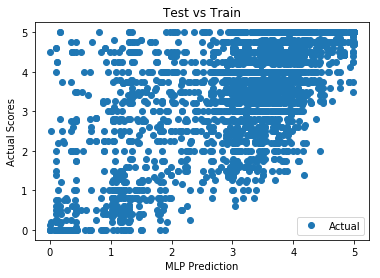

In [18]:
df = pd.DataFrame({'Predicted': test_prediction, 'Actual': testing_scores_y}) 
df['Actual-pred'] = df['Actual'].rsub(df['Predicted'])
df.describe()  
df.plot(x='Predicted', y='Actual', style='o')  
plt.title('Test vs Train')  
plt.xlabel('MLP Prediction')  
plt.ylabel('Actual Scores')  
plt.show()  

In [19]:
what_changed = "Ner, pos edit disabled, lemmas disabled, lesk jaccard and cosine disabled"
df
print(df.describe().to_string())

         Predicted       Actual  Actual-pred
count  3108.000000  3108.000000  3108.000000
mean      3.170959     3.506064    -0.335105
std       1.210150     1.370625     1.022363
min       0.000000     0.000000    -4.840133
25%       2.777767     2.809000    -0.908383
50%       3.487767     3.800000    -0.256000
75%       3.954617     4.600000     0.260000
max       5.000000     5.000000     2.782867


In [20]:
#these will be logged to your sklearn-demos project on Comet.ml
params={"main experiment changes":what_changed,
        "statistics": df.describe().to_string(),
        "random_state":random_state,
        "MLP_iterations": itera,
        "MLP_solver":solv,
        "MLP_activation":activ,
        "SVM_gamma":gamma_type,
        "SVM_C":c_val,
        "SVM_epsilon":epsilon_val
        #"stratify":True
}

metrics = {'MLP Training Accuracy':a,
'MLP Testing Accuracy':b,
'MLP Drop Train-Test':a-b,
'MLP_mod Training Accuracy':c,
'MLP_mod Testing Accuracy':d,
'MLP_mod Drop Train-Test':c-d,
'SVM Training Accuracy':e,
'SVM Testing Accuracy':f,
'SVM Drop Train-Test':e-f,
'KNN Training Accuracy':g,
'KNN Testing Accuracy':h,
'KNN Drop Train-Test':g-h
}

experiment.log_dataset_hash(X_train_scaled)
experiment.log_parameters(params)
experiment.log_metrics(metrics)